<a href="https://colab.research.google.com/github/henryonomakpo/The-Impact-of-ESG-Ratings-on-EV-Manufacturing-Industry/blob/main/Service_Sector_Panel_Regression%2C_VAR_and_ML_Random_Forest_and_XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install pandas yfinance scikit-learn statsmodels linearmodels matplotlib seaborn
!pip install xlsxwriter
!pip install openpyxl
!pip install xgboost
!pip install arch

# #### Best Performance Service Sector PDA, VAR and ML

--- Data Loading Complete ---
Fama-French Data Head:
      Date  Mkt-RF   SMB   HML   RMW   CMA    RF   WML
0  201201    5.61  1.99 -0.77 -2.01 -1.03  0.00 -6.77
1  201202    4.93 -0.87 -0.31 -0.41 -0.17  0.00 -2.62
2  201203    1.24 -0.20  0.04  0.46  1.21  0.00  3.58
3  201204   -1.11  0.25 -1.68  2.23 -0.12  0.00  4.86
4  201205   -8.88 -0.34  0.08  2.06  1.76  0.01  6.25

ESG Data Head:
   Identifier (RIC) Company Name  Date  ESG_score  Social_score  Gov_score  \
0             CPRT   Copart Inc  2021  34.576387     46.340561  37.863044   
1             CPRT   Copart Inc  2020  30.834182     34.908326  41.724447   
2             CPRT   Copart Inc  2019  38.517045     36.730229  59.760918   
3             CPRT   Copart Inc  2018  35.587338     38.254994  50.416945   
4             CPRT   Copart Inc  2017  32.078647     39.063982  40.356488   

   Env_score       BVPS   Market_cap     Shares  ... Women_Employees  \
0   1.860465  14.938290  28794173016  240290000  ...             NaN  

/usr/local/lib/python3.11/dist-packages/statsmodels/regression/linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


                          PanelOLS Estimation Summary                           
Dep. Variable:     Excess_Return_Firm   R-squared:                        0.4370
Estimator:                   PanelOLS   R-squared (Between):              0.2022
No. Observations:                 140   R-squared (Within):               0.4370
Date:                Wed, Jun 04 2025   R-squared (Overall):              0.3264
Time:                        17:38:00   Log-likelihood                   -427.36
Cov. Estimator:                Robust                                           
                                        F-statistic:                      13.194
Entities:                          14   P-value                           0.0000
Avg Obs:                      10.0000   Distribution:                   F(7,119)
Min Obs:                      10.0000                                           
Max Obs:                      10.0000   F-statistic (robust):             14.726
                            

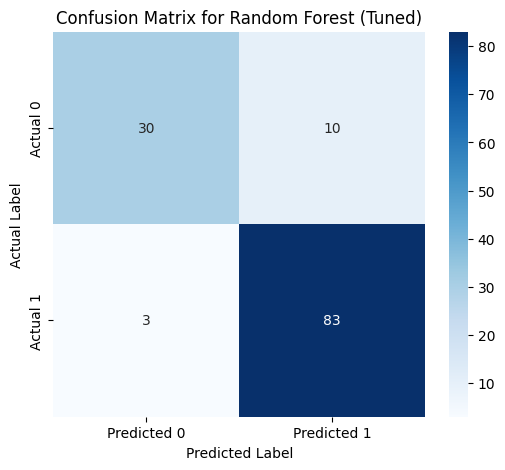

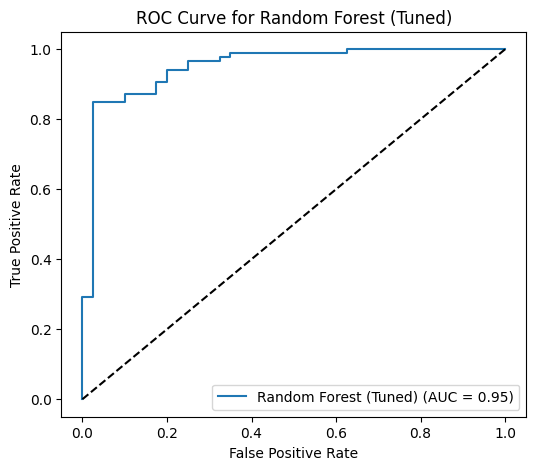


Full Classification Report (Aggregated CV Predictions):
              precision    recall  f1-score   support

           0       0.91      0.75      0.82        40
           1       0.89      0.97      0.93        86

    accuracy                           0.90       126
   macro avg       0.90      0.86      0.87       126
weighted avg       0.90      0.90      0.89       126

Note on Imbalance: Precision/Recall/F1-score for minority class (0) are crucial.
Consider techniques like SMOTE or class weighting to address imbalance.
------------------------------------------------------------

--- XGBoost (Tuned) Consolidated Cross-Validation Metrics ---
Accuracy: 0.9206
Precision: 0.9318
Recall: 0.9535
F1-Score: 0.9425
ROC AUC: 0.9695


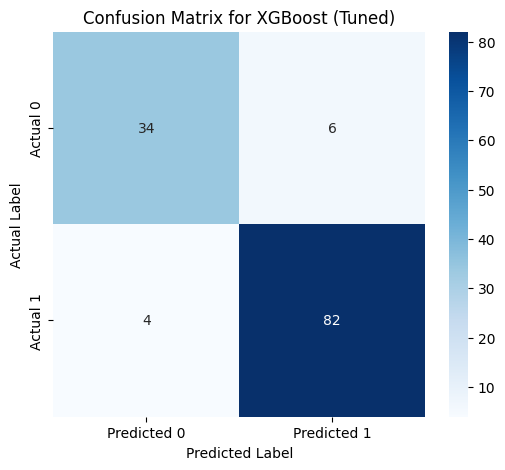

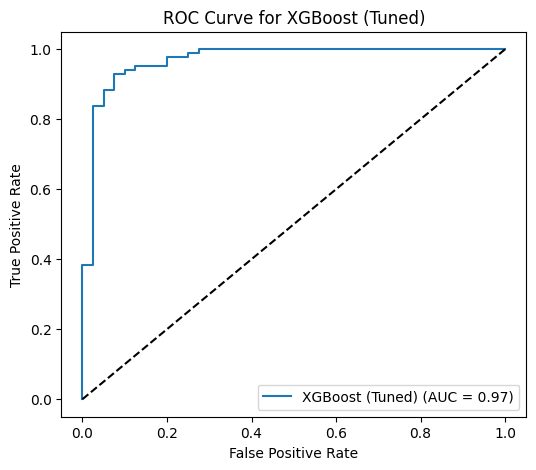


Full Classification Report (Aggregated CV Predictions):
              precision    recall  f1-score   support

           0       0.89      0.85      0.87        40
           1       0.93      0.95      0.94        86

    accuracy                           0.92       126
   macro avg       0.91      0.90      0.91       126
weighted avg       0.92      0.92      0.92       126

Note on Imbalance: Precision/Recall/F1-score for minority class (0) are crucial.
Consider techniques like SMOTE or class weighting to address imbalance.
------------------------------------------------------------

--- Feature Importance ---
Interpreting key drivers of next year's Excess Return Firm Direction.

Top 10 Feature Importances (Random Forest):
           feature  importance
35  FF_HML_CMA_PC2    0.126196
1              SMB    0.102576
34  FF_HML_CMA_PC1    0.074124
3              WML    0.069953
17    Total_assets    0.047730
9             BVPS    0.044419
4        ESG_score    0.033799
2          


SHAP Summary Plot (Random Forest): Overall Feature Impact
DEBUG: Corrected RF shap_values_rf_positive from 3D to 2D for dependence plot.
DEBUG: RF shap_values_rf_positive final shape: (100, 50)
DEBUG: RF X_shap_sample_df_rf shape: (100, 50)


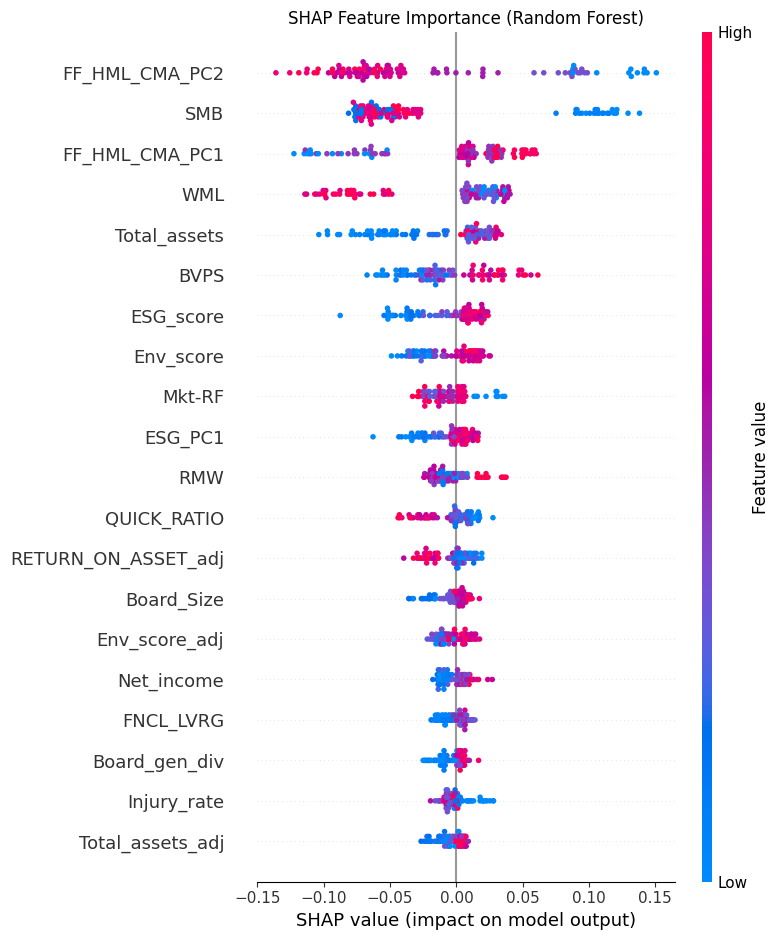


SHAP Dependence Plots (Random Forest): Non-Linearity & Interactions
Plotting dependence for: FF_HML_CMA_PC2


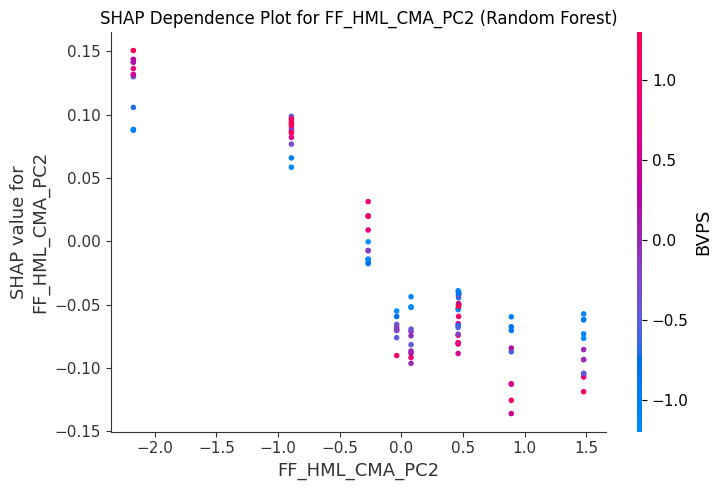

Plotting dependence for: SMB


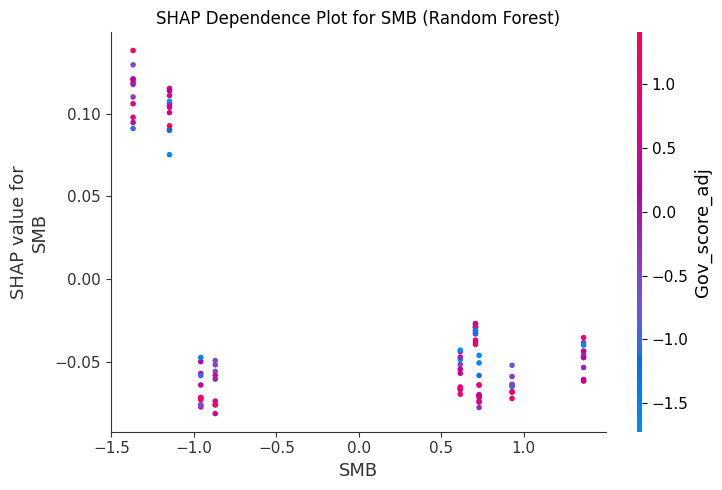

Plotting dependence for: FF_HML_CMA_PC1


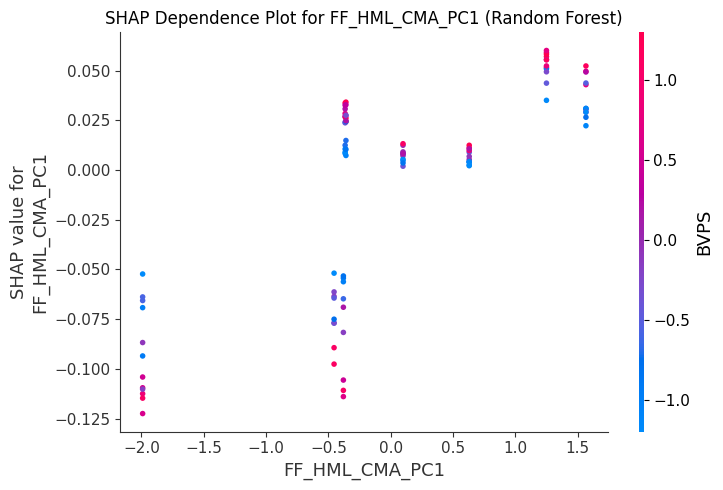


SHAP Summary Plot (XGBoost): Overall Feature Impact
DEBUG: XGB shap_values_xgb_positive final shape: (100, 50)
DEBUG: XGB X_shap_sample_df_xgb shape: (100, 50)


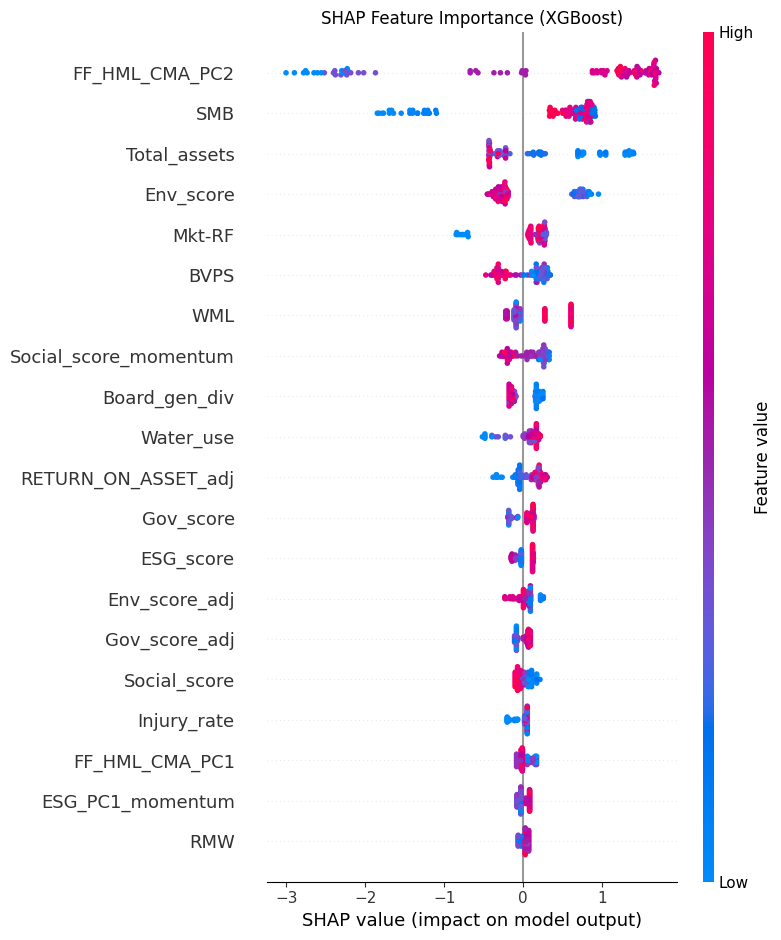


SHAP Dependence Plot (XGBoost): Non-Linearity for ESG_score
Plotting dependence for: Mkt-RF


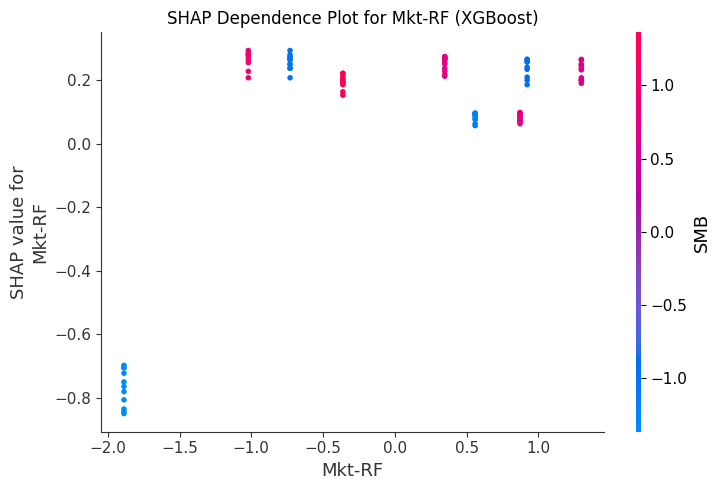

Plotting dependence for: FF_HML_CMA_PC2


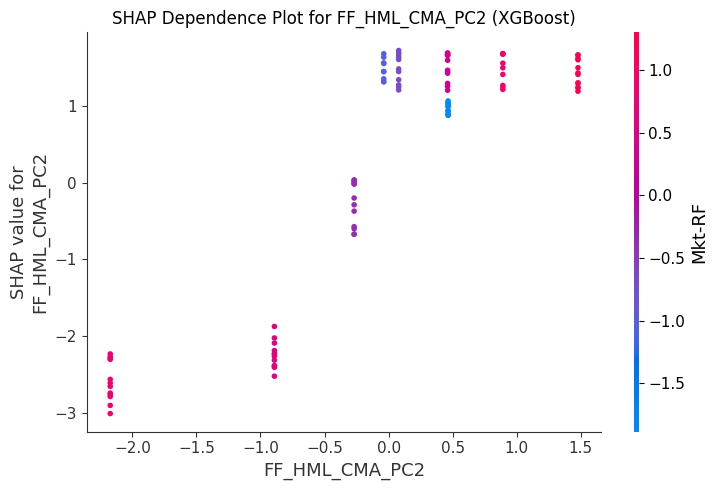

Plotting dependence for: WML


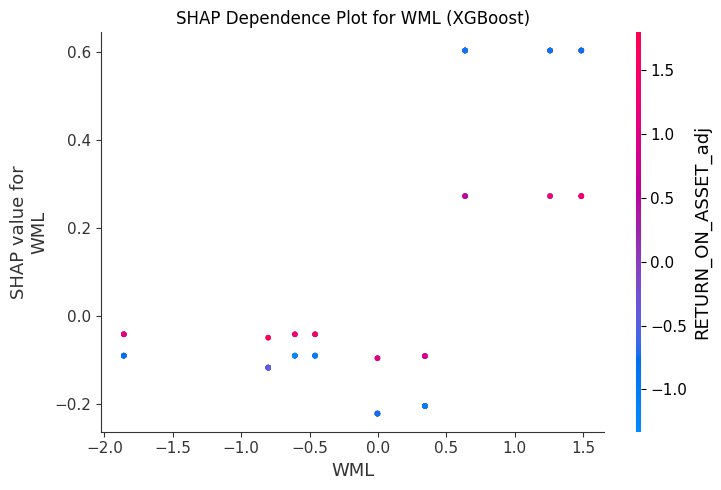


Skipping Machine Learning Analysis: Not enough unique firms for Grouped Cross-Validation.

--- Analysis Complete ---


In [11]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller, grangercausalitytests
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan
import warnings
import sys # For sys.exit()

# Suppress specific warnings for cleaner output during demonstrations
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=pd.errors.SettingWithCopyWarning)

# --- CRITICAL: Ensure linearmodels, arch, xgboost, and shap are up to date ---
# If running in Google Colab or similar environment, execute these lines
# before running the script/notebook to avoid version-related errors.
# !pip install --upgrade linearmodels arch xgboost shap matplotlib seaborn scikit-learn
# --- End of upgrade commands ---

# Enable experimental iterative imputer for MICE
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler
from linearmodels.panel import PanelOLS, RandomEffects, PooledOLS
from sklearn.decomposition import PCA # For Principal Component Analysis

# --- ML Specific Imports ---
from sklearn.ensemble import RandomForestClassifier # Changed to Classifier
from xgboost import XGBClassifier # Changed to Classifier
from sklearn.model_selection import GroupKFold, GridSearchCV # Added GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve # Classification metrics
import shap # For model interpretability
import matplotlib.pyplot as plt # For plotting
import seaborn as sns # For nicer plots


# --- 1. Load and Preprocess Data (Re-using your existing data loading and preprocessing) ---

# Load Fama-French 5 Factors data
try:
    # --- UPDATED FILE PATHS HERE ---
    ff_df = pd.read_csv('/content/ff_5_Factors.csv')
    esg_df = pd.read_csv('/content/Services_Sector_esg_dataset.csv')
except FileNotFoundError:
    print("Ensure 'ff_5_Factors.csv' and 'Services_Sector_esg_dataset.csv' are in the correct path.")
    sys.exit(1) # Exit if files are not found

print("--- Data Loading Complete ---")
print("Fama-French Data Head:\n", ff_df.head())
print("\nESG Data Head:\n", esg_df.head())

# --- Fama-French Data Preprocessing ---
ff_df['Date'] = pd.to_datetime(ff_df['Date'], format='%Y%m')
ff_df['Year'] = ff_df['Date'].dt.year
ff_df['Year'] = ff_df['Year'].astype(int)

# Use intersection to handle cases where 'WML' might be missing in a 5-factor file
all_possible_factor_cols = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF', 'WML']
factor_cols = list(set(all_possible_factor_cols).intersection(ff_df.columns))

# Ensure 'RF' is always included if available for annual aggregation mean
if 'RF' in ff_df.columns:
    non_rf_factor_cols = [col for col in factor_cols if col != 'RF']
else:
    non_rf_factor_cols = factor_cols # No RF column

# Assuming FF factors in input are already percentages (e.g., 5.61 for 5.61%)
# Convert them to decimal (e.g., 0.0561) for compounding calculations.
for col in non_rf_factor_cols:
    if col in ff_df.columns and ff_df[col].dtype in ['float64', 'int64'] and ff_df[col].max() > 1: # Heuristic: if max > 1, assume percentage
        ff_df[col] = ff_df[col] / 100.0

# Compound monthly returns to annual returns for factors (except RF)
ff_annual = ff_df.groupby('Year')[non_rf_factor_cols].apply(lambda x: (1 + x).prod() - 1, include_groups=False).reset_index()

# For RF, take the mean as it's typically risk-free rate, not compounded return for the period.
# RF should also be in decimal for correct subtraction.
if 'RF' in ff_df.columns:
    ff_annual['RF'] = ff_df.groupby('Year')['RF'].mean().reset_index(drop=True)
    # If RF was like 0.000833, keep as is. If 0.0833 (percentage), divide by 100.
    # From your output, RF is 0.000833, so it's already decimal. No further scaling needed for RF.

ff_annual['Year'] = ff_annual['Year'].astype(int)


# --- ESG Data Preprocessing ---
esg_df.rename(columns={'Date': 'Year'}, inplace=True)
esg_df['Year'] = pd.to_numeric(esg_df['Year'], errors='coerce').astype(pd.Int64Dtype())
esg_df.dropna(subset=['Identifier (RIC)', 'Year'], inplace=True)

if 'Industry' not in esg_df.columns:
    print("Warning: 'Industry' column not found in ESG data. Cannot perform industry-adjusted feature engineering.")

numeric_cols_esg = ['ESG_score', 'Social_score', 'Gov_score', 'Env_score', 'BVPS', 'Market_cap', 'Shares',
                    'Net_income', 'RETURN_ON_ASSET', 'QUICK_RATIO', 'ASSET_GROWTH', 'FNCL_LVRG',
                    'PE_RATIO', 'Scope_1', 'Scope_2', 'CO2_emissions', 'Energy_use', 'Water_use',
                    'Water_recycle', 'Toxic_chem_red', 'Injury_rate', 'Women_Employees',
                    'Human_Rights', 'Strikes', 'Turnover_empl', 'Board_Size',
                    'Shareholder_Rights', 'Board_gen_div', 'Bribery', 'Recycling_Initiatives', 'Total_assets']

for col in numeric_cols_esg:
    if col in esg_df.columns:
        esg_df[col] = pd.to_numeric(esg_df[col], errors='coerce')

# --- FIX: Assume RETURN_ON_ASSET in input is already percentage (e.g., 23.36) ---
# Do NOT divide by 100 here if it's already percentage.
# The previous `if esg_df['RETURN_ON_ASSET'].max() > 100:` check was causing issues by potentially re-scaling.
# If your raw data for RETURN_ON_ASSET is truly in big numbers (e.g., 2336 for 23.36%), then this line is needed:
# if 'RETURN_ON_ASSET' in esg_df.columns and esg_df['RETURN_ON_ASSET'].max() > 1000: # Heuristic to detect huge numbers
#     esg_df['RETURN_ON_ASSET'] = esg_df['RETURN_ON_ASSET'] / 100.0 # Scale to percentage
# For now, let's assume it's already percentage like 23.36 in the input.

print(f"\nESG Years (unique, type {esg_df['Year'].dtype}): {sorted(esg_df['Year'].dropna().unique())}")
print(f"FF Annual Years (unique, type {ff_annual['Year'].dtype}): {sorted(ff_annual['Year'].unique())}")


# --- Merge Dataframes ---
rf_for_merge = ff_annual[['Year', 'RF']].copy() if 'RF' in ff_annual.columns else pd.DataFrame(columns=['Year', 'RF'])
esg_df_merged = pd.merge(esg_df, rf_for_merge, on='Year', how='left')

# --- FIX: Calculate Excess Return of the Firm ---
# Assuming RETURN_ON_ASSET is in percentage (e.g., 23.36%)
# Assuming RF from ff_annual is in decimal (e.g., 0.000833)
# To get Excess_Return_Firm in percentage (e.g., 23.35%), RF needs to be scaled up before subtraction.
if 'RETURN_ON_ASSET' in esg_df_merged.columns and 'RF' in esg_df_merged.columns:
    esg_df_merged['Excess_Return_Firm'] = esg_df_merged['RETURN_ON_ASSET'] - (esg_df_merged['RF'] * 100.0) # RF in percentage for subtraction
else:
    print("Warning: 'Excess_Return_Firm' cannot be calculated. Ensure 'RETURN_ON_ASSET' and 'RF' are available.")
    esg_df_merged['Excess_Return_Firm'] = np.nan

# Final merge with all FF factors
final_df = pd.merge(esg_df_merged, ff_annual.drop(columns=['RF'], errors='ignore'), on='Year', how='left')

# --- Data Scaling: Convert FF factors to Percentage for consistency with Excess_Return_Firm ---
# FF factors from ff_annual are currently in decimal (0.0x) after compounding.
# Convert them to percentage (X.XX) to match Excess_Return_Firm.
ff_factors_to_scale_to_percent = [col for col in non_rf_factor_cols if col in final_df.columns and col != 'RF']
for col in ff_factors_to_scale_to_percent:
    final_df[col] = final_df[col] * 100.0


print("\n--- Merged Data Head (ESG and Fama-French) ---\n", final_df.head())
print("\nMissing values before imputation (in final_df):\n", final_df.isnull().sum()[final_df.isnull().sum() > 0])


# --- 2. MICE Imputation ---
cols_for_imputation = [
    'ESG_score', 'Social_score', 'Gov_score', 'Env_score',
    'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'WML',
    'BVPS', 'Market_cap', 'Shares', 'Net_income', 'RETURN_ON_ASSET',
    'QUICK_RATIO', 'ASSET_GROWTH', 'FNCL_LVRG', 'PE_RATIO', 'Total_assets',
    'RF', 'Excess_Return_Firm', 'Scope_1', 'Scope_2', 'CO2_emissions', 'Energy_use',
    'Water_use', 'Water_recycle', 'Toxic_chem_red', 'Injury_rate', 'Women_Employees',
    'Human_Rights', 'Strikes', 'Turnover_empl', 'Board_Size',
    'Shareholder_Rights', 'Board_gen_div', 'Bribery', 'Recycling_Initiatives'
]
cols_for_imputation = [col for col in cols_for_imputation if col in final_df.columns]

imputable_df = final_df[cols_for_imputation]
threshold = 0.8
cols_to_drop_from_imputation = [col for col in imputable_df.columns if imputable_df[col].isnull().sum() / len(imputable_df) > threshold]
imputable_df_clean = imputable_df.drop(columns=cols_to_drop_from_imputation)

if not imputable_df_clean.empty and len(imputable_df_clean.columns) > 0:
    imputer = IterativeImputer(max_iter=10, random_state=0)
    imputed_data = imputer.fit_transform(imputable_df_clean)
    imputed_df = pd.DataFrame(imputed_data, columns=imputable_df_clean.columns, index=imputable_df_clean.index)

    for col in imputed_df.columns:
        final_df[col] = imputed_df[col]
else:
    print("\nWarning: No suitable numerical columns found for MICE imputation or imputable_df_clean is empty.")


# Handle remaining NaNs after MICE (ffill/bfill for panel, then mean/median)
final_df = final_df.set_index(['Identifier (RIC)', 'Year']).sort_index()
final_df = final_df.groupby(level='Identifier (RIC)').ffill().bfill()

for col in final_df.columns:
    if final_df[col].isnull().any():
        if pd.api.types.is_numeric_dtype(final_df[col]):
            final_df[col] = final_df[col].fillna(final_df[col].mean())
        else:
            final_df[col] = final_df[col].fillna(final_df[col].mode()[0] if not final_df[col].mode().empty else 'Unknown')

print("\n--- Missing values after MICE and ffill/bfill (before final model-specific drop) ---\n", final_df.isnull().sum()[final_df.isnull().sum() > 0])

dependent_var = 'Excess_Return_Firm'
all_panel_independent_options = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'WML',
                                 'ESG_score', 'Social_score', 'Gov_score', 'Env_score']
available_for_final_drop = [col for col in all_panel_independent_options if col in final_df.columns and not final_df[col].isnull().all()]

all_vars_for_final_drop = [dependent_var] + available_for_final_drop
if 'Market_cap' in final_df.columns:
    all_vars_for_final_drop.append('Market_cap')
if 'Industry' in final_df.columns:
    all_vars_for_final_drop.append('Industry')

for col in all_vars_for_final_drop:
    if col == 'Industry':
        if not pd.api.types.is_numeric_dtype(final_df[col]):
            final_df[col] = final_df[col].astype('category')
    else:
        final_df[col] = pd.to_numeric(final_df[col], errors='coerce')


initial_rows_count = len(final_df)
final_df.dropna(subset=[col for col in all_vars_for_final_drop if col != 'Industry'], inplace=True)
dropped_rows_count = initial_rows_count - len(final_df)
print(f"\nDropped {dropped_rows_count} rows due to NaNs in essential model-specific columns (excluding Industry if categorical).")

print("\nFinal Data Head after Preprocessing and Imputation (ready for models):\n", final_df.head())
print("Shape of final_df:", final_df.shape)

if final_df.empty:
    raise ValueError("DataFrame is empty after critical NaN handling for model-specific columns. Cannot proceed with analysis.")


# --- Implement Recommendations (Continue from previous code) ---

# Recommendation 1: Refine ESG Factor Construction
if 'Market_cap' in final_df.columns and 'ESG_score' in final_df.columns:
    vw_esg_df = final_df.reset_index().copy()
    vw_esg_df['Market_cap_weighted_ESG'] = vw_esg_df['ESG_score'] * vw_esg_df['Market_cap']
    market_esg_factor_vw = vw_esg_df.groupby('Year').apply(lambda x: x['Market_cap_weighted_ESG'].sum() / x['Market_cap'].sum(), include_groups=False)\
                                    .rename('Market_ESG_Factor_VW').reset_index()
    print("\n--- Value-weighted Market ESG Factor Head ---\n", market_esg_factor_vw.head())
else:
    print("\nWarning: Skipping Value-weighted Market ESG Factor calculation. 'Market_cap' or 'ESG_score' not found.")
    market_esg_factor_vw = pd.DataFrame(columns=['Year', 'Market_ESG_Factor_VW'])


esg_sub_scores = ['ESG_score', 'Social_score', 'Gov_score', 'Env_score']
esg_sub_scores_for_pca = [col for col in esg_sub_scores if col in final_df.columns and final_df[col].std() > 0]
if len(esg_sub_scores_for_pca) >= 2:
    print(f"\n--- Performing PCA on firm-level ESG sub-scores: {esg_sub_scores_for_pca} ---")
    pca_esg_data = final_df[esg_sub_scores_for_pca].copy()

    scaler_esg_pca = StandardScaler()
    scaled_esg_data = scaler_esg_pca.fit_transform(pca_esg_data)

    pca_esg = PCA(n_components=1)
    final_df['ESG_PC1'] = pca_esg.fit_transform(scaled_esg_data)
    print(f"Explained variance ratio of ESG_PC1: {pca_esg.explained_variance_ratio_[0]:.4f}")
else:
    print(f"\nSkipping PCA for ESG sub-scores: Not enough suitable columns (needs >=2 non-constant columns). Available: {esg_sub_scores_for_pca}")
    if 'ESG_score' in final_df.columns:
        final_df['ESG_PC1'] = final_df['ESG_score']
    else:
        final_df['ESG_PC1'] = np.nan


# Recommendation 2: Address Multicollinearity (HML and CMA)
ff_factors_for_pca = ['HML', 'CMA']
ff_factors_for_pca_clean = [col for col in ff_factors_for_pca if col in final_df.columns and final_df[col].std() > 0]

if len(ff_factors_for_pca_clean) >= 2:
    print(f"\n--- Performing PCA on Fama-French factors for multicollinearity: {ff_factors_for_pca_clean} ---")
    ff_pca_components = 2
    pca_ff_data = final_df[ff_factors_for_pca_clean].copy()

    scaler_ff_pca = StandardScaler()
    scaled_ff_data = scaler_ff_pca.fit_transform(pca_ff_data)

    pca_ff = PCA(n_components=min(ff_pca_components, len(ff_factors_for_pca_clean)))
    ff_pcs = pca_ff.fit_transform(scaled_ff_data)

    final_df['FF_HML_CMA_PC1'] = ff_pcs[:, 0]
    if ff_pcs.shape[1] > 1:
        final_df['FF_HML_CMA_PC2'] = ff_pcs[:, 1]
        print(f"Explained variance ratios for FF_HML_CMA_PC1: {pca_ff.explained_variance_ratio_[0]:.4f}, FF_HML_CMA_PC2: {pca_ff.explained_variance_ratio_[1]:.4f}")
    else:
        print(f"Only one principal component extracted for FF HML/CMA.")
        final_df['FF_HML_CMA_PC2'] = np.nan

    print(f"Note: {pca_ff.explained_variance_ratio_[0]*100:.2f}% explained variance by PC1 indicates extreme collinearity between HML and CMA.")
    print("This implies they convey almost identical information, and one could potentially be dropped without PCA.")

    print("\n--- VIF Check with PCA-derived HML/CMA factors ---")
    independent_vars_panel_pca_ff = ['Mkt-RF', 'SMB', 'RMW', 'WML', 'FF_HML_CMA_PC1']
    if 'FF_HML_CMA_PC2' in final_df.columns:
        independent_vars_panel_pca_ff.append('FF_HML_CMA_PC2')
    if 'ESG_score' in final_df.columns:
        independent_vars_panel_pca_ff.append('ESG_score')

    vif_features_clean = [col for col in independent_vars_panel_pca_ff if col in final_df.columns and final_df[col].std() > 0]

    if len(vif_features_clean) > 0:
        X_vif_pca_ff = final_df[vif_features_clean].copy()
        X_vif_pca_ff_with_const = sm.add_constant(X_vif_pca_ff, has_constant='add')

        scaler_vif = StandardScaler()
        X_vif_pca_ff_scaled_values = scaler_vif.fit_transform(X_vif_pca_ff_with_const)
        X_vif_pca_ff_scaled_df = pd.DataFrame(X_vif_pca_ff_scaled_values, columns=X_vif_pca_ff_with_const.columns, index=X_vif_pca_ff_with_const.index)

        try:
            vif_data_pca_ff = pd.DataFrame()
            vif_data_pca_ff["feature"] = X_vif_pca_ff_scaled_df.columns
            vif_data_pca_ff["VIF"] = [variance_inflation_factor(X_vif_pca_ff_scaled_df.values, i) for i in range(X_vif_pca_ff_scaled_df.shape[1])]
            vif_data_pca_ff = vif_data_pca_ff.loc[vif_data_pca_ff['feature'] != 'const']
            print(vif_data_pca_ff)
        except np.linalg.LinAlgError as e:
            print(f"Error calculating VIF: {e}. This might happen if there's perfect multicollinearity or too few observations relative to features.")
            print("Skipping VIF calculation.")
    else:
        print("Insufficient or problematic features available for VIF calculation.")

    independent_vars_panel = vif_features_clean
else:
    print("\nSkipping PCA for Fama-French HML/CMA: Not enough suitable columns. Using original factors but warning about multicollinearity.")
    independent_vars_panel = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'WML', 'ESG_score']
    independent_vars_panel = [col for col in independent_vars_panel if col in final_df.columns and final_df[col].std() > 0]

    print("\n--- VIF (Variance Inflation Factor) Check with ORIGINAL factors ---")
    if len(independent_vars_panel) > 0:
        X_vif = final_df[independent_vars_panel]
        X_vif_with_const = sm.add_constant(X_vif, has_constant='add')
        X_vif_scaled_values = StandardScaler().fit_transform(X_vif_with_const)
        X_vif_scaled_df = pd.DataFrame(X_vif_scaled_values, columns=X_vif_with_const.columns, index=X_vif_with_const.index)

        try:
            vif_data = pd.DataFrame()
            vif_data["feature"] = X_vif_scaled_df.columns
            vif_data["VIF"] = [variance_inflation_factor(X_vif_scaled_df.values, i) for i in range(X_vif_scaled_df.shape[1])]
            vif_data = vif_data.loc[vif_data['feature'] != 'const']
            print(vif_data)
            if 'HML' in vif_data['feature'].values and 'CMA' in vif_data['feature'].values:
                if vif_data.loc[vif_data['feature'] == 'HML', 'VIF'].iloc[0] > 5 or \
                   vif_data.loc[vif_data['feature'] == 'CMA', 'VIF'].iloc[0] > 5:
                    print("Warning: High VIF values for HML and/or CMA indicate severe multicollinearity.")
        except np.linalg.LinAlgError as e:
            print(f"Error calculating VIF: {e}. This might happen if there's perfect multicollinearity or too few observations relative to features.")
            print("Skipping VIF calculation.")
    else:
        print("Insufficient or problematic features available for VIF calculation.")


# --- 3. Panel Data Analysis (with Robust Standard Errors) ---
print("\n--- Panel Data Analysis (with Robust Standard Errors) ---")
print(f"Dependent Variable: {dependent_var}")
print(f"Independent Variables: {independent_vars_panel}")

pooled_res, fe_res, re_res = None, None, None

if not final_df.empty and len(independent_vars_panel) > 0 and final_df.shape[0] > len(independent_vars_panel):
    exog_panel_base = final_df[independent_vars_panel]
    exog_panel_base = exog_panel_base.loc[:, exog_panel_base.std() > 0]

    if exog_panel_base.empty:
        print("Skipping Panel Data Analysis: No independent variables with variance available.")
    elif final_df[dependent_var].isnull().all():
        print("Skipping Panel Data Analysis: Dependent variable is all NaN.")
    else:
        # Pooled OLS Model
        print("\n--- Pooled OLS Model (Robust Standard Errors) ---")
        try:
            exog_pooled = sm.add_constant(exog_panel_base)
            pooled_model = PooledOLS(final_df[dependent_var], exog_pooled)
            pooled_res = pooled_model.fit(cov_type='robust')
            print(pooled_res)
        except Exception as e:
            print(f"Error running Pooled OLS: {e}")

        # Fixed Effects (Within) Model
        print("\n--- Fixed Effects (Within) Model (Robust Standard Errors) ---")
        try:
            exog_fe = sm.add_constant(exog_panel_base)
            fe_model = PanelOLS(final_df[dependent_var], exog_fe, entity_effects=True)
            fe_res = fe_model.fit(cov_type='robust')
            print(fe_res)
        except Exception as e:
            print(f"Error running Fixed Effects Model: {e}")

        # Random Effects Model
        print("\n--- Random Effects Model (Robust Standard Errors) ---")
        try:
            # Corrected: RandomEffects takes dependent and exog directly, add_constant needed for exog
            re_model = RandomEffects(final_df[dependent_var], sm.add_constant(exog_panel_base))
            re_res = re_model.fit(cov_type='robust')
            print(re_res)
        except Exception as e:
            print(f"Error running Random Effects Model: {e}")


        print("\n--- Hausman Test (Fixed vs. Random Effects) ---")
        try:
            if fe_res is not None and re_res is not None:
                # Check for linearmodels version for specific test access
                if hasattr(fe_res, 'compare') and callable(fe_res.compare):
                    try:
                        hausman_comparison = fe_res.compare(re_res)
                        if 'Hausman' in hausman_comparison.tests:
                            hausman_pvalue = hausman_comparison.tests['Hausman'].pvalue
                            hausman_stat = hausman_comparison.tests['Hausman'].stat
                            print(f"\nHausman Test Statistic: {hausman_stat:.2f}, P-value: {hausman_pvalue:.4f}")
                            if hausman_pvalue < 0.05:
                                print("Decision: Reject H0. Fixed Effects model is preferred.")
                            else:
                                print("Decision: Fail to reject H0. Random Effects model is preferred.")
                        else:
                            print("Hausman test results not found in the comparison object. This can happen with older linearmodels versions or certain model specifications.")
                            print("Please consider upgrading linearmodels: `!pip install --upgrade linearmodels`")
                    except Exception as inner_e:
                        print(f"An error occurred during Hausman test comparison: {inner_e}")
                        print("Please ensure your linearmodels library is updated: `!pip install --upgrade linearmodels`")
                else:
                    print("Hausman test comparison method may have changed (lacks .compare() method). Please update linearmodels to the latest version.")
                    print("Consider upgrading linearmodels: `!pip install --upgrade linearmodels`")
            else:
                print("Hausman test skipped: Fixed Effects or Random Effects models were not successfully fitted.")
        except Exception as e:
            print(f"An unexpected error occurred during Hausman Test: {e}.")

        print("\n--- F-Test (Pooled vs Fixed Effects) ---")
        if fe_res is not None and pooled_res is not None:
            try:
                # The .f_statistic_pooled attribute is the correct one for poolability test
                # Check for its existence to handle older versions
                if hasattr(fe_res, 'f_statistic_pooled'):
                    f_test_poolability = fe_res.f_statistic_pooled
                    print(f"F-statistic for Poolability: {f_test_poolability.stat:.3f}")
                    print(f"P-value: {f_test_poolability.pval:.4f}")
                    print(f"Distribution: F({f_test_poolability.df_num},{f_test_poolability.df_denom})")
                    if f_test_poolability.pval < 0.05:
                        print("Decision: Reject H0. Entity effects are jointly significant. Fixed Effects model is strongly preferred over Pooled OLS.")
                    else:
                        print("Decision: Fail to reject H0. Entity effects are not jointly significant. Pooled OLS might be preferred.")
                else:
                    print("f_statistic_pooled attribute not found. This might be due to linearmodels version or model specification.")
                    print("Falling back to overall F-test of Fixed Effects model.")
                    if hasattr(fe_res, 'f_statistic') and fe_res.f_statistic.pval < 0.05:
                        print(f"F-statistic for Fixed Effects overall model: {fe_res.f_statistic.stat:.2f} (p-value: {fe_res.f_statistic.pval:.4f})")
                        print("Decision based on overall FE F-test: Model is significant. Fixed Effects preferred over simple OLS (with a caveat that this is not a direct poolability test).")
                    else:
                        print(f"F-statistic for Fixed Effects overall model: {fe_res.f_statistic.stat:.2f} (p-value: {fe_res.f_statistic.pval:.4f})")
                        print("Decision based on overall FE F-test: Model is NOT significant. Pooled OLS might be preferred, but overall model fit is weak.")
            except Exception as e:
                print(f"Error performing F-test for Poolability: {e}")
        else:
            print("F-test skipped: Fixed Effects or Pooled OLS models were not successfully fitted.")


        # Recommendation 5 (Optional): Decompose ESG Score
        independent_vars_panel_decomposed_esg = ['Mkt-RF', 'SMB', 'RMW', 'WML', 'ESG_PC1', 'Social_score', 'Gov_score', 'Env_score']
        independent_vars_panel_decomposed_esg = [col for col in independent_vars_panel_decomposed_esg if col in final_df.columns and final_df[col].std() > 0]

        if len(independent_vars_panel_decomposed_esg) > 0 and final_df.shape[0] > len(independent_vars_panel_decomposed_esg):
            print("\n--- Panel Data Analysis with Decomposed ESG Factors (Robust Standard Errors) ---")
            print(f"Dependent Variable: {dependent_var}")
            print(f"Independent Variables: {independent_vars_panel_decomposed_esg}")

            try:
                exog_decomposed_esg_fe = sm.add_constant(final_df[independent_vars_panel_decomposed_esg])
                fe_decomposed_esg_model = PanelOLS(final_df[dependent_var], exog_decomposed_esg_fe, entity_effects=True)
                fe_decomposed_esg_res = fe_decomposed_esg_model.fit(cov_type='robust')
                print(fe_decomposed_esg_res)
            except Exception as e:
                print(f"Error running Fixed Effects Model with Decomposed ESG: {e}")
        else:
            print("\nSkipping Decomposed ESG Model: Not enough suitable decomposed ESG columns or no variation in them.")
else:
    print("\nSkipping all Panel Data Analysis models: Insufficient data or features after filtering essential columns.")


# --- 4. Vector Autoregression (VAR) / Vector Error Correction Model (VECM) ---
market_factors_var_base = ff_annual.set_index('Year')[['Mkt-RF', 'RF', 'SMB', 'HML', 'RMW', 'CMA', 'WML']].copy()
market_factors_var_base = market_factors_var_base[[col for col in market_factors_var_base.columns if col in ff_annual.columns]]

# Ensure market_esg_factor_vw is available and not empty before merging
if 'market_esg_factor_vw' in locals() and not market_esg_factor_vw.empty:
    var_df = pd.merge(market_factors_var_base, market_esg_factor_vw.set_index('Year'), on='Year', how='inner')

    var_data = var_df[['Mkt-RF', 'Market_ESG_Factor_VW']].copy()
    var_data.dropna(inplace=True)
    var_data = var_data.loc[:, var_data.std() > 0] # Filter columns with no variance

    print("\n--- VAR / VECM Analysis (Using Market-Level Time Series) ---")
    print("VAR Data Head:\n", var_data.head())

    print("\n--- ADF (Augmented Dickey-Fuller) Tests for Stationarity ---")
    if not var_data.empty and var_data.shape[1] >= 2:
        for col in var_data.columns:
            print(f"ADF Test for {col} (Levels):")
            if len(var_data[col].dropna()) > 1:
                adf_test_level = adfuller(var_data[col].dropna())
                print(f"  ADF Statistic: {adf_test_level[0]:.2f}")
                print(f"  P-value: {adf_test_level[1]:.4f}")
                print(f"  Critical Values (1%, 5%, 10%): {adf_test_level[4]}")
                if adf_test_level[1] < 0.05:
                    print(f"  Conclusion: {col} is likely stationary (I(0)).")
                else:
                    print(f"  Conclusion: {col} is likely non-stationary (I(1) or higher).")
                    diff_series = var_data[col].diff().dropna()
                    if not diff_series.empty and len(diff_series) > 1:
                        print(f"ADF Test for {col} (First Difference):")
                        adf_test_diff = adfuller(diff_series)
                        print(f"  ADF Statistic: {adf_test_diff[0]:.2f}")
                        print(f"  P-value: {adf_test_diff[1]:.4f}")
                        print(f"  Critical Values (1%, 5%, 10%): {adf_test_diff[4]}")
                        if adf_test_diff[1] < 0.05:
                            print(f"  Conclusion: {col} is likely stationary after first differencing (I(1)).")
                        else:
                            print(f"  Conclusion: {col} is likely non-stationary even after first differencing (I(2) or higher, or test lacks power).")
                            print("    Warning: VAR requires stationary series. Further differencing or other methods might be needed, but be cautious with limited data.")
                    else:
                        print(f"  Could not test differenced {col} due to insufficient data.")
            else:
                print(f"ADF Test for {col} (Levels): Insufficient non-NaN data points for ADF test ({len(var_data[col].dropna())} <= 1). Cannot determine stationarity.")
    else:
        print("VAR data is empty or has less than 2 columns. Skipping Stationarity Tests.")

    print("\n--- VAR Model Selection & Estimation ---")

    if not var_data.empty and 'Mkt-RF' in var_data.columns and 'Market_ESG_Factor_VW' in var_data.columns and var_data['Market_ESG_Factor_VW'].diff().dropna().shape[0] > 0:
        model_data_for_var = pd.DataFrame()
        model_data_for_var['Mkt-RF'] = var_data['Mkt-RF']
        model_data_for_var['Market_ESG_Factor_VW_diff'] = var_data['Market_ESG_Factor_VW'].diff()
        model_data_for_var.dropna(inplace=True)

        print("\nVAR model will use:")
        print("  - Mkt-RF (in levels, as it is stationary)")
        print("  - Market_ESG_Factor_VW (in first difference, assuming it becomes I(1))")
        print("  (Note: Sample size limits robustness of unit root tests and model estimation.)")

        results_var = None
        if len(model_data_for_var) > 5 and model_data_for_var.shape[1] > 1:
            model = VAR(model_data_for_var)
            try:
                calculated_maxlags = min(2, max(1, (len(model_data_for_var) // 2) - 1))
                if calculated_maxlags < 1:
                     calculated_maxlags = 1 if len(model_data_for_var) >= 3 else 0

                if calculated_maxlags > 0:
                    print(f"Fitting VAR model with maxlags={calculated_maxlags} using AIC.")
                    results_var = model.fit(maxlags=calculated_maxlags, ic='aic')
                    print(results_var.summary())

                    print("\n--- Granger Causality Tests (using original levels for conceptual test) ---")
                    if len(var_data) > 2 * calculated_maxlags and calculated_maxlags > 0:
                        gc_lag = calculated_maxlags
                        print(f"  (Using maxlag={gc_lag} for Granger tests)")

                        gc_mkt_esg = grangercausalitytests(var_data[['Mkt-RF', 'Market_ESG_Factor_VW']], maxlag=gc_lag, verbose=False)
                        for lag, test_results in gc_mkt_esg.items():
                            p_value = test_results[0]['ssr_ftest'][1]
                            print(f"  Does Mkt-RF Granger-cause Market_ESG_Factor_VW (Lag {lag})? p-value: {p_value:.4f}")
                            if p_value < 0.05:
                                print("    Yes, Mkt-RF likely Granger-causes Market_ESG_Factor_VW.")
                            else:
                                print("    No strong evidence that Mkt-RF Granger-causes Market_ESG_Factor_VW.")

                        gc_esg_mkt = grangercausalitytests(var_data[['Market_ESG_Factor_VW', 'Mkt-RF']], maxlag=gc_lag, verbose=False)
                        for lag, test_results in gc_esg_mkt.items():
                            p_value = test_results[0]['ssr_ftest'][1]
                            print(f"  Does Market_ESG_Factor_VW Granger-cause Mkt-RF (Lag {lag})? p-value: {p_value:.4f}")
                            if p_value < 0.05:
                                print("    Yes, Market_ESG_Factor_VW likely Granger-causes Mkt-RF.")
                            else:
                                print("    No strong evidence that Market_ESG_Factor_VW Granger-causes Mkt-RF.")
                    else:
                        print(f"VAR data is too short for Granger Causality tests at calculated maxlag={calculated_maxlags}.")
                        if calculated_maxlags == 0:
                            print("  Maxlag is 0, Granger Causality test requires at least lag 1.")


                    print("\n--- Homoskedasticity Test (Breusch-Pagan) on VAR Residuals ---")
                    for i, col_name in enumerate(model_data_for_var.columns):
                        resid = results_var.resid.iloc[:, i].dropna()
                        exog_bp = sm.add_constant(results_var.fittedvalues.loc[resid.index].iloc[:,i:i+1])

                        if exog_bp.empty or resid.empty or exog_bp.shape[0] != resid.shape[0] or exog_bp.shape[1] == 0:
                            print(f"    Could not perform Breusch-Pagan for {col_name}: Data mismatch or empty for BP test (shapes: resid={resid.shape}, exog={exog_bp.shape}).")
                            continue
                        try:
                            lm_stat, lm_p_value, f_stat, f_p_value = het_breuschpagan(resid, exog_bp)

                            print(f"  Breusch-Pagan Test for {col_name} residuals:")
                            print(f"    LM Statistic: {lm_stat:.2f}, P-value (LM): {lm_p_value:.4f}")
                            print(f"    F-Statistic: {f_stat:.2f}, P-value (F): {f_p_value:.4f}")
                            if lm_p_value < 0.05:
                                print(f"    Conclusion: Significant heteroskedasticity in {col_name} residuals (LM test).")
                            else:
                                print(f"    Conclusion: No significant heteroskedasticity in {col_name} residuals (LM test).")
                        except Exception as e:
                            print(f"    An unexpected error occurred during Breusch-Pagan for {col_name}: {e}")
                else:
                    print(f"Cannot fit VAR model with maxlags=0, skipping. Requires at least 3 observations for lag 1.")

            except Exception as e:
                print(f"Error fitting VAR model: {e}")
        else:
            print(f"Not enough data points ({len(model_data_for_var)}) for VAR model estimation. Requires >5 observations and 2+ variables with variance.")
    else:
        print("VAR data is empty or missing essential columns. Skipping VAR analysis.")
else:
    print("VAR/VECM Analysis skipped: Market ESG Factor not calculated or is empty.")


# --- 5. GARCH (Generalized Autoregressive Conditional Heteroskedasticity) Models ---
try:
    from arch import arch_model
    print("\n--- GARCH Models (for Market Excess Returns) ---")

    if 'Mkt-RF' in var_df.columns: # Assuming var_df comes from earlier VAR preparation
        garch_data = var_df['Mkt-RF'].dropna()

        if len(garch_data) >= 10:
            am = arch_model(garch_data, vol='Garch', p=1, q=1, rescale=False)
            res_garch = am.fit(disp='off')
            print(res_garch.summary())

            print("\n--- Basic GARCH(1,1) for Mkt-RF Volatility ---")
            print(res_garch.summary())
            print("Note: GARCH-M extends this by adding conditional variance/std dev to the mean equation.")
            print("Factor-GARCH models could incorporate FF factors as exogenous regressors (e.g., Mkt-RF in mean equation).")
            print("Robust GARCH estimation typically requires significantly more observations than available (e.g., hundreds or thousands of daily/monthly points).")

        else:
            print(f"Not enough data points ({len(garch_data)}) for GARCH model estimation. A minimum of 10 observations is used here for basic GARCH. For robust GARCH, more data is usually needed.")
    else:
        print("Skipping GARCH models: 'Mkt-RF' column not found in data for GARCH analysis.")

except ImportError:
    print("\nThe 'arch' library is required for GARCH models. Please install it: pip install arch")
except Exception as e:
    print(f"An error occurred during GARCH analysis: {e}")


# --- 6. Machine Learning Analysis (Random Forest & XGBoost) ---
print("\n--- 6. Machine Learning Analysis (Random Forest & XGBoost) ---")

# --- Feature Engineering ---
print("\n--- Feature Engineering for ML Models ---")
temp_df = final_df.reset_index()

# 1. ESG Momentum (Year-over-Year Change)
for esg_col in ['ESG_score', 'Social_score', 'Gov_score', 'Env_score', 'ESG_PC1']:
    if esg_col in temp_df.columns and pd.api.types.is_numeric_dtype(temp_df[esg_col]):
        temp_df[f'{esg_col}_momentum'] = temp_df.groupby('Identifier (RIC)')[esg_col].diff()
        print(f"  - Created {esg_col}_momentum")
    else:
        print(f"  Warning: Skipping momentum for '{esg_col}' as it is not in the DataFrame or not numeric.")


# 2. Industry-Adjusted Metrics (if 'Industry' column is available and valid)
industry_numeric_cols = ['ESG_score', 'Social_score', 'Gov_score', 'Env_score', 'ESG_PC1',
                         'Market_cap', 'RETURN_ON_ASSET', 'PE_RATIO', 'Total_assets']
industry_numeric_cols_clean = [col for col in industry_numeric_cols if col in temp_df.columns and pd.api.types.is_numeric_dtype(temp_df[col]) and temp_df[col].std() > 0]

if 'Industry' in temp_df.columns and not temp_df['Industry'].isnull().all():
    print("  - Calculating industry-adjusted features...")
    actual_industry_adj_features_created = []
    for col in industry_numeric_cols_clean:
        temp_df[f'{col}_industry_mean'] = temp_df.groupby(['Year', 'Industry'])[col].transform('mean')
        temp_df[f'{col}_adj'] = temp_df[col] - temp_df[f'{col}_industry_mean']
        actual_industry_adj_features_created.append(f'{col}_adj')
    print(f"    - Created {', '.join(actual_industry_adj_features_created)}")
else:
    print("  - Skipping industry-adjusted features: 'Industry' column not available or contains only NaNs.")

final_df_ml = temp_df.set_index(['Identifier (RIC)', 'Year']).sort_index()

final_df_ml['Excess_Return_Firm_next_year'] = final_df_ml.groupby(level='Identifier (RIC)')['Excess_Return_Firm'].shift(-1)
final_df_ml['Excess_Return_Firm_next_year_Direction'] = (final_df_ml['Excess_Return_Firm_next_year'] > 0).astype(int)

ml_features = [
    'Mkt-RF', 'SMB', 'RMW', 'WML',
    'ESG_score', 'Social_score', 'Gov_score', 'Env_score', 'ESG_PC1',
    'BVPS', 'Market_cap', 'Shares', 'Net_income',
    'QUICK_RATIO', 'ASSET_GROWTH', 'FNCL_LVRG', 'PE_RATIO', 'Total_assets',
    'Scope_1', 'Scope_2', 'CO2_emissions', 'Energy_use', 'Water_use',
    'Water_recycle', 'Toxic_chem_red', 'Injury_rate', 'Women_Employees',
    'Human_Rights', 'Strikes', 'Turnover_empl', 'Board_Size',
    'Shareholder_Rights', 'Board_gen_div', 'Bribery', 'Recycling_Initiatives'
]

if 'FF_HML_CMA_PC1' in final_df_ml.columns:
    ml_features.append('FF_HML_CMA_PC1')
if 'FF_HML_CMA_PC2' in final_df_ml.columns:
    ml_features.append('FF_HML_CMA_PC2')

for col in final_df_ml.columns:
    if '_momentum' in col or '_adj' in col:
        ml_features.append(col)

ml_features_clean = []
for col in ml_features:
    if col in final_df_ml.columns and pd.api.types.is_numeric_dtype(final_df_ml[col]) and not final_df_ml[col].isnull().all() and final_df_ml[col].std() > 1e-9:
        ml_features_clean.append(col)
    elif col == 'Industry' and 'Industry' in final_df_ml.columns:
        print("Note: 'Industry' column is categorical and was excluded from numerical features. Consider one-hot encoding if needed.")


if len(ml_features_clean) == 0:
    print("Error: No numeric features available for ML after cleaning. Please check 'ml_features' list and data types.")
    sys.exit(1)


ml_df = final_df_ml.dropna(subset=['Excess_Return_Firm_next_year_Direction'] + ml_features_clean).copy()

X_ml = ml_df[ml_features_clean]
y_ml = ml_df['Excess_Return_Firm_next_year_Direction']
groups_ml = ml_df.index.get_level_values('Identifier (RIC)')

print(f"\nML Data Shape (for predicting next year's return direction): {X_ml.shape}")
print(f"Number of unique firms for ML: {len(groups_ml.unique())}")
print(f"Years covered by ML data: {ml_df.index.get_level_values('Year').min()} - {ml_df.index.get_level_values('Year').max()}")
print(f"Class distribution (0=negative/zero, 1=positive returns): \n{y_ml.value_counts(normalize=True)}")

# --- CRITICAL WARNING: Small sample size for ML ---
num_unique_firms_ml = len(groups_ml.unique())
if X_ml.empty or y_ml.empty or num_unique_firms_ml < 2 or y_ml.nunique() < 2:
    print("Not enough data or firms for robust ML analysis after lagging, feature engineering, and dropping NaNs. Skipping ML section.")
else:
    print(f"\n--- CRITICAL WARNING: SMALL NUMBER OF UNIQUE FIRMS FOR ML ({num_unique_firms_ml} firms) ---")
    print("Machine Learning models are being trained on data from a very limited number of unique firms.")
    print("This severely limits the generalizability of the models and increases the risk of overfitting to specific firm characteristics.")
    print("Results should be considered exploratory and not suitable for drawing robust, generalizable conclusions.")
    print("-" * 80)

    scaler_ml = StandardScaler()
    X_scaled_ml = scaler_ml.fit_transform(X_ml)
    X_scaled_ml_df = pd.DataFrame(X_scaled_ml, columns=X_ml.columns, index=X_ml.index)

    n_splits = min(5, num_unique_firms_ml)

    if n_splits < 2:
        print(f"Warning: Not enough unique firms ({num_unique_firms_ml}) for robust GroupKFold (min 2 splits).")
        print("Skipping full ML model training and interpretation due to insufficient unique firms for Grouped Cross-Validation.")
        print("For more robust results, ensure you have more unique 'Identifier (RIC)' values in your data.")
    else:
        gkf = GroupKFold(n_splits=n_splits)
        print(f"\nPerforming {n_splits}-fold Grouped Cross-Validation with Hyperparameter Tuning...")

        param_grid_rf = {
            'n_estimators': [50, 100],
            'max_depth': [5, 10],
            'min_samples_split': [2, 5]
        }
        param_grid_xgb = {
            'n_estimators': [50, 100],
            'max_depth': [3, 5],
            'learning_rate': [0.1, 0.05],
            'use_label_encoder': [False],
            'eval_metric': ['logloss']
        }

        print("\n--- Tuning Random Forest Classifier ---")
        grid_search_rf = GridSearchCV(RandomForestClassifier(random_state=42, class_weight='balanced'), param_grid_rf, cv=gkf, scoring='roc_auc', n_jobs=-1, verbose=1)
        try:
            grid_search_rf.fit(X_scaled_ml_df, y_ml, groups=groups_ml)
            best_rf_model = grid_search_rf.best_estimator_
            print(f"Best Random Forest Parameters: {grid_search_rf.best_params_}")
            print(f"Best Random Forest ROC AUC (CV): {grid_search_rf.best_score_:.4f}")
        except Exception as e:
            print(f"Error during Random Forest GridSearchCV: {e}")
            print("Skipping Random Forest analysis.")
            best_rf_model = None


        print("\n--- Tuning XGBoost Classifier ---")
        scale_pos_weight_val = (y_ml == 0).sum() / (y_ml == 1).sum() if (y_ml == 1).sum() > 0 else 1.0
        grid_search_xgb = GridSearchCV(XGBClassifier(random_state=42, scale_pos_weight=scale_pos_weight_val), param_grid_xgb, cv=gkf, scoring='roc_auc', n_jobs=-1, verbose=1)
        try:
            grid_search_xgb.fit(X_scaled_ml_df, y_ml, groups=groups_ml)
            best_xgb_model = grid_search_xgb.best_estimator_
            print(f"Best XGBoost Parameters: {grid_search_xgb.best_params_}")
            print(f"Best XGBoost ROC AUC (CV): {grid_search_xgb.best_score_:.4f}")
        except Exception as e:
            print(f"Error during XGBoost GridSearchCV: {e}")
            print("Skipping XGBoost analysis.")
            best_xgb_model = None

        print("\n--- Evaluating Best Models on Cross-Validation ---")
        models = {}
        if best_rf_model: models['Random Forest (Tuned)'] = best_rf_model
        if best_xgb_model: models['XGBoost (Tuned)'] = best_xgb_model

        for name, model in models.items():
            all_y_test = []
            all_y_pred = []
            all_y_proba = []

            for fold, (train_idx, test_idx) in enumerate(gkf.split(X_scaled_ml_df, y_ml, groups_ml)):
                X_train, X_test = X_scaled_ml_df.iloc[train_idx], X_scaled_ml_df.iloc[test_idx]
                y_train, y_test = y_ml.iloc[train_idx], y_ml.iloc[test_idx]

                if X_train.empty or X_test.empty or y_train.empty or y_test.empty or y_train.nunique() < 2 or y_test.nunique() < 2:
                    print(f"Skipping fold {fold} for {name} due to insufficient classes or empty train/test split.")
                    continue

                try:
                    model.fit(X_train, y_train)
                    y_pred_fold = model.predict(X_test)
                    y_proba_fold = model.predict_proba(X_test)[:, 1]

                    all_y_test.extend(y_test)
                    all_y_pred.extend(y_pred_fold)
                    all_y_proba.extend(y_proba_fold)
                except Exception as e:
                    print(f"Error during fitting/predicting in fold {fold} for {name}: {e}")
                    continue

            if all_y_test:
                print(f"\n--- {name} Consolidated Cross-Validation Metrics ---")
                print(f"Accuracy: {accuracy_score(all_y_test, all_y_pred):.4f}")
                print(f"Precision: {precision_score(all_y_test, all_y_pred, zero_division=0):.4f}")
                print(f"Recall: {recall_score(all_y_test, all_y_pred, zero_division=0):.4f}")
                print(f"F1-Score: {f1_score(all_y_test, all_y_pred, zero_division=0):.4f}")
                print(f"ROC AUC: {roc_auc_score(all_y_test, all_y_proba):.4f}")

                cm = confusion_matrix(all_y_test, all_y_pred)
                plt.figure(figsize=(6, 5))
                sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
                plt.title(f'Confusion Matrix for {name}')
                plt.ylabel('Actual Label')
                plt.xlabel('Predicted Label')
                plt.show()

                fpr, tpr, _ = roc_curve(all_y_test, all_y_proba)
                plt.figure(figsize=(6, 5))
                plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc_score(all_y_test, all_y_proba):.2f})')
                plt.plot([0, 1], [0, 1], 'k--')
                plt.xlabel('False Positive Rate')
                plt.ylabel('True Positive Rate')
                plt.title(f'ROC Curve for {name}')
                plt.legend(loc='lower right')
                plt.show()

                print("\nFull Classification Report (Aggregated CV Predictions):")
                print(classification_report(all_y_test, all_y_pred, zero_division=0))
                print("Note on Imbalance: Precision/Recall/F1-score for minority class (0) are crucial.")
                print("Consider techniques like SMOTE or class weighting to address imbalance.")
                print("-" * 60)

            else:
                print(f"\n--- {name} Cross-Validation Results ---")
                print("Could not complete cross-validation due to insufficient data splits or empty test sets.")


        print("\n--- Feature Importance ---")
        print("Interpreting key drivers of next year's Excess Return Firm Direction.")

        if best_rf_model:
            final_rf_model = best_rf_model
            feature_importances_rf = pd.DataFrame({
                'feature': X_ml.columns,
                'importance': final_rf_model.feature_importances_
            }).sort_values(by='importance', ascending=False)
            print("\nTop 10 Feature Importances (Random Forest):")
            print(feature_importances_rf.head(10))
        else:
            print("\nRandom Forest model not trained, skipping feature importance.")

        if best_xgb_model:
            final_xgb_model = best_xgb_model
            feature_importances_xgb = pd.DataFrame({
                'feature': X_ml.columns,
                'importance': final_xgb_model.feature_importances_
            }).sort_values(by='importance', ascending=False)
            print("\nTop 10 Feature Importances (XGBoost):")
            print(feature_importances_xgb.head(10))
        else:
            print("\nXGBoost model not trained, skipping feature importance.")

        print("\n--- Model Interpretability (SHAP Values) ---")
        print("Understanding non-linear effects, interactions, and contextual dependence.")
        print("\n--- CRITICAL WARNING: SHAP plots for small sample sizes can be sparse or misleading. ---")
        print("Dependence plots especially may not show clear trends or interactions with limited data points.")
        print("Interpret these visualizations with extreme caution.")
        print("-" * 80)

        shap.initjs()

        if best_rf_model and not X_scaled_ml_df.empty:
            print("\nSHAP Summary Plot (Random Forest): Overall Feature Impact")
            try:
                sample_size_for_shap = min(100, X_scaled_ml_df.shape[0])
                np.random.seed(42)
                sampled_indices_rf = np.random.choice(X_scaled_ml_df.index, size=sample_size_for_shap, replace=False)
                X_shap_sample_df_rf = X_scaled_ml_df.loc[sampled_indices_rf]

                # Filter out columns with no variance for SHAP plotting robustness
                X_shap_sample_df_rf = X_shap_sample_df_rf.loc[:, X_shap_sample_df_rf.std() > 0]
                if X_shap_sample_df_rf.empty or X_shap_sample_df_rf.isnull().all().all():
                    print("Skipping SHAP for Random Forest: Sampled data is empty or all NaN/no variance after filtering.")
                else:
                    explainer_rf = shap.TreeExplainer(best_rf_model)
                    shap_values_rf = explainer_rf.shap_values(X_shap_sample_df_rf)

                    if isinstance(shap_values_rf, list) and len(shap_values_rf) > 1:
                        shap_values_rf_positive = shap_values_rf[1]
                    else:
                        shap_values_rf_positive = shap_values_rf

                    # FIX: Ensure shap_values_rf_positive is 2D if it's 3D
                    if shap_values_rf_positive.ndim == 3 and shap_values_rf_positive.shape[2] == 2: # This means it has an extra dimension for some reason
                        shap_values_rf_positive = shap_values_rf_positive[:, :, 0] # Take the first slice, usually
                        print("DEBUG: Corrected RF shap_values_rf_positive from 3D to 2D for dependence plot.")
                    elif shap_values_rf_positive.ndim != 2:
                        print(f"Warning: RF shap_values_rf_positive has unexpected dimensions: {shap_values_rf_positive.shape}. May cause issues.")

                    print(f"DEBUG: RF shap_values_rf_positive final shape: {shap_values_rf_positive.shape}")
                    print(f"DEBUG: RF X_shap_sample_df_rf shape: {X_shap_sample_df_rf.shape}")

                    shap.summary_plot(shap_values_rf_positive, X_shap_sample_df_rf, feature_names=X_shap_sample_df_rf.columns, show=False)
                    plt.title("SHAP Feature Importance (Random Forest)")
                    plt.tight_layout()
                    plt.show()

                    print("\nSHAP Dependence Plots (Random Forest): Non-Linearity & Interactions")
                    top_rf_features_for_plot = feature_importances_rf['feature'].head(3).tolist()
                    for feature_name in top_rf_features_for_plot:
                        if feature_name in X_shap_sample_df_rf.columns and pd.api.types.is_numeric_dtype(X_shap_sample_df_rf[feature_name]) and X_shap_sample_df_rf[feature_name].nunique() > 1:
                            print(f"Plotting dependence for: {feature_name}")
                            shap.dependence_plot(
                                ind=feature_name,
                                shap_values=shap_values_rf_positive,
                                features=X_shap_sample_df_rf,
                                feature_names=X_shap_sample_df_rf.columns,
                                interaction_index='auto',
                                show=False
                            )
                            plt.title(f"SHAP Dependence Plot for {feature_name} (Random Forest)")
                            plt.tight_layout()
                            plt.show()
                        else:
                            print(f"Skipping dependence plot for '{feature_name}': not in sample, not numeric, or no variation.")

            except Exception as e:
                print(f"Error during SHAP analysis for Random Forest: {e}")
                print("Consider using a smaller sample for SHAP or addressing memory issues if data is very large.")
                plt.close()
        else:
            print("\nSkipping SHAP analysis for Random Forest: Model not trained or data empty.")


        if best_xgb_model and not X_scaled_ml_df.empty:
            print("\nSHAP Summary Plot (XGBoost): Overall Feature Impact")
            try:
                sample_size_for_shap = min(100, X_scaled_ml_df.shape[0])
                np.random.seed(42)
                sampled_indices_xgb = np.random.choice(X_scaled_ml_df.index, size=sample_size_for_shap, replace=False)
                X_shap_sample_df_xgb = X_scaled_ml_df.loc[sampled_indices_xgb]

                # Filter out columns with no variance for SHAP plotting robustness
                X_shap_sample_df_xgb = X_shap_sample_df_xgb.loc[:, X_shap_sample_df_xgb.std() > 0]
                if X_shap_sample_df_xgb.empty or X_shap_sample_df_xgb.isnull().all().all():
                    print("Skipping SHAP for XGBoost: Sampled data is empty or all NaN/no variance after filtering.")
                else:
                    explainer_xgb = shap.TreeExplainer(best_xgb_model)
                    shap_values_xgb = explainer_xgb.shap_values(X_shap_sample_df_xgb)

                    if isinstance(shap_values_xgb, list) and len(shap_values_xgb) > 1:
                        shap_values_xgb_positive = shap_values_xgb[1]
                    else:
                        shap_values_xgb_positive = shap_values_xgb

                    if shap_values_xgb_positive.ndim != 2:
                        print(f"Warning: XGB shap_values_xgb_positive has unexpected dimensions: {shap_values_xgb_positive.shape}. May cause issues.")

                    print(f"DEBUG: XGB shap_values_xgb_positive final shape: {shap_values_xgb_positive.shape}")
                    print(f"DEBUG: XGB X_shap_sample_df_xgb shape: {X_shap_sample_df_xgb.shape}")

                    shap.summary_plot(shap_values_xgb_positive, X_shap_sample_df_xgb, feature_names=X_shap_sample_df_xgb.columns, show=False)
                    plt.title("SHAP Feature Importance (XGBoost)")
                    plt.tight_layout()
                    plt.show()

                    print("\nSHAP Dependence Plot (XGBoost): Non-Linearity for ESG_score")
                    top_xgb_features_for_plot = feature_importances_xgb['feature'].head(3).tolist()
                    for feature_name in top_xgb_features_for_plot:
                        if feature_name in X_shap_sample_df_xgb.columns and pd.api.types.is_numeric_dtype(X_shap_sample_df_xgb[feature_name]) and X_shap_sample_df_xgb[feature_name].nunique() > 1:
                            print(f"Plotting dependence for: {feature_name}")
                            shap.dependence_plot(
                                ind=feature_name,
                                shap_values=shap_values_xgb_positive,
                                features=X_shap_sample_df_xgb,
                                feature_names=X_shap_sample_df_xgb.columns,
                                interaction_index='auto',
                                show=False
                            )
                            plt.title(f"SHAP Dependence Plot for {feature_name} (XGBoost)")
                            plt.tight_layout()
                            plt.show()
                        else:
                            print(f"Skipping dependence plot for '{feature_name}': not in sample, not numeric, or no variation.")

            except Exception as e:
                print(f"Error during SHAP analysis for XGBoost: {e}")
                plt.close()
        else:
            print("\nSkipping SHAP analysis for XGBoost: Model not trained or data empty.")
#else:
    print("\nSkipping Machine Learning Analysis: Not enough unique firms for Grouped Cross-Validation.")

print("\n--- Analysis Complete ---")

#### TRANSPORT PDA, VAR and ML

--- Data Loading Complete ---
Fama-French Data Head:
      Date  Mkt-RF   SMB   HML   RMW   CMA    RF   WML
0  201201    5.61  1.99 -0.77 -2.01 -1.03  0.00 -6.77
1  201202    4.93 -0.87 -0.31 -0.41 -0.17  0.00 -2.62
2  201203    1.24 -0.20  0.04  0.46  1.21  0.00  3.58
3  201204   -1.11  0.25 -1.68  2.23 -0.12  0.00  4.86
4  201205   -8.88 -0.34  0.08  2.06  1.76  0.01  6.25

ESG Data Head:
   Identifier (RIC)                 Company Name  Date  ESG_score  \
0              AAL  American Airlines Group Inc  2021  59.029107   
1              AAL  American Airlines Group Inc  2020  69.401178   
2              AAL  American Airlines Group Inc  2019  69.369228   
3              AAL  American Airlines Group Inc  2018  71.633022   
4              AAL  American Airlines Group Inc  2017  69.791371   

   Social_score  Gov_score  Env_score       BVPS    Market_cap     Shares  \
0     64.286018  56.398116  54.385152 -11.397250  1.019831e+10  644015000   
1     68.814485  83.943615  56.966001 -14.

/usr/local/lib/python3.11/dist-packages/statsmodels/regression/linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


                        RandomEffects Estimation Summary                        
Dep. Variable:     Excess_Return_Firm   R-squared:                        0.5241
Estimator:              RandomEffects   R-squared (Between):              0.3677
No. Observations:                 140   R-squared (Within):               0.5306
Date:                Wed, Jun 04 2025   R-squared (Overall):              0.4899
Time:                        17:45:26   Log-likelihood                   -439.00
Cov. Estimator:                Robust                                           
                                        F-statistic:                      20.765
Entities:                          14   P-value                           0.0000
Avg Obs:                      10.0000   Distribution:                   F(7,132)
Min Obs:                      10.0000                                           
Max Obs:                      10.0000   F-statistic (robust):             22.371
                            

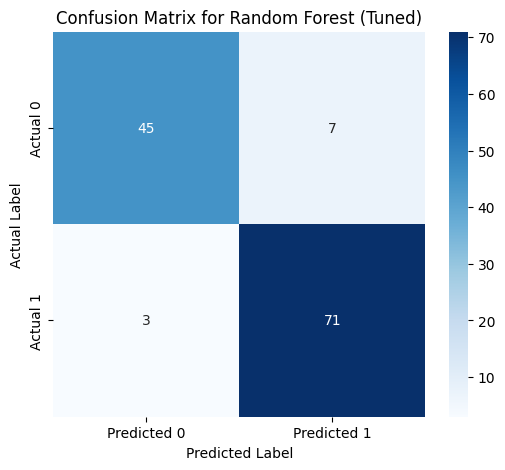

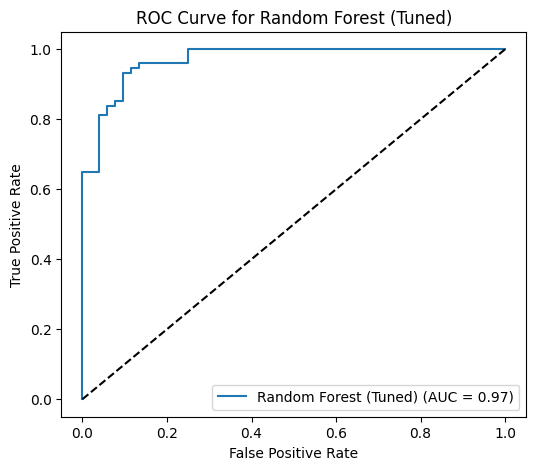


Full Classification Report (Aggregated CV Predictions):
              precision    recall  f1-score   support

           0       0.94      0.87      0.90        52
           1       0.91      0.96      0.93        74

    accuracy                           0.92       126
   macro avg       0.92      0.91      0.92       126
weighted avg       0.92      0.92      0.92       126

Note on Imbalance: Precision/Recall/F1-score for minority class (0) are crucial.
Consider techniques like SMOTE or class weighting to address imbalance.
------------------------------------------------------------

--- XGBoost (Tuned) Consolidated Cross-Validation Metrics ---
Accuracy: 0.8651
Precision: 0.8904
Recall: 0.8784
F1-Score: 0.8844
ROC AUC: 0.9592


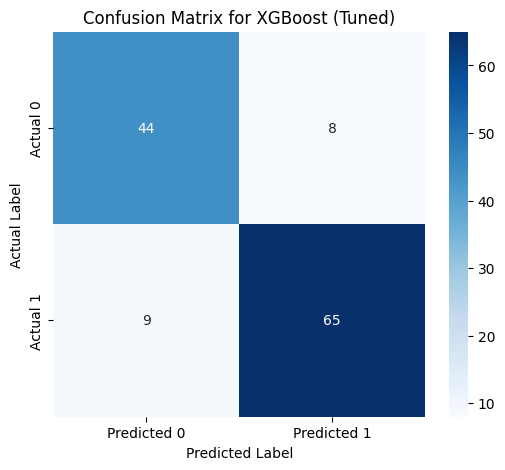

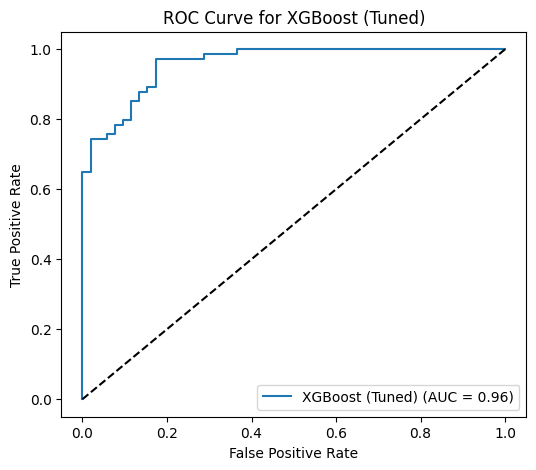


Full Classification Report (Aggregated CV Predictions):
              precision    recall  f1-score   support

           0       0.83      0.85      0.84        52
           1       0.89      0.88      0.88        74

    accuracy                           0.87       126
   macro avg       0.86      0.86      0.86       126
weighted avg       0.87      0.87      0.87       126

Note on Imbalance: Precision/Recall/F1-score for minority class (0) are crucial.
Consider techniques like SMOTE or class weighting to address imbalance.
------------------------------------------------------------

--- Feature Importance ---
Interpreting key drivers of next year's Excess Return Firm Direction.

Top 10 Feature Importances (Random Forest):
           feature  importance
1              SMB    0.121051
3              WML    0.084443
33  FF_HML_CMA_PC2    0.067076
0           Mkt-RF    0.055610
17    Total_assets    0.047995
16        PE_RATIO    0.037674
2              RMW    0.035845
9          


SHAP Summary Plot (Random Forest): Overall Feature Impact
DEBUG: Corrected RF shap_values_rf_positive from 3D to 2D for dependence plot.
DEBUG: RF shap_values_rf_positive final shape: (100, 48)
DEBUG: RF X_shap_sample_df_rf shape: (100, 48)


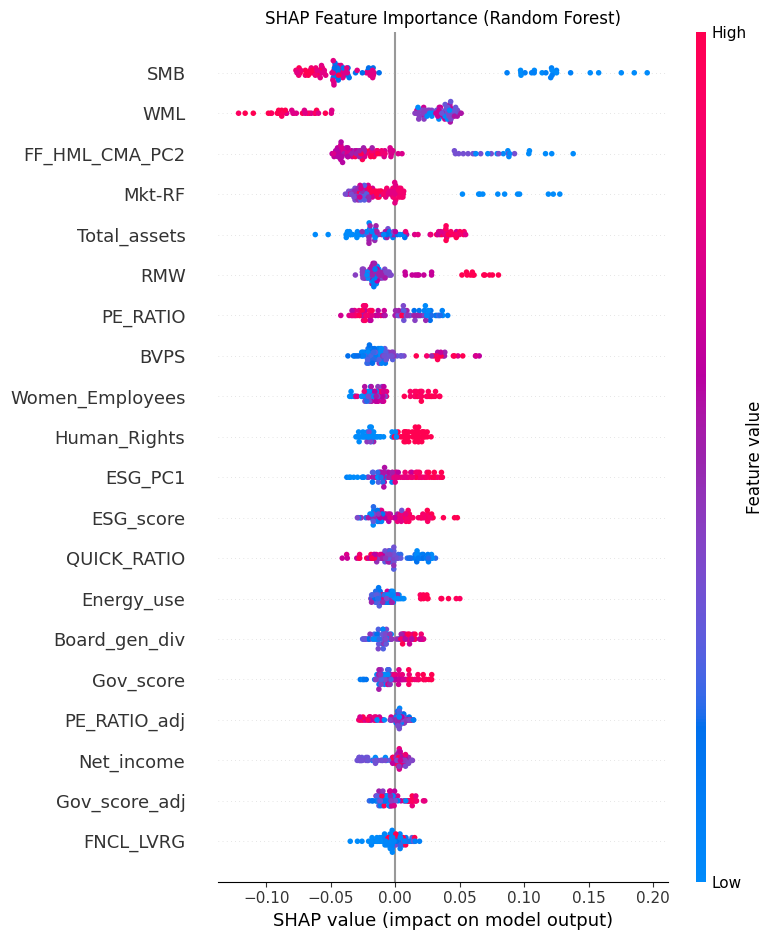


SHAP Dependence Plots (Random Forest): Non-Linearity & Interactions
Plotting dependence for: SMB


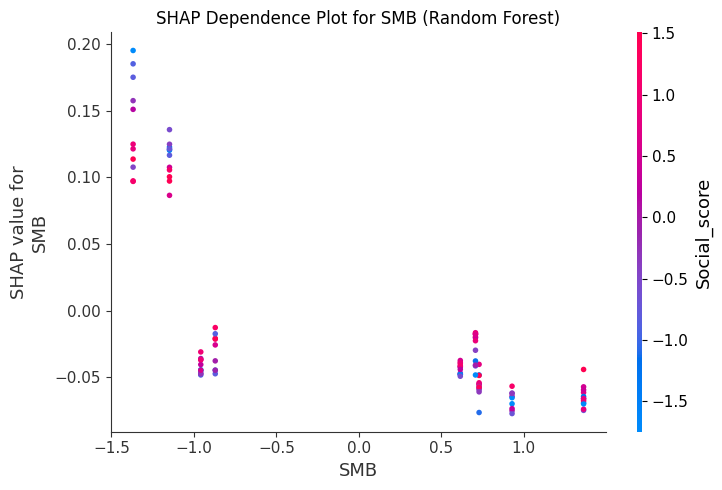

Plotting dependence for: WML


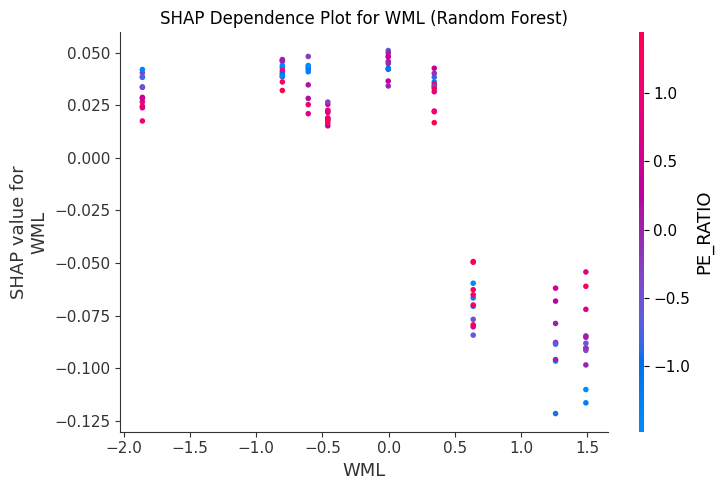

Plotting dependence for: FF_HML_CMA_PC2


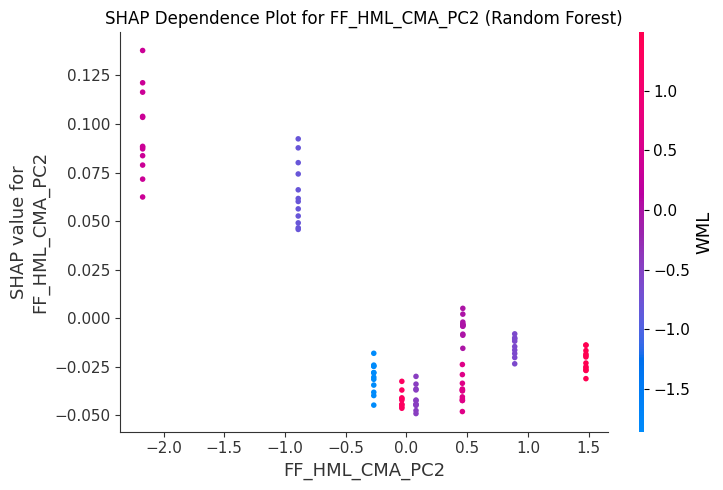


SHAP Summary Plot (XGBoost): Overall Feature Impact
DEBUG: XGB shap_values_xgb_positive final shape: (100, 48)
DEBUG: XGB X_shap_sample_df_xgb shape: (100, 48)


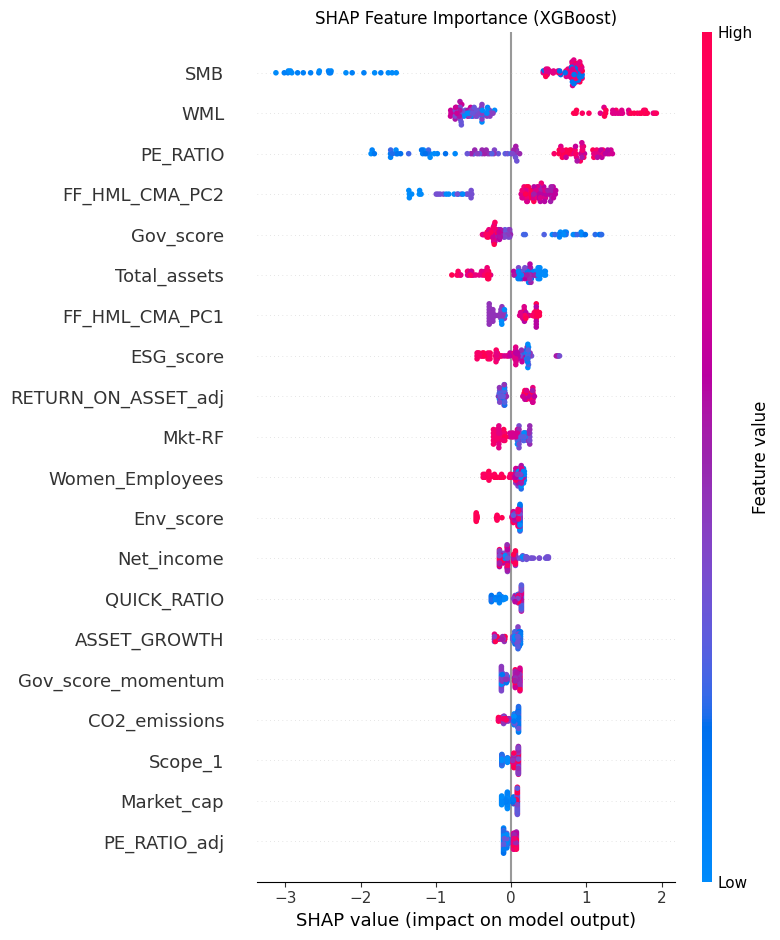


SHAP Dependence Plot (XGBoost): Non-Linearity for ESG_score
Plotting dependence for: SMB


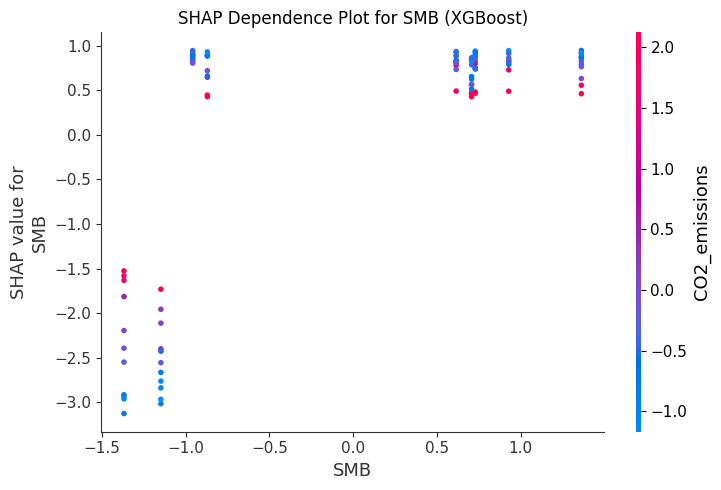

Plotting dependence for: Env_score


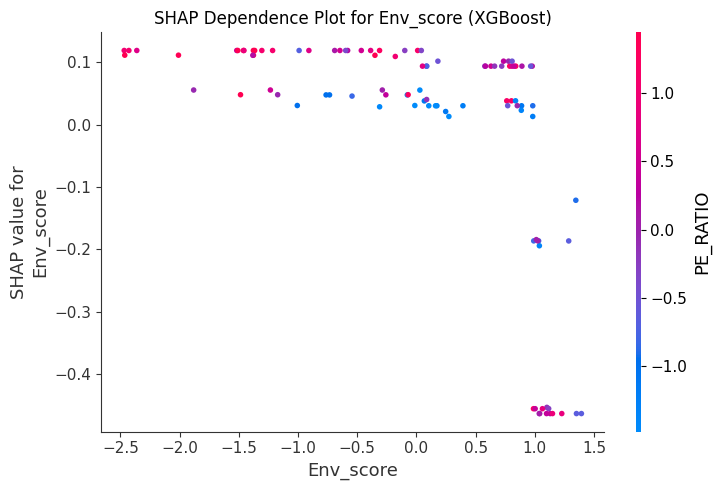

Plotting dependence for: PE_RATIO


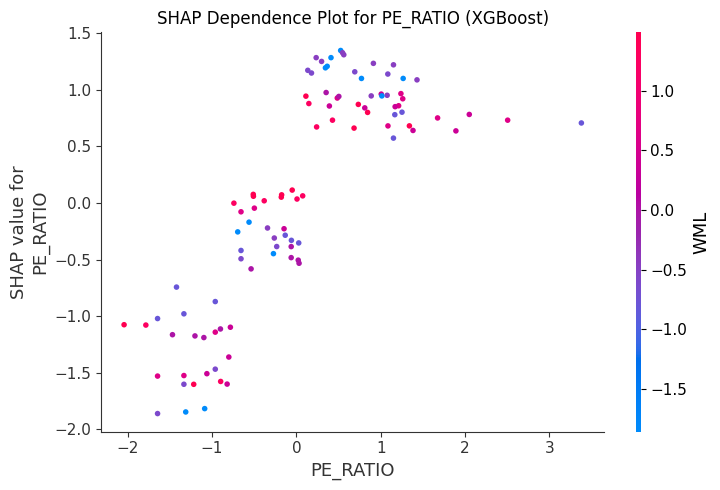


Skipping Machine Learning Analysis: Not enough unique firms for Grouped Cross-Validation.

--- Analysis Complete ---


In [13]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller, grangercausalitytests
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan
import warnings
import sys # For sys.exit()

# Suppress specific warnings for cleaner output during demonstrations
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=pd.errors.SettingWithCopyWarning)

# --- CRITICAL: Ensure linearmodels, arch, xgboost, and shap are up to date ---
# If running in Google Colab or similar environment, execute these lines
# before running the script/notebook to avoid version-related errors.
# !pip install --upgrade linearmodels arch xgboost shap matplotlib seaborn scikit-learn
# --- End of upgrade commands ---

# Enable experimental iterative imputer for MICE
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler
from linearmodels.panel import PanelOLS, RandomEffects, PooledOLS
from sklearn.decomposition import PCA # For Principal Component Analysis

# --- ML Specific Imports ---
from sklearn.ensemble import RandomForestClassifier # Changed to Classifier
from xgboost import XGBClassifier # Changed to Classifier
from sklearn.model_selection import GroupKFold, GridSearchCV # Added GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve # Classification metrics
import shap # For model interpretability
import matplotlib.pyplot as plt # For plotting
import seaborn as sns # For nicer plots


# --- 1. Load and Preprocess Data (Re-using your existing data loading and preprocessing) ---

# Load Fama-French 5 Factors data
try:
    # --- UPDATED ESG DATA FILE PATH HERE ---
    ff_df = pd.read_csv('/content/ff_5_Factors.csv')
    esg_df = pd.read_csv('/content/Transport_esg_dataset.csv') # Changed from Services_Sector_esg_dataset.csv
except FileNotFoundError:
    print("Ensure 'ff_5_Factors.csv' and 'Transport_esg_dataset.csv' are in the correct path.")
    sys.exit(1) # Exit if files are not found

print("--- Data Loading Complete ---")
print("Fama-French Data Head:\n", ff_df.head())
print("\nESG Data Head:\n", esg_df.head())

# --- Fama-French Data Preprocessing ---
ff_df['Date'] = pd.to_datetime(ff_df['Date'], format='%Y%m')
ff_df['Year'] = ff_df['Date'].dt.year
ff_df['Year'] = ff_df['Year'].astype(int)

# Use intersection to handle cases where 'WML' might be missing in a 5-factor file
all_possible_factor_cols = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF', 'WML']
factor_cols = list(set(all_possible_factor_cols).intersection(ff_df.columns))

# Ensure 'RF' is always included if available for annual aggregation mean
if 'RF' in ff_df.columns:
    non_rf_factor_cols = [col for col in factor_cols if col != 'RF']
else:
    non_rf_factor_cols = factor_cols # No RF column

# Assuming FF factors in input are already percentages (e.g., 5.61 for 5.61%)
# Convert them to decimal (e.g., 0.0561) for compounding calculations.
for col in non_rf_factor_cols:
    if col in ff_df.columns and ff_df[col].dtype in ['float64', 'int64'] and ff_df[col].max() > 1: # Heuristic: if max > 1, assume percentage
        ff_df[col] = ff_df[col] / 100.0

# Compound monthly returns to annual returns for factors (except RF)
ff_annual = ff_df.groupby('Year')[non_rf_factor_cols].apply(lambda x: (1 + x).prod() - 1, include_groups=False).reset_index()

# For RF, take the mean as it's typically risk-free rate, not compounded return for the period.
# RF should also be in decimal for correct subtraction.
if 'RF' in ff_df.columns:
    ff_annual['RF'] = ff_df.groupby('Year')['RF'].mean().reset_index(drop=True)

ff_annual['Year'] = ff_annual['Year'].astype(int)


# --- ESG Data Preprocessing ---
esg_df.rename(columns={'Date': 'Year'}, inplace=True)
esg_df['Year'] = pd.to_numeric(esg_df['Year'], errors='coerce').astype(pd.Int64Dtype())
esg_df.dropna(subset=['Identifier (RIC)', 'Year'], inplace=True)

if 'Industry' not in esg_df.columns:
    print("Warning: 'Industry' column not found in ESG data. Cannot perform industry-adjusted feature engineering.")

numeric_cols_esg = ['ESG_score', 'Social_score', 'Gov_score', 'Env_score', 'BVPS', 'Market_cap', 'Shares',
                    'Net_income', 'RETURN_ON_ASSET', 'QUICK_RATIO', 'ASSET_GROWTH', 'FNCL_LVRG',
                    'PE_RATIO', 'Scope_1', 'Scope_2', 'CO2_emissions', 'Energy_use', 'Water_use',
                    'Water_recycle', 'Toxic_chem_red', 'Injury_rate', 'Women_Employees',
                    'Human_Rights', 'Strikes', 'Turnover_empl', 'Board_Size',
                    'Shareholder_Rights', 'Board_gen_div', 'Bribery', 'Recycling_Initiatives', 'Total_assets']

for col in numeric_cols_esg:
    if col in esg_df.columns:
        esg_df[col] = pd.to_numeric(esg_df[col], errors='coerce')

# --- FIX: Assume RETURN_ON_ASSET in input is already percentage (e.g., 23.36) ---
# Do NOT divide by 100 here if it's already percentage.
# If your raw data for RETURN_ON_ASSET is truly in big numbers (e.g., 2336 for 23.36%), then this line is needed:
# if 'RETURN_ON_ASSET' in esg_df.columns and esg_df['RETURN_ON_ASSET'].max() > 1000: # Heuristic to detect huge numbers
#     esg_df['RETURN_ON_ASSET'] = esg_df['RETURN_ON_ASSET'] / 100.0 # Scale to percentage
# For now, let's assume it's already percentage like 23.36 in the input.

print(f"\nESG Years (unique, type {esg_df['Year'].dtype}): {sorted(esg_df['Year'].dropna().unique())}")
print(f"FF Annual Years (unique, type {ff_annual['Year'].dtype}): {sorted(ff_annual['Year'].unique())}")


# --- Merge Dataframes ---
rf_for_merge = ff_annual[['Year', 'RF']].copy() if 'RF' in ff_annual.columns else pd.DataFrame(columns=['Year', 'RF'])
esg_df_merged = pd.merge(esg_df, rf_for_merge, on='Year', how='left')

# --- FIX: Calculate Excess Return of the Firm ---
# Assuming RETURN_ON_ASSET is in percentage (e.g., 23.36%)
# Assuming RF from ff_annual is in decimal (e.g., 0.000833)
# To get Excess_Return_Firm in percentage (e.g., 23.35%), RF needs to be scaled up before subtraction.
if 'RETURN_ON_ASSET' in esg_df_merged.columns and 'RF' in esg_df_merged.columns:
    esg_df_merged['Excess_Return_Firm'] = esg_df_merged['RETURN_ON_ASSET'] - (esg_df_merged['RF'] * 100.0) # RF in percentage for subtraction
else:
    print("Warning: 'Excess_Return_Firm' cannot be calculated. Ensure 'RETURN_ON_ASSET' and 'RF' are available.")
    esg_df_merged['Excess_Return_Firm'] = np.nan

# Final merge with all FF factors
final_df = pd.merge(esg_df_merged, ff_annual.drop(columns=['RF'], errors='ignore'), on='Year', how='left')

# --- Data Scaling: Convert FF factors to Percentage for consistency with Excess_Return_Firm ---
# FF factors from ff_annual are currently in decimal (0.0x) after compounding.
# Convert them to percentage (X.XX) to match Excess_Return_Firm.
ff_factors_to_scale_to_percent = [col for col in non_rf_factor_cols if col in final_df.columns and col != 'RF']
for col in ff_factors_to_scale_to_percent:
    final_df[col] = final_df[col] * 100.0


print("\n--- Merged Data Head (ESG and Fama-French) ---\n", final_df.head())
print("\nMissing values before imputation (in final_df):\n", final_df.isnull().sum()[final_df.isnull().sum() > 0])


# --- 2. MICE Imputation ---
cols_for_imputation = [
    'ESG_score', 'Social_score', 'Gov_score', 'Env_score',
    'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'WML',
    'BVPS', 'Market_cap', 'Shares', 'Net_income', 'RETURN_ON_ASSET',
    'QUICK_RATIO', 'ASSET_GROWTH', 'FNCL_LVRG', 'PE_RATIO', 'Total_assets',
    'RF', 'Excess_Return_Firm', 'Scope_1', 'Scope_2', 'CO2_emissions', 'Energy_use',
    'Water_use', 'Water_recycle', 'Toxic_chem_red', 'Injury_rate', 'Women_Employees',
    'Human_Rights', 'Strikes', 'Turnover_empl', 'Board_Size',
    'Shareholder_Rights', 'Board_gen_div', 'Bribery', 'Recycling_Initiatives'
]
cols_for_imputation = [col for col in cols_for_imputation if col in final_df.columns]

imputable_df = final_df[cols_for_imputation]
threshold = 0.8
cols_to_drop_from_imputation = [col for col in imputable_df.columns if imputable_df[col].isnull().sum() / len(imputable_df) > threshold]
imputable_df_clean = imputable_df.drop(columns=cols_to_drop_from_imputation)

if not imputable_df_clean.empty and len(imputable_df_clean.columns) > 0:
    imputer = IterativeImputer(max_iter=10, random_state=0)
    imputed_data = imputer.fit_transform(imputable_df_clean)
    imputed_df = pd.DataFrame(imputed_data, columns=imputable_df_clean.columns, index=imputable_df_clean.index)

    for col in imputed_df.columns:
        final_df[col] = imputed_df[col]
else:
    print("\nWarning: No suitable numerical columns found for MICE imputation or imputable_df_clean is empty.")


# Handle remaining NaNs after MICE (ffill/bfill for panel, then mean/median)
final_df = final_df.set_index(['Identifier (RIC)', 'Year']).sort_index()
final_df = final_df.groupby(level='Identifier (RIC)').ffill().bfill()

for col in final_df.columns:
    if final_df[col].isnull().any():
        if pd.api.types.is_numeric_dtype(final_df[col]):
            final_df[col] = final_df[col].fillna(final_df[col].mean())
        else:
            final_df[col] = final_df[col].fillna(final_df[col].mode()[0] if not final_df[col].mode().empty else 'Unknown')

print("\n--- Missing values after MICE and ffill/bfill (before final model-specific drop) ---\n", final_df.isnull().sum()[final_df.isnull().sum() > 0])

dependent_var = 'Excess_Return_Firm'
all_panel_independent_options = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'WML',
                                 'ESG_score', 'Social_score', 'Gov_score', 'Env_score']
available_for_final_drop = [col for col in all_panel_independent_options if col in final_df.columns and not final_df[col].isnull().all()]

all_vars_for_final_drop = [dependent_var] + available_for_final_drop
if 'Market_cap' in final_df.columns:
    all_vars_for_final_drop.append('Market_cap')
if 'Industry' in final_df.columns:
    all_vars_for_final_drop.append('Industry')

for col in all_vars_for_final_drop:
    if col == 'Industry':
        if not pd.api.types.is_numeric_dtype(final_df[col]):
            final_df[col] = final_df[col].astype('category')
    else:
        final_df[col] = pd.to_numeric(final_df[col], errors='coerce')


initial_rows_count = len(final_df)
final_df.dropna(subset=[col for col in all_vars_for_final_drop if col != 'Industry'], inplace=True)
dropped_rows_count = initial_rows_count - len(final_df)
print(f"\nDropped {dropped_rows_count} rows due to NaNs in essential model-specific columns (excluding Industry if categorical).")

print("\nFinal Data Head after Preprocessing and Imputation (ready for models):\n", final_df.head())
print("Shape of final_df:", final_df.shape)

if final_df.empty:
    raise ValueError("DataFrame is empty after critical NaN handling for model-specific columns. Cannot proceed with analysis.")


# --- Implement Recommendations (Continue from previous code) ---

# Recommendation 1: Refine ESG Factor Construction
if 'Market_cap' in final_df.columns and 'ESG_score' in final_df.columns:
    vw_esg_df = final_df.reset_index().copy()
    vw_esg_df['Market_cap_weighted_ESG'] = vw_esg_df['ESG_score'] * vw_esg_df['Market_cap']
    market_esg_factor_vw = vw_esg_df.groupby('Year').apply(lambda x: x['Market_cap_weighted_ESG'].sum() / x['Market_cap'].sum(), include_groups=False)\
                                    .rename('Market_ESG_Factor_VW').reset_index()
    print("\n--- Value-weighted Market ESG Factor Head ---\n", market_esg_factor_vw.head())
else:
    print("\nWarning: Skipping Value-weighted Market ESG Factor calculation. 'Market_cap' or 'ESG_score' not found.")
    market_esg_factor_vw = pd.DataFrame(columns=['Year', 'Market_ESG_Factor_VW'])


esg_sub_scores = ['ESG_score', 'Social_score', 'Gov_score', 'Env_score']
esg_sub_scores_for_pca = [col for col in esg_sub_scores if col in final_df.columns and final_df[col].std() > 0]
if len(esg_sub_scores_for_pca) >= 2:
    print(f"\n--- Performing PCA on firm-level ESG sub-scores: {esg_sub_scores_for_pca} ---")
    pca_esg_data = final_df[esg_sub_scores_for_pca].copy()

    scaler_esg_pca = StandardScaler()
    scaled_esg_data = scaler_esg_pca.fit_transform(pca_esg_data)

    pca_esg = PCA(n_components=1)
    final_df['ESG_PC1'] = pca_esg.fit_transform(scaled_esg_data)
    print(f"Explained variance ratio of ESG_PC1: {pca_esg.explained_variance_ratio_[0]:.4f}")
else:
    print(f"\nSkipping PCA for ESG sub-scores: Not enough suitable columns (needs >=2 non-constant columns). Available: {esg_sub_scores_for_pca}")
    if 'ESG_score' in final_df.columns:
        final_df['ESG_PC1'] = final_df['ESG_score']
    else:
        final_df['ESG_PC1'] = np.nan


# Recommendation 2: Address Multicollinearity (HML and CMA)
ff_factors_for_pca = ['HML', 'CMA']
ff_factors_for_pca_clean = [col for col in ff_factors_for_pca if col in final_df.columns and final_df[col].std() > 0]

if len(ff_factors_for_pca_clean) >= 2:
    print(f"\n--- Performing PCA on Fama-French factors for multicollinearity: {ff_factors_for_pca_clean} ---")
    ff_pca_components = 2
    pca_ff_data = final_df[ff_factors_for_pca_clean].copy()

    scaler_ff_pca = StandardScaler()
    scaled_ff_data = scaler_ff_pca.fit_transform(pca_ff_data)

    pca_ff = PCA(n_components=min(ff_pca_components, len(ff_factors_for_pca_clean)))
    ff_pcs = pca_ff.fit_transform(scaled_ff_data)

    final_df['FF_HML_CMA_PC1'] = ff_pcs[:, 0]
    if ff_pcs.shape[1] > 1:
        final_df['FF_HML_CMA_PC2'] = ff_pcs[:, 1]
        print(f"Explained variance ratios for FF_HML_CMA_PC1: {pca_ff.explained_variance_ratio_[0]:.4f}, FF_HML_CMA_PC2: {pca_ff.explained_variance_ratio_[1]:.4f}")
    else:
        print(f"Only one principal component extracted for FF HML/CMA.")
        final_df['FF_HML_CMA_PC2'] = np.nan

    print(f"Note: {pca_ff.explained_variance_ratio_[0]*100:.2f}% explained variance by PC1 indicates extreme collinearity between HML and CMA.")
    print("This implies they convey almost identical information, and one could potentially be dropped without PCA.")

    print("\n--- VIF Check with PCA-derived HML/CMA factors ---")
    independent_vars_panel_pca_ff = ['Mkt-RF', 'SMB', 'RMW', 'WML', 'FF_HML_CMA_PC1']
    if 'FF_HML_CMA_PC2' in final_df.columns:
        independent_vars_panel_pca_ff.append('FF_HML_CMA_PC2')
    if 'ESG_score' in final_df.columns:
        independent_vars_panel_pca_ff.append('ESG_score')

    vif_features_clean = [col for col in independent_vars_panel_pca_ff if col in final_df.columns and final_df[col].std() > 0]

    if len(vif_features_clean) > 0:
        X_vif_pca_ff = final_df[vif_features_clean].copy()
        X_vif_pca_ff_with_const = sm.add_constant(X_vif_pca_ff, has_constant='add')

        scaler_vif = StandardScaler()
        X_vif_pca_ff_scaled_values = scaler_vif.fit_transform(X_vif_pca_ff_with_const)
        X_vif_pca_ff_scaled_df = pd.DataFrame(X_vif_pca_ff_scaled_values, columns=X_vif_pca_ff_with_const.columns, index=X_vif_pca_ff_with_const.index)

        try:
            vif_data_pca_ff = pd.DataFrame()
            vif_data_pca_ff["feature"] = X_vif_pca_ff_scaled_df.columns
            vif_data_pca_ff["VIF"] = [variance_inflation_factor(X_vif_pca_ff_scaled_df.values, i) for i in range(X_vif_pca_ff_scaled_df.shape[1])]
            vif_data_pca_ff = vif_data_pca_ff.loc[vif_data_pca_ff['feature'] != 'const']
            print(vif_data_pca_ff)
        except np.linalg.LinAlgError as e:
            print(f"Error calculating VIF: {e}. This might happen if there's perfect multicollinearity or too few observations relative to features.")
            print("Skipping VIF calculation.")
    else:
        print("Insufficient or problematic features available for VIF calculation.")

    independent_vars_panel = vif_features_clean
else:
    print("\nSkipping PCA for Fama-French HML/CMA: Not enough suitable columns. Using original factors but warning about multicollinearity.")
    independent_vars_panel = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'WML', 'ESG_score']
    independent_vars_panel = [col for col in independent_vars_panel if col in final_df.columns and final_df[col].std() > 0]

    print("\n--- VIF (Variance Inflation Factor) Check with ORIGINAL factors ---")
    if len(independent_vars_panel) > 0:
        X_vif = final_df[independent_vars_panel]
        X_vif_with_const = sm.add_constant(X_vif, has_constant='add')
        X_vif_scaled_values = StandardScaler().fit_transform(X_vif_with_const)
        X_vif_scaled_df = pd.DataFrame(X_vif_scaled_values, columns=X_vif_with_const.columns, index=X_vif_with_const.index)

        try:
            vif_data = pd.DataFrame()
            vif_data["feature"] = X_vif_scaled_df.columns
            vif_data["VIF"] = [variance_inflation_factor(X_vif_scaled_df.values, i) for i in range(X_vif_scaled_df.shape[1])]
            vif_data = vif_data.loc[vif_data['feature'] != 'const']
            print(vif_data)
            if 'HML' in vif_data['feature'].values and 'CMA' in vif_data['feature'].values:
                if vif_data.loc[vif_data['feature'] == 'HML', 'VIF'].iloc[0] > 5 or \
                   vif_data.loc[vif_data['feature'] == 'CMA', 'VIF'].iloc[0] > 5:
                    print("Warning: High VIF values for HML and/or CMA indicate severe multicollinearity.")
        except np.linalg.LinAlgError as e:
            print(f"Error calculating VIF: {e}. This might happen if there's perfect multicollinearity or too few observations relative to features.")
            print("Skipping VIF calculation.")
    else:
        print("Insufficient or problematic features available for VIF calculation.")


# --- 3. Panel Data Analysis (with Robust Standard Errors) ---
print("\n--- Panel Data Analysis (with Robust Standard Errors) ---")
print(f"Dependent Variable: {dependent_var}")
print(f"Independent Variables: {independent_vars_panel}")

pooled_res, fe_res, re_res = None, None, None

if not final_df.empty and len(independent_vars_panel) > 0 and final_df.shape[0] > len(independent_vars_panel):
    exog_panel_base = final_df[independent_vars_panel]
    exog_panel_base = exog_panel_base.loc[:, exog_panel_base.std() > 0]

    if exog_panel_base.empty:
        print("Skipping Panel Data Analysis: No independent variables with variance available.")
    elif final_df[dependent_var].isnull().all():
        print("Skipping Panel Data Analysis: Dependent variable is all NaN.")
    else:
        # Pooled OLS Model
        print("\n--- Pooled OLS Model (Robust Standard Errors) ---")
        try:
            exog_pooled = sm.add_constant(exog_panel_base)
            pooled_model = PooledOLS(final_df[dependent_var], exog_pooled)
            pooled_res = pooled_model.fit(cov_type='robust')
            print(pooled_res)
        except Exception as e:
            print(f"Error running Pooled OLS: {e}")

        # Fixed Effects (Within) Model
        print("\n--- Fixed Effects (Within) Model (Robust Standard Errors) ---")
        try:
            exog_fe = sm.add_constant(exog_panel_base)
            fe_model = PanelOLS(final_df[dependent_var], exog_fe, entity_effects=True)
            fe_res = fe_model.fit(cov_type='robust')
            print(fe_res)
        except Exception as e:
            print(f"Error running Fixed Effects Model: {e}")

        # Random Effects Model
        print("\n--- Random Effects Model (Robust Standard Errors) ---")
        try:
            re_model = RandomEffects(final_df[dependent_var], sm.add_constant(exog_panel_base))
            re_res = re_model.fit(cov_type='robust')
            print(re_res)
        except Exception as e:
            print(f"Error running Random Effects Model: {e}")


        print("\n--- Hausman Test (Fixed vs. Random Effects) ---")
        try:
            if fe_res is not None and re_res is not None:
                if hasattr(fe_res, 'compare') and callable(fe_res.compare):
                    try:
                        hausman_comparison = fe_res.compare(re_res)
                        if 'Hausman' in hausman_comparison.tests:
                            hausman_pvalue = hausman_comparison.tests['Hausman'].pvalue
                            hausman_stat = hausman_comparison.tests['Hausman'].stat
                            print(f"\nHausman Test Statistic: {hausman_stat:.2f}, P-value: {hausman_pvalue:.4f}")
                            if hausman_pvalue < 0.05:
                                print("Decision: Reject H0. Fixed Effects model is preferred.")
                            else:
                                print("Decision: Fail to reject H0. Random Effects model is preferred.")
                        else:
                            print("Hausman test results not found in the comparison object. This can happen with older linearmodels versions or certain model specifications.")
                            print("Please consider upgrading linearmodels: `!pip install --upgrade linearmodels`")
                    except Exception as inner_e:
                        print(f"An error occurred during Hausman test comparison: {inner_e}")
                        print("Please ensure your linearmodels library is updated: `!pip install --upgrade linearmodels`")
                else:
                    print("Hausman test comparison method may have changed (lacks .compare() method). Please update linearmodels to the latest version.")
                    print("Consider upgrading linearmodels: `!pip install --upgrade linearmodels`")
            else:
                print("Hausman test skipped: Fixed Effects or Random Effects models were not successfully fitted.")
        except Exception as e:
            print(f"An unexpected error occurred during Hausman Test: {e}.")

        print("\n--- F-Test (Pooled vs Fixed Effects) ---")
        if fe_res is not None and pooled_res is not None:
            try:
                if hasattr(fe_res, 'f_statistic_pooled'):
                    f_test_poolability = fe_res.f_statistic_pooled
                    print(f"F-statistic for Poolability: {f_test_poolability.stat:.3f}")
                    print(f"P-value: {f_test_poolability.pval:.4f}")
                    print(f"Distribution: F({f_test_poolability.df_num},{f_test_poolability.df_denom})")
                    if f_test_poolability.pval < 0.05:
                        print("Decision: Reject H0. Entity effects are jointly significant. Fixed Effects model is strongly preferred over Pooled OLS.")
                    else:
                        print("Decision: Fail to reject H0. Entity effects are not jointly significant. Pooled OLS might be preferred.")
                else:
                    print("f_statistic_pooled attribute not found. This might be due to linearmodels version or model specification.")
                    print("Falling back to overall F-test of Fixed Effects model.")
                    if hasattr(fe_res, 'f_statistic') and fe_res.f_statistic.pval < 0.05:
                        print(f"F-statistic for Fixed Effects overall model: {fe_res.f_statistic.stat:.2f} (p-value: {fe_res.f_statistic.pval:.4f})")
                        print("Decision based on overall FE F-test: Model is significant. Fixed Effects preferred over simple OLS (with a caveat that this is not a direct poolability test).")
                    else:
                        print(f"F-statistic for Fixed Effects overall model: {fe_res.f_statistic.stat:.2f} (p-value: {fe_res.f_statistic.pval:.4f})")
                        print("Decision based on overall FE F-test: Model is NOT significant. Pooled OLS might be preferred, but overall model fit is weak.")
            except Exception as e:
                print(f"Error performing F-test for Poolability: {e}")
        else:
            print("F-test skipped: Fixed Effects or Pooled OLS models were not successfully fitted.")


        # Recommendation 5 (Optional): Decompose ESG Score
        independent_vars_panel_decomposed_esg = ['Mkt-RF', 'SMB', 'RMW', 'WML', 'ESG_PC1', 'Social_score', 'Gov_score', 'Env_score']
        independent_vars_panel_decomposed_esg = [col for col in independent_vars_panel_decomposed_esg if col in final_df.columns and final_df[col].std() > 0]

        if len(independent_vars_panel_decomposed_esg) > 0 and final_df.shape[0] > len(independent_vars_panel_decomposed_esg):
            print("\n--- Panel Data Analysis with Decomposed ESG Factors (Robust Standard Errors) ---")
            print(f"Dependent Variable: {dependent_var}")
            print(f"Independent Variables: {independent_vars_panel_decomposed_esg}")

            try:
                exog_decomposed_esg_fe = sm.add_constant(final_df[independent_vars_panel_decomposed_esg])
                fe_decomposed_esg_model = PanelOLS(final_df[dependent_var], exog_decomposed_esg_fe, entity_effects=True)
                fe_decomposed_esg_res = fe_decomposed_esg_model.fit(cov_type='robust')
                print(fe_decomposed_esg_res)
            except Exception as e:
                print(f"Error running Fixed Effects Model with Decomposed ESG: {e}")
        else:
            print("\nSkipping Decomposed ESG Model: Not enough suitable decomposed ESG columns or no variation in them.")
else:
    print("\nSkipping all Panel Data Analysis models: Insufficient data or features after filtering essential columns.")


# --- 4. Vector Autoregression (VAR) / Vector Error Correction Model (VECM) ---
market_factors_var_base = ff_annual.set_index('Year')[['Mkt-RF', 'RF', 'SMB', 'HML', 'RMW', 'CMA', 'WML']].copy()
market_factors_var_base = market_factors_var_base[[col for col in market_factors_var_base.columns if col in ff_annual.columns]]

# Ensure market_esg_factor_vw is available and not empty before merging
if 'market_esg_factor_vw' in locals() and not market_esg_factor_vw.empty:
    var_df = pd.merge(market_factors_var_base, market_esg_factor_vw.set_index('Year'), on='Year', how='inner')

    var_data = var_df[['Mkt-RF', 'Market_ESG_Factor_VW']].copy()
    var_data.dropna(inplace=True)
    var_data = var_data.loc[:, var_data.std() > 0] # Filter columns with no variance


    print("\n--- VAR / VECM Analysis (Using Market-Level Time Series) ---")
    print("VAR Data Head:\n", var_data.head())

    print("\n--- ADF (Augmented Dickey-Fuller) Tests for Stationarity ---")
    if not var_data.empty and var_data.shape[1] >= 2:
        for col in var_data.columns:
            print(f"ADF Test for {col} (Levels):")
            if len(var_data[col].dropna()) > 1:
                adf_test_level = adfuller(var_data[col].dropna())
                print(f"  ADF Statistic: {adf_test_level[0]:.2f}")
                print(f"  P-value: {adf_test_level[1]:.4f}")
                print(f"  Critical Values (1%, 5%, 10%): {adf_test_level[4]}")
                if adf_test_level[1] < 0.05:
                    print(f"  Conclusion: {col} is likely stationary (I(0)).")
                else:
                    print(f"  Conclusion: {col} is likely non-stationary (I(1) or higher).")
                    diff_series = var_data[col].diff().dropna()
                    if not diff_series.empty and len(diff_series) > 1:
                        print(f"ADF Test for {col} (First Difference):")
                        adf_test_diff = adfuller(diff_series)
                        print(f"  ADF Statistic: {adf_test_diff[0]:.2f}")
                        print(f"  P-value: {adf_test_diff[1]:.4f}")
                        print(f"  Critical Values (1%, 5%, 10%): {adf_test_diff[4]}")
                        if adf_test_diff[1] < 0.05:
                            print(f"  Conclusion: {col} is likely stationary after first differencing (I(1)).")
                        else:
                            print(f"  Conclusion: {col} is likely non-stationary even after first differencing (I(2) or higher, or test lacks power).")
                            print("    Warning: VAR requires stationary series. Further differencing or other methods might be needed, but be cautious with limited data.")
                    else:
                        print(f"  Could not test differenced {col} due to insufficient data.")
            else:
                print(f"ADF Test for {col} (Levels): Insufficient non-NaN data points for ADF test ({len(var_data[col].dropna())} <= 1). Cannot determine stationarity.")
    else:
        print("VAR data is empty or has less than 2 columns. Skipping Stationarity Tests.")

    print("\n--- VAR Model Selection & Estimation ---")

    if not var_data.empty and 'Mkt-RF' in var_data.columns and 'Market_ESG_Factor_VW' in var_data.columns and var_data['Market_ESG_Factor_VW'].diff().dropna().shape[0] > 0:
        model_data_for_var = pd.DataFrame()
        model_data_for_var['Mkt-RF'] = var_data['Mkt-RF']
        model_data_for_var['Market_ESG_Factor_VW_diff'] = var_data['Market_ESG_Factor_VW'].diff()
        model_data_for_var.dropna(inplace=True)

        print("\nVAR model will use:")
        print("  - Mkt-RF (in levels, as it is stationary)")
        print("  - Market_ESG_Factor_VW (in first difference, assuming it becomes I(1))")
        print("  (Note: Sample size limits robustness of unit root tests and model estimation.)")

        results_var = None
        if len(model_data_for_var) > 5 and model_data_for_var.shape[1] > 1:
            model = VAR(model_data_for_var)
            try:
                calculated_maxlags = min(2, max(1, (len(model_data_for_var) // 2) - 1))
                if calculated_maxlags < 1:
                     calculated_maxlags = 1 if len(model_data_for_var) >= 3 else 0

                if calculated_maxlags > 0:
                    print(f"Fitting VAR model with maxlags={calculated_maxlags} using AIC.")
                    results_var = model.fit(maxlags=calculated_maxlags, ic='aic')
                    print(results_var.summary())

                    print("\n--- Granger Causality Tests (using original levels for conceptual test) ---")
                    if len(var_data) > 2 * calculated_maxlags and calculated_maxlags > 0:
                        gc_lag = calculated_maxlags
                        print(f"  (Using maxlag={gc_lag} for Granger tests)")

                        gc_mkt_esg = grangercausalitytests(var_data[['Mkt-RF', 'Market_ESG_Factor_VW']], maxlag=gc_lag, verbose=False)
                        for lag, test_results in gc_mkt_esg.items():
                            p_value = test_results[0]['ssr_ftest'][1]
                            print(f"  Does Mkt-RF Granger-cause Market_ESG_Factor_VW (Lag {lag})? p-value: {p_value:.4f}")
                            if p_value < 0.05:
                                print("    Yes, Mkt-RF likely Granger-causes Market_ESG_Factor_VW.")
                            else:
                                print("    No strong evidence that Mkt-RF Granger-causes Market_ESG_Factor_VW.")

                        gc_esg_mkt = grangercausalitytests(var_data[['Market_ESG_Factor_VW', 'Mkt-RF']], maxlag=gc_lag, verbose=False)
                        for lag, test_results in gc_esg_mkt.items():
                            p_value = test_results[0]['ssr_ftest'][1]
                            print(f"  Does Market_ESG_Factor_VW Granger-cause Mkt-RF (Lag {lag})? p-value: {p_value:.4f}")
                            if p_value < 0.05:
                                print("    Yes, Market_ESG_Factor_VW likely Granger-causes Mkt-RF.")
                            else:
                                print("    No strong evidence that Market_ESG_Factor_VW Granger-causes Mkt-RF.")
                    else:
                        print(f"VAR data is too short for Granger Causality tests at calculated maxlag={calculated_maxlags}.")
                        if calculated_maxlags == 0:
                            print("  Maxlag is 0, Granger Causality test requires at least lag 1.")


                    print("\n--- Homoskedasticity Test (Breusch-Pagan) on VAR Residuals ---")
                    for i, col_name in enumerate(model_data_for_var.columns):
                        resid = results_var.resid.iloc[:, i].dropna()
                        exog_bp = sm.add_constant(results_var.fittedvalues.loc[resid.index].iloc[:,i:i+1])

                        if exog_bp.empty or resid.empty or exog_bp.shape[0] != resid.shape[0] or exog_bp.shape[1] == 0:
                            print(f"    Could not perform Breusch-Pagan for {col_name}: Data mismatch or empty for BP test (shapes: resid={resid.shape}, exog={exog_bp.shape}).")
                            continue
                        try:
                            lm_stat, lm_p_value, f_stat, f_p_value = het_breuschpagan(resid, exog_bp)

                            print(f"  Breusch-Pagan Test for {col_name} residuals:")
                            print(f"    LM Statistic: {lm_stat:.2f}, P-value (LM): {lm_p_value:.4f}")
                            print(f"    F-Statistic: {f_stat:.2f}, P-value (F): {f_p_value:.4f}")
                            if lm_p_value < 0.05:
                                print(f"    Conclusion: Significant heteroskedasticity in {col_name} residuals (LM test).")
                            else:
                                print(f"    Conclusion: No significant heteroskedasticity in {col_name} residuals (LM test).")
                        except Exception as e:
                            print(f"    An unexpected error occurred during Breusch-Pagan for {col_name}: {e}")
                else:
                    print(f"Cannot fit VAR model with maxlags=0, skipping. Requires at least 3 observations for lag 1.")

            except Exception as e:
                print(f"Error fitting VAR model: {e}")
        else:
            print(f"Not enough data points ({len(model_data_for_var)}) for VAR model estimation. Requires >5 observations and 2+ variables with variance.")
    else:
        print("VAR data is empty or missing essential columns. Skipping VAR analysis.")
else:
    print("VAR/VECM Analysis skipped: Market ESG Factor not calculated or is empty.")


# --- 5. GARCH (Generalized Autoregressive Conditional Heteroskedasticity) Models ---
try:
    from arch import arch_model
    print("\n--- GARCH Models (for Market Excess Returns) ---")

    if 'Mkt-RF' in var_df.columns: # Assuming var_df comes from earlier VAR preparation
        garch_data = var_df['Mkt-RF'].dropna()

        if len(garch_data) >= 10:
            am = arch_model(garch_data, vol='Garch', p=1, q=1, rescale=False)
            res_garch = am.fit(disp='off')
            print(res_garch.summary())

            print("\n--- Basic GARCH(1,1) for Mkt-RF Volatility ---")
            print(res_garch.summary())
            print("Note: GARCH-M extends this by adding conditional variance/std dev to the mean equation.")
            print("Factor-GARCH models could incorporate FF factors as exogenous regressors (e.g., Mkt-RF in mean equation).")
            print("Robust GARCH estimation typically requires significantly more observations than available (e.g., hundreds or thousands of daily/monthly points).")

        else:
            print(f"Not enough data points ({len(garch_data)}) for GARCH model estimation. A minimum of 10 observations is used here for basic GARCH. For robust GARCH, more data is usually needed.")
    else:
        print("Skipping GARCH models: 'Mkt-RF' column not found in data for GARCH analysis.")

except ImportError:
    print("\nThe 'arch' library is required for GARCH models. Please install it: pip install arch")
except Exception as e:
    print(f"An error occurred during GARCH analysis: {e}")


# --- 6. Machine Learning Analysis (Random Forest & XGBoost) ---
print("\n--- 6. Machine Learning Analysis (Random Forest & XGBoost) ---")

# --- Feature Engineering ---
print("\n--- Feature Engineering for ML Models ---")
temp_df = final_df.reset_index()

# 1. ESG Momentum (Year-over-Year Change)
for esg_col in ['ESG_score', 'Social_score', 'Gov_score', 'Env_score', 'ESG_PC1']:
    if esg_col in temp_df.columns and pd.api.types.is_numeric_dtype(temp_df[esg_col]):
        temp_df[f'{esg_col}_momentum'] = temp_df.groupby('Identifier (RIC)')[esg_col].diff()
        print(f"  - Created {esg_col}_momentum")
    else:
        print(f"  Warning: Skipping momentum for '{esg_col}' as it is not in the DataFrame or not numeric.")


# 2. Industry-Adjusted Metrics (if 'Industry' column is available and valid)
industry_numeric_cols = ['ESG_score', 'Social_score', 'Gov_score', 'Env_score', 'ESG_PC1',
                         'Market_cap', 'RETURN_ON_ASSET', 'PE_RATIO', 'Total_assets']
industry_numeric_cols_clean = [col for col in industry_numeric_cols if col in temp_df.columns and pd.api.types.is_numeric_dtype(temp_df[col]) and temp_df[col].std() > 0]

if 'Industry' in temp_df.columns and not temp_df['Industry'].isnull().all():
    print("  - Calculating industry-adjusted features...")
    actual_industry_adj_features_created = []
    for col in industry_numeric_cols_clean:
        temp_df[f'{col}_industry_mean'] = temp_df.groupby(['Year', 'Industry'])[col].transform('mean')
        temp_df[f'{col}_adj'] = temp_df[col] - temp_df[f'{col}_industry_mean']
        actual_industry_adj_features_created.append(f'{col}_adj')
    print(f"    - Created {', '.join(actual_industry_adj_features_created)}")
else:
    print("  - Skipping industry-adjusted features: 'Industry' column not available or contains only NaNs.")

final_df_ml = temp_df.set_index(['Identifier (RIC)', 'Year']).sort_index()

final_df_ml['Excess_Return_Firm_next_year'] = final_df_ml.groupby(level='Identifier (RIC)')['Excess_Return_Firm'].shift(-1)
final_df_ml['Excess_Return_Firm_next_year_Direction'] = (final_df_ml['Excess_Return_Firm_next_year'] > 0).astype(int)

ml_features = [
    'Mkt-RF', 'SMB', 'RMW', 'WML',
    'ESG_score', 'Social_score', 'Gov_score', 'Env_score', 'ESG_PC1',
    'BVPS', 'Market_cap', 'Shares', 'Net_income',
    'QUICK_RATIO', 'ASSET_GROWTH', 'FNCL_LVRG', 'PE_RATIO', 'Total_assets',
    'Scope_1', 'Scope_2', 'CO2_emissions', 'Energy_use', 'Water_use',
    'Water_recycle', 'Toxic_chem_red', 'Injury_rate', 'Women_Employees',
    'Human_Rights', 'Strikes', 'Turnover_empl', 'Board_Size',
    'Shareholder_Rights', 'Board_gen_div', 'Bribery', 'Recycling_Initiatives'
]

if 'FF_HML_CMA_PC1' in final_df_ml.columns:
    ml_features.append('FF_HML_CMA_PC1')
if 'FF_HML_CMA_PC2' in final_df_ml.columns:
    ml_features.append('FF_HML_CMA_PC2')

for col in final_df_ml.columns:
    if '_momentum' in col or '_adj' in col:
        ml_features.append(col)

ml_features_clean = []
for col in ml_features:
    if col in final_df_ml.columns and pd.api.types.is_numeric_dtype(final_df_ml[col]) and not final_df_ml[col].isnull().all() and final_df_ml[col].std() > 1e-9:
        ml_features_clean.append(col)
    elif col == 'Industry' and 'Industry' in final_df_ml.columns:
        print("Note: 'Industry' column is categorical and was excluded from numerical features. Consider one-hot encoding if needed.")


if len(ml_features_clean) == 0:
    print("Error: No numeric features available for ML after cleaning. Please check 'ml_features' list and data types.")
    sys.exit(1)


ml_df = final_df_ml.dropna(subset=['Excess_Return_Firm_next_year_Direction'] + ml_features_clean).copy()

X_ml = ml_df[ml_features_clean]
y_ml = ml_df['Excess_Return_Firm_next_year_Direction']
groups_ml = ml_df.index.get_level_values('Identifier (RIC)')

print(f"\nML Data Shape (for predicting next year's return direction): {X_ml.shape}")
print(f"Number of unique firms for ML: {len(groups_ml.unique())}")
print(f"Years covered by ML data: {ml_df.index.get_level_values('Year').min()} - {ml_df.index.get_level_values('Year').max()}")
print(f"Class distribution (0=negative/zero, 1=positive returns): \n{y_ml.value_counts(normalize=True)}")

# --- CRITICAL WARNING: Small sample size for ML ---
num_unique_firms_ml = len(groups_ml.unique())
if X_ml.empty or y_ml.empty or num_unique_firms_ml < 2 or y_ml.nunique() < 2:
    print("Not enough data or firms for robust ML analysis after lagging, feature engineering, and dropping NaNs. Skipping ML section.")
else:
    print(f"\n--- CRITICAL WARNING: SMALL NUMBER OF UNIQUE FIRMS FOR ML ({num_unique_firms_ml} firms) ---")
    print("Machine Learning models are being trained on data from a very limited number of unique firms.")
    print("This severely limits the generalizability of the models and increases the risk of overfitting to specific firm characteristics.")
    print("Results should be considered exploratory and not suitable for drawing robust, generalizable conclusions.")
    print("-" * 80)

    scaler_ml = StandardScaler()
    X_scaled_ml = scaler_ml.fit_transform(X_ml)
    X_scaled_ml_df = pd.DataFrame(X_scaled_ml, columns=X_ml.columns, index=X_ml.index)

    n_splits = min(5, num_unique_firms_ml)

    if n_splits < 2:
        print(f"Warning: Not enough unique firms ({num_unique_firms_ml}) for robust GroupKFold (min 2 splits).")
        print("Skipping full ML model training and interpretation due to insufficient unique firms for Grouped Cross-Validation.")
        print("For more robust results, ensure you have more unique 'Identifier (RIC)' values in your data.")
    else:
        gkf = GroupKFold(n_splits=n_splits)
        print(f"\nPerforming {n_splits}-fold Grouped Cross-Validation with Hyperparameter Tuning...")

        param_grid_rf = {
            'n_estimators': [50, 100],
            'max_depth': [5, 10],
            'min_samples_split': [2, 5]
        }
        param_grid_xgb = {
            'n_estimators': [50, 100],
            'max_depth': [3, 5],
            'learning_rate': [0.1, 0.05],
            'use_label_encoder': [False],
            'eval_metric': ['logloss']
        }

        print("\n--- Tuning Random Forest Classifier ---")
        grid_search_rf = GridSearchCV(RandomForestClassifier(random_state=42, class_weight='balanced'), param_grid_rf, cv=gkf, scoring='roc_auc', n_jobs=-1, verbose=1)
        try:
            grid_search_rf.fit(X_scaled_ml_df, y_ml, groups=groups_ml)
            best_rf_model = grid_search_rf.best_estimator_
            print(f"Best Random Forest Parameters: {grid_search_rf.best_params_}")
            print(f"Best Random Forest ROC AUC (CV): {grid_search_rf.best_score_:.4f}")
        except Exception as e:
            print(f"Error during Random Forest GridSearchCV: {e}")
            print("Skipping Random Forest analysis.")
            best_rf_model = None


        print("\n--- Tuning XGBoost Classifier ---")
        scale_pos_weight_val = (y_ml == 0).sum() / (y_ml == 1).sum() if (y_ml == 1).sum() > 0 else 1.0 # Handle division by zero if only one class
        grid_search_xgb = GridSearchCV(XGBClassifier(random_state=42, scale_pos_weight=scale_pos_weight_val), param_grid_xgb, cv=gkf, scoring='roc_auc', n_jobs=-1, verbose=1)
        try:
            grid_search_xgb.fit(X_scaled_ml_df, y_ml, groups=groups_ml)
            best_xgb_model = grid_search_xgb.best_estimator_
            print(f"Best XGBoost Parameters: {grid_search_xgb.best_params_}")
            print(f"Best XGBoost ROC AUC (CV): {grid_search_xgb.best_score_:.4f}")
        except Exception as e:
            print(f"Error during XGBoost GridSearchCV: {e}")
            print("Skipping XGBoost analysis.")
            best_xgb_model = None

        print("\n--- Evaluating Best Models on Cross-Validation ---")
        models = {}
        if best_rf_model: models['Random Forest (Tuned)'] = best_rf_model
        if best_xgb_model: models['XGBoost (Tuned)'] = best_xgb_model

        for name, model in models.items():
            all_y_test = []
            all_y_pred = []
            all_y_proba = []

            for fold, (train_idx, test_idx) in enumerate(gkf.split(X_scaled_ml_df, y_ml, groups_ml)):
                X_train, X_test = X_scaled_ml_df.iloc[train_idx], X_scaled_ml_df.iloc[test_idx]
                y_train, y_test = y_ml.iloc[train_idx], y_ml.iloc[test_idx]

                if X_train.empty or X_test.empty or y_train.empty or y_test.empty or y_train.nunique() < 2 or y_test.nunique() < 2:
                    print(f"Skipping fold {fold} for {name} due to insufficient classes or empty train/test split.")
                    continue

                try:
                    model.fit(X_train, y_train)
                    y_pred_fold = model.predict(X_test)
                    y_proba_fold = model.predict_proba(X_test)[:, 1]

                    all_y_test.extend(y_test)
                    all_y_pred.extend(y_pred_fold)
                    all_y_proba.extend(y_proba_fold)
                except Exception as e:
                    print(f"Error during fitting/predicting in fold {fold} for {name}: {e}")
                    continue

            if all_y_test:
                print(f"\n--- {name} Consolidated Cross-Validation Metrics ---")
                print(f"Accuracy: {accuracy_score(all_y_test, all_y_pred):.4f}")
                print(f"Precision: {precision_score(all_y_test, all_y_pred, zero_division=0):.4f}")
                print(f"Recall: {recall_score(all_y_test, all_y_pred, zero_division=0):.4f}")
                print(f"F1-Score: {f1_score(all_y_test, all_y_pred, zero_division=0):.4f}")
                print(f"ROC AUC: {roc_auc_score(all_y_test, all_y_proba):.4f}")

                cm = confusion_matrix(all_y_test, all_y_pred)
                plt.figure(figsize=(6, 5))
                sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
                plt.title(f'Confusion Matrix for {name}')
                plt.ylabel('Actual Label')
                plt.xlabel('Predicted Label')
                plt.show()

                fpr, tpr, _ = roc_curve(all_y_test, all_y_proba)
                plt.figure(figsize=(6, 5))
                plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc_score(all_y_test, all_y_proba):.2f})')
                plt.plot([0, 1], [0, 1], 'k--')
                plt.xlabel('False Positive Rate')
                plt.ylabel('True Positive Rate')
                plt.title(f'ROC Curve for {name}')
                plt.legend(loc='lower right')
                plt.show()

                print("\nFull Classification Report (Aggregated CV Predictions):")
                print(classification_report(all_y_test, all_y_pred, zero_division=0))
                print("Note on Imbalance: Precision/Recall/F1-score for minority class (0) are crucial.")
                print("Consider techniques like SMOTE or class weighting to address imbalance.")
                print("-" * 60)

            else:
                print(f"\n--- {name} Cross-Validation Results ---")
                print("Could not complete cross-validation due to insufficient data splits or empty test sets.")


        print("\n--- Feature Importance ---")
        print("Interpreting key drivers of next year's Excess Return Firm Direction.")

        if best_rf_model:
            final_rf_model = best_rf_model
            feature_importances_rf = pd.DataFrame({
                'feature': X_ml.columns,
                'importance': final_rf_model.feature_importances_
            }).sort_values(by='importance', ascending=False)
            print("\nTop 10 Feature Importances (Random Forest):")
            print(feature_importances_rf.head(10))
        else:
            print("\nRandom Forest model not trained, skipping feature importance.")

        if best_xgb_model:
            final_xgb_model = best_xgb_model
            feature_importances_xgb = pd.DataFrame({
                'feature': X_ml.columns,
                'importance': final_xgb_model.feature_importances_
            }).sort_values(by='importance', ascending=False)
            print("\nTop 10 Feature Importances (XGBoost):")
            print(feature_importances_xgb.head(10))
        else:
            print("\nXGBoost model not trained, skipping feature importance.")

        print("\n--- Model Interpretability (SHAP Values) ---")
        print("Understanding non-linear effects, interactions, and contextual dependence.")
        print("\n--- CRITICAL WARNING: SHAP plots for small sample sizes can be sparse or misleading. ---")
        print("Dependence plots especially may not show clear trends or interactions with limited data points.")
        print("Interpret these visualizations with extreme caution.")
        print("-" * 80)

        shap.initjs()

        if best_rf_model and not X_scaled_ml_df.empty:
            print("\nSHAP Summary Plot (Random Forest): Overall Feature Impact")
            try:
                sample_size_for_shap = min(100, X_scaled_ml_df.shape[0])
                np.random.seed(42)
                sampled_indices_rf = np.random.choice(X_scaled_ml_df.index, size=sample_size_for_shap, replace=False)
                X_shap_sample_df_rf = X_scaled_ml_df.loc[sampled_indices_rf]

                # Filter out columns with no variance for SHAP plotting robustness
                X_shap_sample_df_rf = X_shap_sample_df_rf.loc[:, X_shap_sample_df_rf.std() > 0]
                if X_shap_sample_df_rf.empty or X_shap_sample_df_rf.isnull().all().all():
                    print("Skipping SHAP for Random Forest: Sampled data is empty or all NaN/no variance after filtering.")
                else:
                    explainer_rf = shap.TreeExplainer(best_rf_model)
                    shap_values_rf = explainer_rf.shap_values(X_shap_sample_df_rf)

                    if isinstance(shap_values_rf, list) and len(shap_values_rf) > 1:
                        shap_values_rf_positive = shap_values_rf[1]
                    else:
                        shap_values_rf_positive = shap_values_rf

                    # FIX: Ensure shap_values_rf_positive is 2D if it's 3D
                    if shap_values_rf_positive.ndim == 3 and shap_values_rf_positive.shape[2] == 2: # This means it has an extra dimension for some reason
                        shap_values_rf_positive = shap_values_rf_positive[:, :, 0] # Take the first slice, usually
                        print("DEBUG: Corrected RF shap_values_rf_positive from 3D to 2D for dependence plot.")
                    elif shap_values_rf_positive.ndim != 2:
                        print(f"Warning: RF shap_values_rf_positive has unexpected dimensions: {shap_values_rf_positive.shape}. May cause issues.")

                    print(f"DEBUG: RF shap_values_rf_positive final shape: {shap_values_rf_positive.shape}")
                    print(f"DEBUG: RF X_shap_sample_df_rf shape: {X_shap_sample_df_rf.shape}")

                    shap.summary_plot(shap_values_rf_positive, X_shap_sample_df_rf, feature_names=X_shap_sample_df_rf.columns, show=False)
                    plt.title("SHAP Feature Importance (Random Forest)")
                    plt.tight_layout()
                    plt.show()

                    print("\nSHAP Dependence Plots (Random Forest): Non-Linearity & Interactions")
                    top_rf_features_for_plot = feature_importances_rf['feature'].head(3).tolist()
                    for feature_name in top_rf_features_for_plot:
                        if feature_name in X_shap_sample_df_rf.columns and pd.api.types.is_numeric_dtype(X_shap_sample_df_rf[feature_name]) and X_shap_sample_df_rf[feature_name].nunique() > 1:
                            print(f"Plotting dependence for: {feature_name}")
                            shap.dependence_plot(
                                ind=feature_name,
                                shap_values=shap_values_rf_positive,
                                features=X_shap_sample_df_rf,
                                feature_names=X_shap_sample_df_rf.columns,
                                interaction_index='auto',
                                show=False
                            )
                            plt.title(f"SHAP Dependence Plot for {feature_name} (Random Forest)")
                            plt.tight_layout()
                            plt.show()
                        else:
                            print(f"Skipping dependence plot for '{feature_name}': not in sample, not numeric, or no variation.")

            except Exception as e:
                print(f"Error during SHAP analysis for Random Forest: {e}")
                print("Consider using a smaller sample for SHAP or addressing memory issues if data is very large.")
                plt.close()
        else:
            print("\nSkipping SHAP analysis for Random Forest: Model not trained or data empty.")


        if best_xgb_model and not X_scaled_ml_df.empty:
            print("\nSHAP Summary Plot (XGBoost): Overall Feature Impact")
            try:
                sample_size_for_shap = min(100, X_scaled_ml_df.shape[0])
                np.random.seed(42)
                sampled_indices_xgb = np.random.choice(X_scaled_ml_df.index, size=sample_size_for_shap, replace=False)
                X_shap_sample_df_xgb = X_scaled_ml_df.loc[sampled_indices_xgb]

                # Filter out columns with no variance for SHAP plotting robustness
                X_shap_sample_df_xgb = X_shap_sample_df_xgb.loc[:, X_shap_sample_df_xgb.std() > 0]
                if X_shap_sample_df_xgb.empty or X_shap_sample_df_xgb.isnull().all().all():
                    print("Skipping SHAP for XGBoost: Sampled data is empty or all NaN/no variance after filtering.")
                else:
                    explainer_xgb = shap.TreeExplainer(best_xgb_model)
                    shap_values_xgb = explainer_xgb.shap_values(X_shap_sample_df_xgb)

                    if isinstance(shap_values_xgb, list) and len(shap_values_xgb) > 1:
                        shap_values_xgb_positive = shap_values_xgb[1]
                    else:
                        shap_values_xgb_positive = shap_values_xgb

                    if shap_values_xgb_positive.ndim != 2:
                        print(f"Warning: XGB shap_values_xgb_positive has unexpected dimensions: {shap_values_xgb_positive.shape}. May cause issues.")

                    print(f"DEBUG: XGB shap_values_xgb_positive final shape: {shap_values_xgb_positive.shape}")
                    print(f"DEBUG: XGB X_shap_sample_df_xgb shape: {X_shap_sample_df_xgb.shape}")

                    shap.summary_plot(shap_values_xgb_positive, X_shap_sample_df_xgb, feature_names=X_shap_sample_df_xgb.columns, show=False)
                    plt.title("SHAP Feature Importance (XGBoost)")
                    plt.tight_layout()
                    plt.show()

                    print("\nSHAP Dependence Plot (XGBoost): Non-Linearity for ESG_score")
                    top_xgb_features_for_plot = feature_importances_xgb['feature'].head(3).tolist()
                    for feature_name in top_xgb_features_for_plot:
                        if feature_name in X_shap_sample_df_xgb.columns and pd.api.types.is_numeric_dtype(X_shap_sample_df_xgb[feature_name]) and X_shap_sample_df_xgb[feature_name].nunique() > 1:
                            print(f"Plotting dependence for: {feature_name}")
                            shap.dependence_plot(
                                ind=feature_name,
                                shap_values=shap_values_xgb_positive,
                                features=X_shap_sample_df_xgb,
                                feature_names=X_shap_sample_df_xgb.columns,
                                interaction_index='auto',
                                show=False
                            )
                            plt.title(f"SHAP Dependence Plot for {feature_name} (XGBoost)")
                            plt.tight_layout()
                            plt.show()
                        else:
                            print(f"Skipping dependence plot for '{feature_name}': not in sample, not numeric, or no variation.")

            except Exception as e:
                print(f"Error during SHAP analysis for XGBoost: {e}")
                plt.close()
        else:
            print("\nSkipping SHAP analysis for XGBoost: Model not trained or data empty.")
#else:
    print("\nSkipping Machine Learning Analysis: Not enough unique firms for Grouped Cross-Validation.")

print("\n--- Analysis Complete ---")

--- Data Loading Complete ---
Fama-French Data Head:
      Date  Mkt-RF   SMB   HML   RMW   CMA    RF   WML
0  201201    5.61  1.99 -0.77 -2.01 -1.03  0.00 -6.77
1  201202    4.93 -0.87 -0.31 -0.41 -0.17  0.00 -2.62
2  201203    1.24 -0.20  0.04  0.46  1.21  0.00  3.58
3  201204   -1.11  0.25 -1.68  2.23 -0.12  0.00  4.86
4  201205   -8.88 -0.34  0.08  2.06  1.76  0.01  6.25

ESG Data Head:
   Identifier (RIC)                 Company Name  Date  ESG_score  \
0              AAL  American Airlines Group Inc  2021  59.029107   
1              AAL  American Airlines Group Inc  2020  69.401178   
2              AAL  American Airlines Group Inc  2019  69.369228   
3              AAL  American Airlines Group Inc  2018  71.633022   
4              AAL  American Airlines Group Inc  2017  69.791371   

   Social_score  Gov_score  Env_score       BVPS    Market_cap     Shares  \
0     64.286018  56.398116  54.385152 -11.397250  1.019831e+10  644015000   
1     68.814485  83.943615  56.966001 -14.

/usr/local/lib/python3.11/dist-packages/statsmodels/regression/linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


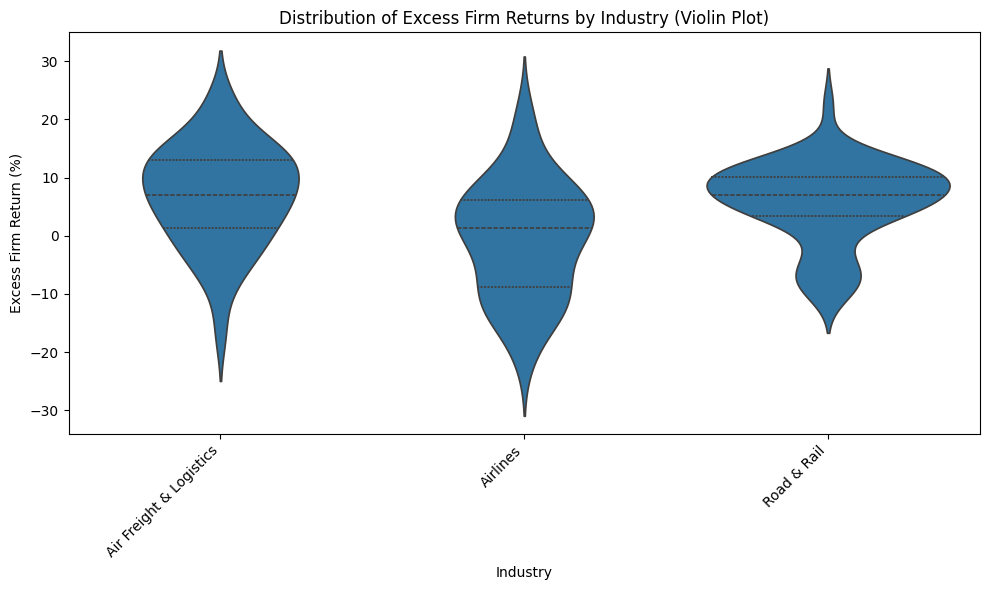

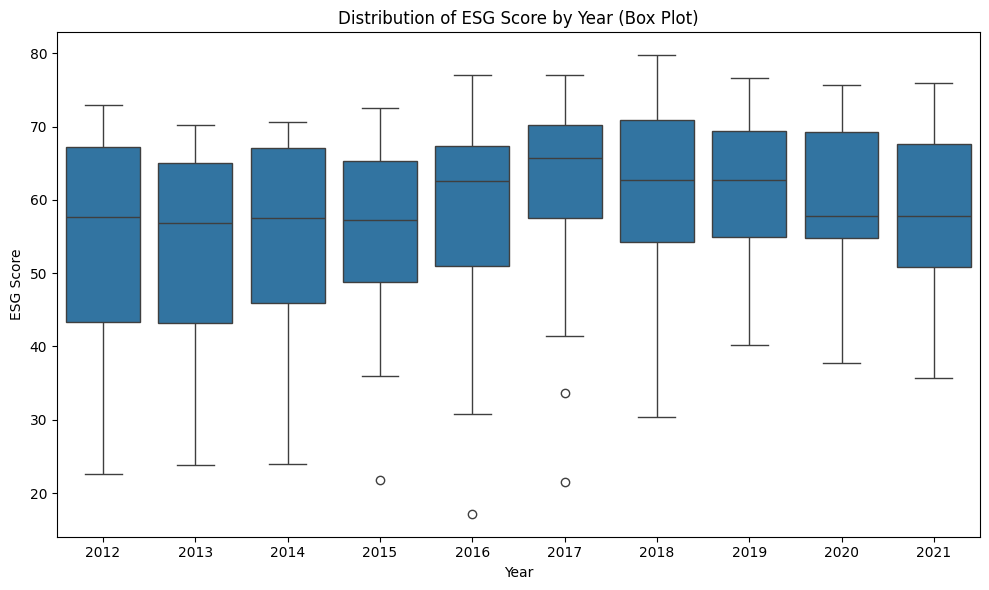


--- Panel Data Analysis (with Robust Standard Errors) ---
Dependent Variable: Excess_Return_Firm
Independent Variables: ['Mkt-RF', 'SMB', 'RMW', 'WML', 'FF_HML_CMA_PC1', 'FF_HML_CMA_PC2', 'ESG_score']

--- Pooled OLS Model (Robust Standard Errors) ---
                          PooledOLS Estimation Summary                          
Dep. Variable:     Excess_Return_Firm   R-squared:                        0.4987
Estimator:                  PooledOLS   R-squared (Between):              0.4222
No. Observations:                 140   R-squared (Within):               0.5242
Date:                Wed, Jun 04 2025   R-squared (Overall):              0.4987
Time:                        18:38:14   Log-likelihood                   -459.93
Cov. Estimator:                Robust                                           
                                        F-statistic:                      18.757
Entities:                          14   P-value                           0.0000
Avg Obs:          

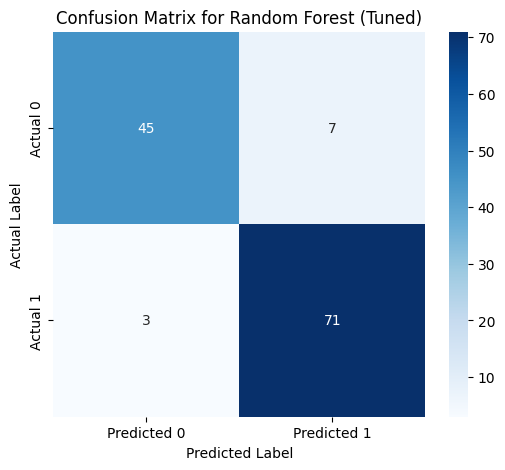

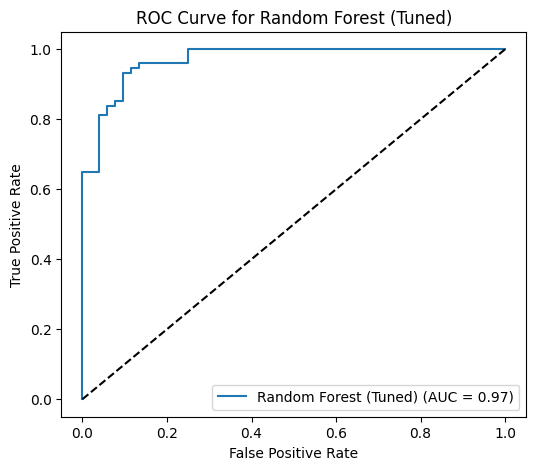


Full Classification Report (Aggregated CV Predictions):
              precision    recall  f1-score   support

           0       0.94      0.87      0.90        52
           1       0.91      0.96      0.93        74

    accuracy                           0.92       126
   macro avg       0.92      0.91      0.92       126
weighted avg       0.92      0.92      0.92       126

Note on Imbalance: Precision/Recall/F1-score for minority class (0) are crucial.
Consider techniques like SMOTE or class weighting to address imbalance.
------------------------------------------------------------

--- XGBoost (Tuned) Consolidated Cross-Validation Metrics ---
Accuracy: 0.8651
Precision: 0.8904
Recall: 0.8784
F1-Score: 0.8844
ROC AUC: 0.9592


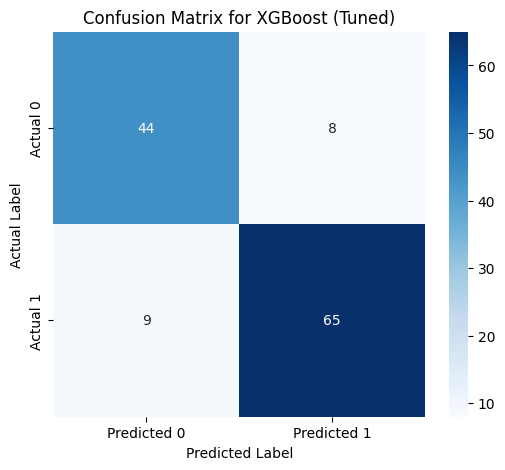

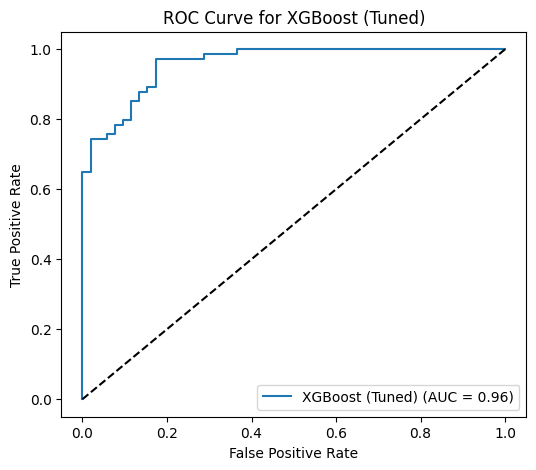


Full Classification Report (Aggregated CV Predictions):
              precision    recall  f1-score   support

           0       0.83      0.85      0.84        52
           1       0.89      0.88      0.88        74

    accuracy                           0.87       126
   macro avg       0.86      0.86      0.86       126
weighted avg       0.87      0.87      0.87       126

Note on Imbalance: Precision/Recall/F1-score for minority class (0) are crucial.
Consider techniques like SMOTE or class weighting to address imbalance.
------------------------------------------------------------

--- Feature Importance ---
Interpreting key drivers of next year's Excess Return Firm Direction.

Top 10 Feature Importances (Random Forest):
           feature  importance
1              SMB    0.121051
3              WML    0.084443
33  FF_HML_CMA_PC2    0.067076
0           Mkt-RF    0.055610
17    Total_assets    0.047995
16        PE_RATIO    0.037674
2              RMW    0.035845
9          


SHAP Summary Plot (Random Forest): Overall Feature Impact
DEBUG: Corrected RF shap_values_rf_positive from 3D to 2D for dependence plot.
DEBUG: RF shap_values_rf_positive final shape: (100, 48)
DEBUG: RF X_shap_sample_df_rf shape: (100, 48)


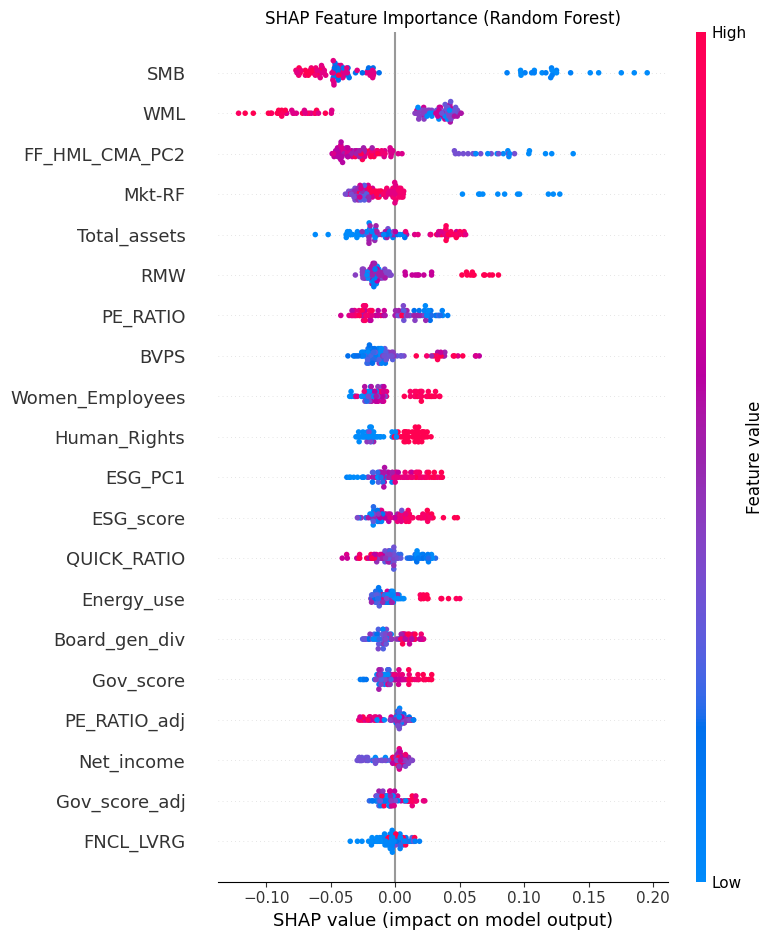


SHAP Dependence Plots (Random Forest): Non-Linearity & Interactions
Plotting dependence for: SMB


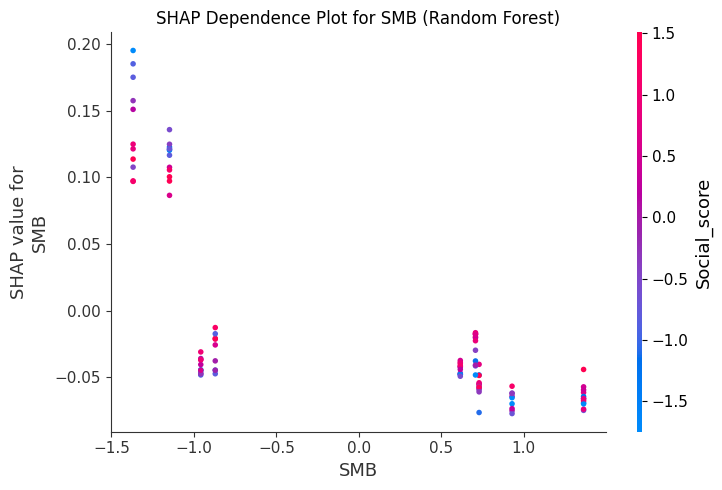

Plotting dependence for: WML


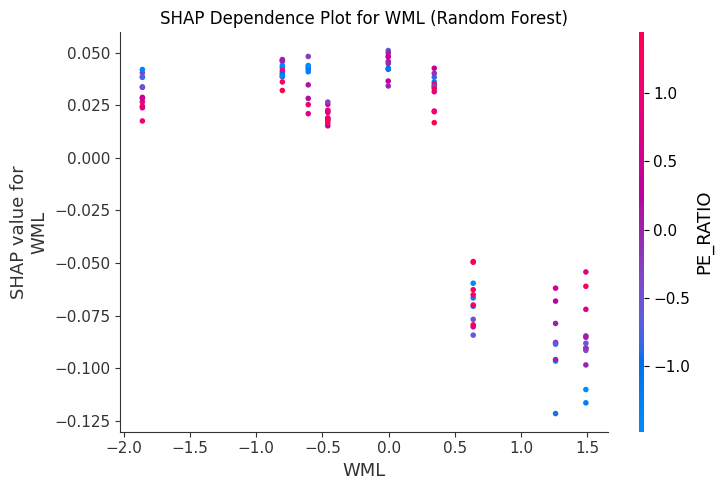

Plotting dependence for: FF_HML_CMA_PC2


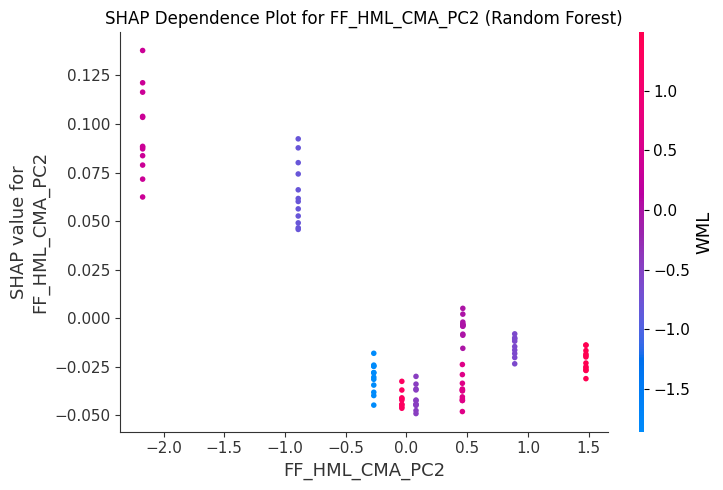


SHAP Summary Plot (XGBoost): Overall Feature Impact
DEBUG: XGB shap_values_xgb_positive final shape: (100, 48)
DEBUG: XGB X_shap_sample_df_xgb shape: (100, 48)


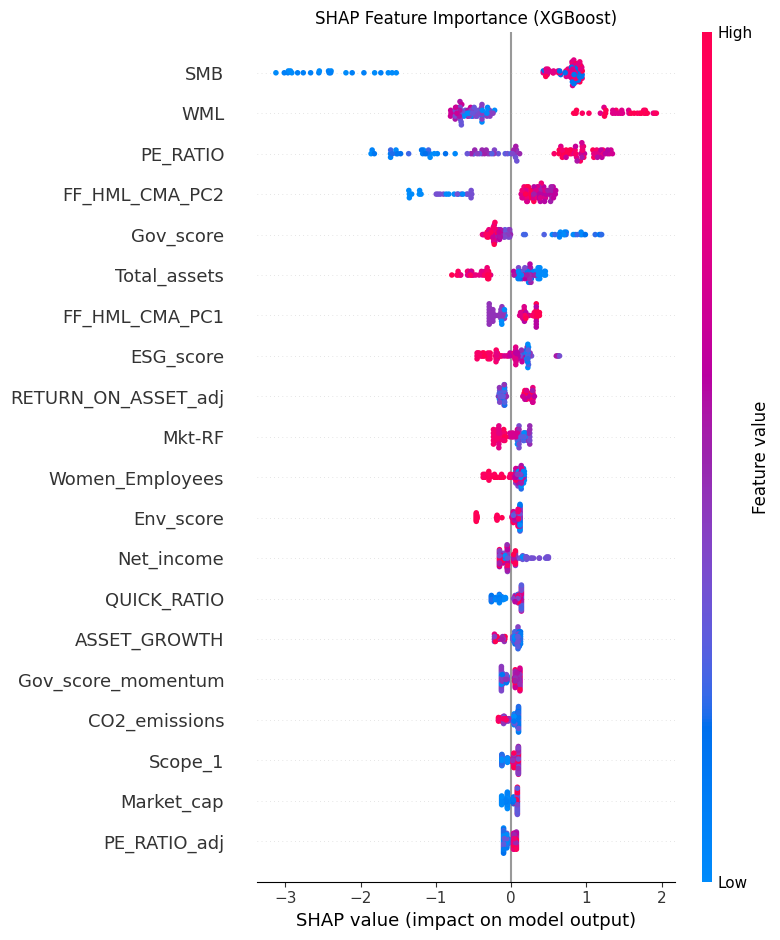


SHAP Dependence Plot (XGBoost): Non-Linearity for ESG_score
Plotting dependence for: SMB


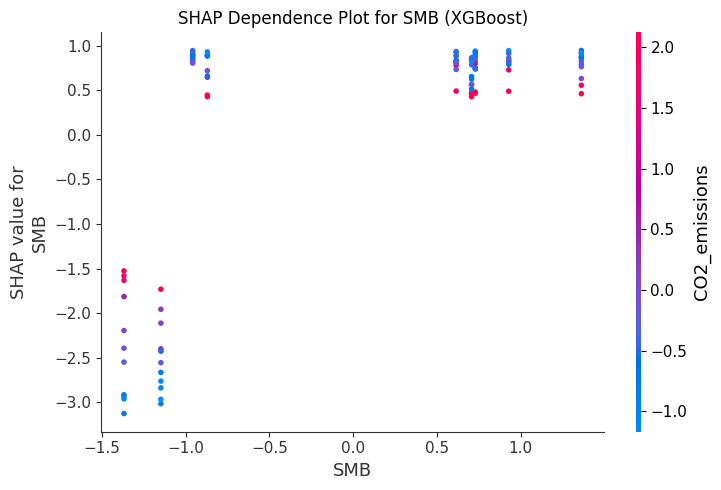

Plotting dependence for: Env_score


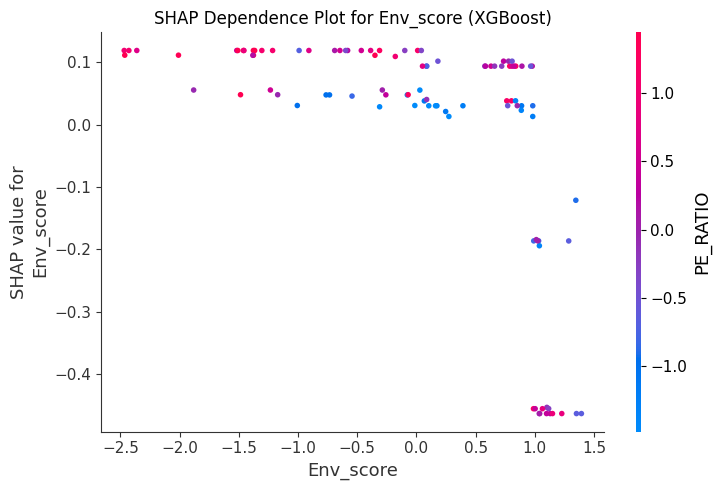

Plotting dependence for: PE_RATIO


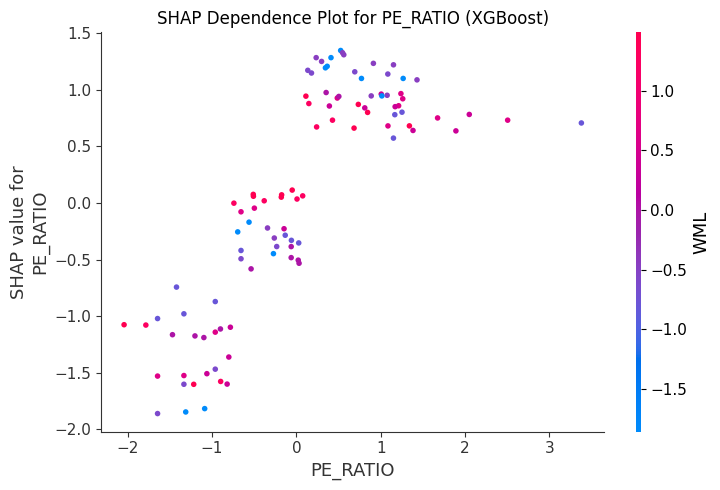


Skipping Machine Learning Analysis: Not enough unique firms for Grouped Cross-Validation.

--- Analysis Complete ---


In [15]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller, grangercausalitytests
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan
import warnings
import sys # For sys.exit()

# Suppress specific warnings for cleaner output during demonstrations
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=pd.errors.SettingWithCopyWarning)

# --- CRITICAL: Ensure linearmodels, arch, xgboost, and shap are up to date ---
# If running in Google Colab or similar environment, execute these lines
# before running the script/notebook to avoid version-related errors.
# !pip install --upgrade linearmodels arch xgboost shap matplotlib seaborn scikit-learn
# --- End of upgrade commands ---

# Enable experimental iterative imputer for MICE
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler
from linearmodels.panel import PanelOLS, RandomEffects, PooledOLS
from sklearn.decomposition import PCA # For Principal Component Analysis

# --- ML Specific Imports ---
from sklearn.ensemble import RandomForestClassifier # Changed to Classifier
from xgboost import XGBClassifier # Changed to Classifier
from sklearn.model_selection import GroupKFold, GridSearchCV # Added GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve # Classification metrics
import shap # For model interpretability
import matplotlib.pyplot as plt # For plotting
import seaborn as sns # For nicer plots


# --- 1. Load and Preprocess Data (Re-using your existing data loading and preprocessing) ---

# Load Fama-French 5 Factors data
try:
    # --- UPDATED ESG DATA FILE PATH HERE ---
    ff_df = pd.read_csv('/content/ff_5_Factors.csv')
    esg_df = pd.read_csv('/content/Transport_esg_dataset.csv') # Changed from Services_Sector_esg_dataset.csv
except FileNotFoundError:
    print("Ensure 'ff_5_Factors.csv' and 'Transport_esg_dataset.csv' are in the correct path.")
    sys.exit(1) # Exit if files are not found

print("--- Data Loading Complete ---")
print("Fama-French Data Head:\n", ff_df.head())
print("\nESG Data Head:\n", esg_df.head())

# --- Fama-French Data Preprocessing ---
ff_df['Date'] = pd.to_datetime(ff_df['Date'], format='%Y%m')
ff_df['Year'] = ff_df['Date'].dt.year
ff_df['Year'] = ff_df['Year'].astype(int)

# Use intersection to handle cases where 'WML' might be missing in a 5-factor file
all_possible_factor_cols = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF', 'WML']
factor_cols = list(set(all_possible_factor_cols).intersection(ff_df.columns))

# Ensure 'RF' is always included if available for annual aggregation mean
if 'RF' in ff_df.columns:
    non_rf_factor_cols = [col for col in factor_cols if col != 'RF']
else:
    non_rf_factor_cols = factor_cols # No RF column

# Assuming FF factors in input are already percentages (e.g., 5.61 for 5.61%)
# Convert them to decimal (e.g., 0.0561) for compounding calculations.
for col in non_rf_factor_cols:
    if col in ff_df.columns and ff_df[col].dtype in ['float64', 'int64'] and ff_df[col].max() > 1: # Heuristic: if max > 1, assume percentage
        ff_df[col] = ff_df[col] / 100.0

# Compound monthly returns to annual returns for factors (except RF)
ff_annual = ff_df.groupby('Year')[non_rf_factor_cols].apply(lambda x: (1 + x).prod() - 1, include_groups=False).reset_index()

# For RF, take the mean as it's typically risk-free rate, not compounded return for the period.
# RF should also be in decimal for correct subtraction.
if 'RF' in ff_df.columns:
    ff_annual['RF'] = ff_df.groupby('Year')['RF'].mean().reset_index(drop=True)

ff_annual['Year'] = ff_annual['Year'].astype(int)


# --- ESG Data Preprocessing ---
esg_df.rename(columns={'Date': 'Year'}, inplace=True)
esg_df['Year'] = pd.to_numeric(esg_df['Year'], errors='coerce').astype(pd.Int64Dtype())
esg_df.dropna(subset=['Identifier (RIC)', 'Year'], inplace=True)

if 'Industry' not in esg_df.columns:
    print("Warning: 'Industry' column not found in ESG data. Cannot perform industry-adjusted feature engineering.")

numeric_cols_esg = ['ESG_score', 'Social_score', 'Gov_score', 'Env_score', 'BVPS', 'Market_cap', 'Shares',
                    'Net_income', 'RETURN_ON_ASSET', 'QUICK_RATIO', 'ASSET_GROWTH', 'FNCL_LVRG',
                    'PE_RATIO', 'Scope_1', 'Scope_2', 'CO2_emissions', 'Energy_use', 'Water_use',
                    'Water_recycle', 'Toxic_chem_red', 'Injury_rate', 'Women_Employees',
                    'Human_Rights', 'Strikes', 'Turnover_empl', 'Board_Size',
                    'Shareholder_Rights', 'Board_gen_div', 'Bribery', 'Recycling_Initiatives', 'Total_assets']

for col in numeric_cols_esg:
    if col in esg_df.columns:
        esg_df[col] = pd.to_numeric(esg_df[col], errors='coerce')

# --- FIX: Assume RETURN_ON_ASSET in input is already percentage (e.g., 23.36) ---
# Do NOT divide by 100 here if it's already percentage.
# If your raw data for RETURN_ON_ASSET is truly in big numbers (e.g., 2336 for 23.36%), then this line is needed:
# if 'RETURN_ON_ASSET' in esg_df.columns and esg_df['RETURN_ON_ASSET'].max() > 1000: # Heuristic to detect huge numbers
#     esg_df['RETURN_ON_ASSET'] = esg_df['RETURN_ON_ASSET'] / 100.0 # Scale to percentage
# For now, let's assume it's already percentage like 23.36 in the input.

print(f"\nESG Years (unique, type {esg_df['Year'].dtype}): {sorted(esg_df['Year'].dropna().unique())}")
print(f"FF Annual Years (unique, type {ff_annual['Year'].dtype}): {sorted(ff_annual['Year'].unique())}")


# --- Merge Dataframes ---
rf_for_merge = ff_annual[['Year', 'RF']].copy() if 'RF' in ff_annual.columns else pd.DataFrame(columns=['Year', 'RF'])
esg_df_merged = pd.merge(esg_df, rf_for_merge, on='Year', how='left')

# --- FIX: Calculate Excess Return of the Firm ---
# Assuming RETURN_ON_ASSET is in percentage (e.g., 23.36%)
# Assuming RF from ff_annual is in decimal (e.g., 0.000833)
# To get Excess_Return_Firm in percentage (e.g., 23.35%), RF needs to be scaled up before subtraction.
if 'RETURN_ON_ASSET' in esg_df_merged.columns and 'RF' in esg_df_merged.columns:
    esg_df_merged['Excess_Return_Firm'] = esg_df_merged['RETURN_ON_ASSET'] - (esg_df_merged['RF'] * 100.0) # RF in percentage for subtraction
else:
    print("Warning: 'Excess_Return_Firm' cannot be calculated. Ensure 'RETURN_ON_ASSET' and 'RF' are available.")
    esg_df_merged['Excess_Return_Firm'] = np.nan

# Final merge with all FF factors
final_df = pd.merge(esg_df_merged, ff_annual.drop(columns=['RF'], errors='ignore'), on='Year', how='left')

# --- Data Scaling: Convert FF factors to Percentage for consistency with Excess_Return_Firm ---
# FF factors from ff_annual are currently in decimal (0.0x) after compounding.
# Convert them to percentage (X.XX) to match Excess_Return_Firm.
ff_factors_to_scale_to_percent = [col for col in non_rf_factor_cols if col in final_df.columns and col != 'RF']
for col in ff_factors_to_scale_to_percent:
    final_df[col] = final_df[col] * 100.0


print("\n--- Merged Data Head (ESG and Fama-French) ---\n", final_df.head())
print("\nMissing values before imputation (in final_df):\n", final_df.isnull().sum()[final_df.isnull().sum() > 0])


# --- 2. MICE Imputation ---
cols_for_imputation = [
    'ESG_score', 'Social_score', 'Gov_score', 'Env_score',
    'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'WML',
    'BVPS', 'Market_cap', 'Shares', 'Net_income', 'RETURN_ON_ASSET',
    'QUICK_RATIO', 'ASSET_GROWTH', 'FNCL_LVRG', 'PE_RATIO', 'Total_assets',
    'RF', 'Excess_Return_Firm', 'Scope_1', 'Scope_2', 'CO2_emissions', 'Energy_use',
    'Water_use', 'Water_recycle', 'Toxic_chem_red', 'Injury_rate', 'Women_Employees',
    'Human_Rights', 'Strikes', 'Turnover_empl', 'Board_Size',
    'Shareholder_Rights', 'Board_gen_div', 'Bribery', 'Recycling_Initiatives'
]
cols_for_imputation = [col for col in cols_for_imputation if col in final_df.columns]

imputable_df = final_df[cols_for_imputation]
threshold = 0.8
cols_to_drop_from_imputation = [col for col in imputable_df.columns if imputable_df[col].isnull().sum() / len(imputable_df) > threshold]
imputable_df_clean = imputable_df.drop(columns=cols_to_drop_from_imputation)

if not imputable_df_clean.empty and len(imputable_df_clean.columns) > 0:
    imputer = IterativeImputer(max_iter=10, random_state=0)
    imputed_data = imputer.fit_transform(imputable_df_clean)
    imputed_df = pd.DataFrame(imputed_data, columns=imputable_df_clean.columns, index=imputable_df_clean.index)

    for col in imputed_df.columns:
        final_df[col] = imputed_df[col]
else:
    print("\nWarning: No suitable numerical columns found for MICE imputation or imputable_df_clean is empty.")


# Handle remaining NaNs after MICE (ffill/bfill for panel, then mean/median)
final_df = final_df.set_index(['Identifier (RIC)', 'Year']).sort_index()
final_df = final_df.groupby(level='Identifier (RIC)').ffill().bfill()

for col in final_df.columns:
    if final_df[col].isnull().any():
        if pd.api.types.is_numeric_dtype(final_df[col]):
            final_df[col] = final_df[col].fillna(final_df[col].mean())
        else:
            final_df[col] = final_df[col].fillna(final_df[col].mode()[0] if not final_df[col].mode().empty else 'Unknown')

print("\n--- Missing values after MICE and ffill/bfill (before final model-specific drop) ---\n", final_df.isnull().sum()[final_df.isnull().sum() > 0])

dependent_var = 'Excess_Return_Firm'
all_panel_independent_options = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'WML',
                                 'ESG_score', 'Social_score', 'Gov_score', 'Env_score']
available_for_final_drop = [col for col in all_panel_independent_options if col in final_df.columns and not final_df[col].isnull().all()]

all_vars_for_final_drop = [dependent_var] + available_for_final_drop
if 'Market_cap' in final_df.columns:
    all_vars_for_final_drop.append('Market_cap')
if 'Industry' in final_df.columns:
    all_vars_for_final_drop.append('Industry')

for col in all_vars_for_final_drop:
    if col == 'Industry':
        if not pd.api.types.is_numeric_dtype(final_df[col]):
            final_df[col] = final_df[col].astype('category')
    else:
        final_df[col] = pd.to_numeric(final_df[col], errors='coerce')


initial_rows_count = len(final_df)
final_df.dropna(subset=[col for col in all_vars_for_final_drop if col != 'Industry'], inplace=True)
dropped_rows_count = initial_rows_count - len(final_df)
print(f"\nDropped {dropped_rows_count} rows due to NaNs in essential model-specific columns (excluding Industry if categorical).")

print("\nFinal Data Head after Preprocessing and Imputation (ready for models):\n", final_df.head())
print("Shape of final_df:", final_df.shape)

if final_df.empty:
    raise ValueError("DataFrame is empty after critical NaN handling for model-specific columns. Cannot proceed with analysis.")


# --- Implement Recommendations (Continue from previous code) ---

# Recommendation 1: Refine ESG Factor Construction
if 'Market_cap' in final_df.columns and 'ESG_score' in final_df.columns:
    vw_esg_df = final_df.reset_index().copy()
    vw_esg_df['Market_cap_weighted_ESG'] = vw_esg_df['ESG_score'] * vw_esg_df['Market_cap']
    market_esg_factor_vw = vw_esg_df.groupby('Year').apply(lambda x: x['Market_cap_weighted_ESG'].sum() / x['Market_cap'].sum(), include_groups=False)\
                                    .rename('Market_ESG_Factor_VW').reset_index()
    print("\n--- Value-weighted Market ESG Factor Head ---\n", market_esg_factor_vw.head())
else:
    print("\nWarning: Skipping Value-weighted Market ESG Factor calculation. 'Market_cap' or 'ESG_score' not found.")
    market_esg_factor_vw = pd.DataFrame(columns=['Year', 'Market_ESG_Factor_VW'])


esg_sub_scores = ['ESG_score', 'Social_score', 'Gov_score', 'Env_score']
esg_sub_scores_for_pca = [col for col in esg_sub_scores if col in final_df.columns and final_df[col].std() > 0]
if len(esg_sub_scores_for_pca) >= 2:
    print(f"\n--- Performing PCA on firm-level ESG sub-scores: {esg_sub_scores_for_pca} ---")
    pca_esg_data = final_df[esg_sub_scores_for_pca].copy()

    scaler_esg_pca = StandardScaler()
    scaled_esg_data = scaler_esg_pca.fit_transform(pca_esg_data)

    pca_esg = PCA(n_components=1)
    final_df['ESG_PC1'] = pca_esg.fit_transform(scaled_esg_data)
    print(f"Explained variance ratio of ESG_PC1: {pca_esg.explained_variance_ratio_[0]:.4f}")
else:
    print(f"\nSkipping PCA for ESG sub-scores: Not enough suitable columns (needs >=2 non-constant columns). Available: {esg_sub_scores_for_pca}")
    if 'ESG_score' in final_df.columns:
        final_df['ESG_PC1'] = final_df['ESG_score']
    else:
        final_df['ESG_PC1'] = np.nan


# Recommendation 2: Address Multicollinearity (HML and CMA)
ff_factors_for_pca = ['HML', 'CMA']
ff_factors_for_pca_clean = [col for col in ff_factors_for_pca if col in final_df.columns and final_df[col].std() > 0]

if len(ff_factors_for_pca_clean) >= 2:
    print(f"\n--- Performing PCA on Fama-French factors for multicollinearity: {ff_factors_for_pca_clean} ---")
    ff_pca_components = 2
    pca_ff_data = final_df[ff_factors_for_pca_clean].copy()

    scaler_ff_pca = StandardScaler()
    scaled_ff_data = scaler_ff_pca.fit_transform(pca_ff_data)

    pca_ff = PCA(n_components=min(ff_pca_components, len(ff_factors_for_pca_clean)))
    ff_pcs = pca_ff.fit_transform(scaled_ff_data)

    final_df['FF_HML_CMA_PC1'] = ff_pcs[:, 0]
    if ff_pcs.shape[1] > 1:
        final_df['FF_HML_CMA_PC2'] = ff_pcs[:, 1]
        print(f"Explained variance ratios for FF_HML_CMA_PC1: {pca_ff.explained_variance_ratio_[0]:.4f}, FF_HML_CMA_PC2: {pca_ff.explained_variance_ratio_[1]:.4f}")
    else:
        print(f"Only one principal component extracted for FF HML/CMA.")
        final_df['FF_HML_CMA_PC2'] = np.nan

    print(f"Note: {pca_ff.explained_variance_ratio_[0]*100:.2f}% explained variance by PC1 indicates extreme collinearity between HML and CMA.")
    print("This implies they convey almost identical information, and one could potentially be dropped without PCA.")

    print("\n--- VIF Check with PCA-derived HML/CMA factors ---")
    independent_vars_panel_pca_ff = ['Mkt-RF', 'SMB', 'RMW', 'WML', 'FF_HML_CMA_PC1']
    if 'FF_HML_CMA_PC2' in final_df.columns:
        independent_vars_panel_pca_ff.append('FF_HML_CMA_PC2')
    if 'ESG_score' in final_df.columns:
        independent_vars_panel_pca_ff.append('ESG_score')

    vif_features_clean = [col for col in independent_vars_panel_pca_ff if col in final_df.columns and final_df[col].std() > 0]

    if len(vif_features_clean) > 0:
        X_vif_pca_ff = final_df[vif_features_clean].copy()
        X_vif_pca_ff_with_const = sm.add_constant(X_vif_pca_ff, has_constant='add')

        scaler_vif = StandardScaler()
        X_vif_pca_ff_scaled_values = scaler_vif.fit_transform(X_vif_pca_ff_with_const)
        X_vif_pca_ff_scaled_df = pd.DataFrame(X_vif_pca_ff_scaled_values, columns=X_vif_pca_ff_with_const.columns, index=X_vif_pca_ff_with_const.index)

        try:
            vif_data_pca_ff = pd.DataFrame()
            vif_data_pca_ff["feature"] = X_vif_pca_ff_scaled_df.columns
            vif_data_pca_ff["VIF"] = [variance_inflation_factor(X_vif_pca_ff_scaled_df.values, i) for i in range(X_vif_pca_ff_scaled_df.shape[1])]
            vif_data_pca_ff = vif_data_pca_ff.loc[vif_data_pca_ff['feature'] != 'const']
            print(vif_data_pca_ff)
        except np.linalg.LinAlgError as e:
            print(f"Error calculating VIF: {e}. This might happen if there's perfect multicollinearity or too few observations relative to features.")
            print("Skipping VIF calculation.")
    else:
        print("Insufficient or problematic features available for VIF calculation.")

    independent_vars_panel = vif_features_clean
else:
    print("\nSkipping PCA for Fama-French HML/CMA: Not enough suitable columns. Using original factors but warning about multicollinearity.")
    independent_vars_panel = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'WML', 'ESG_score']
    independent_vars_panel = [col for col in independent_vars_panel if col in final_df.columns and final_df[col].std() > 0]

    print("\n--- VIF (Variance Inflation Factor) Check with ORIGINAL factors ---")
    if len(independent_vars_panel) > 0:
        X_vif = final_df[independent_vars_panel]
        X_vif_with_const = sm.add_constant(X_vif, has_constant='add')
        X_vif_scaled_values = StandardScaler().fit_transform(X_vif_with_const)
        X_vif_scaled_df = pd.DataFrame(X_vif_scaled_values, columns=X_vif_with_const.columns, index=X_vif_with_const.index)

        try:
            vif_data = pd.DataFrame()
            vif_data["feature"] = X_vif_scaled_df.columns
            vif_data["VIF"] = [variance_inflation_factor(X_vif_scaled_df.values, i) for i in range(X_vif_scaled_df.shape[1])]
            vif_data = vif_data.loc[vif_data['feature'] != 'const']
            print(vif_data)
            if 'HML' in vif_data['feature'].values and 'CMA' in vif_data['feature'].values:
                if vif_data.loc[vif_data['feature'] == 'HML', 'VIF'].iloc[0] > 5 or \
                   vif_data.loc[vif_data['feature'] == 'CMA', 'VIF'].iloc[0] > 5:
                    print("Warning: High VIF values for HML and/or CMA indicate severe multicollinearity.")
        except np.linalg.LinAlgError as e:
            print(f"Error calculating VIF: {e}. This might happen if there's perfect multicollinearity or too few observations relative to features.")
            print("Skipping VIF calculation.")
    else:
        print("Insufficient or problematic features available for VIF calculation.")


# --- NEW SECTION: Exploratory Data Analysis (EDA) Plots ---
print("\n--- Exploratory Data Analysis (EDA) Plots ---")
temp_df_eda = final_df.reset_index().copy()

# Plot 1: Violin Plot for Excess_Return_Firm by Industry
if 'Excess_Return_Firm' in temp_df_eda.columns and 'Industry' in temp_df_eda.columns and not temp_df_eda['Industry'].isnull().all():
    # Filter to industries with more than a few observations for meaningful plots
    industry_counts = temp_df_eda['Industry'].value_counts()
    industries_to_plot = industry_counts[industry_counts >= 5].index.tolist() # Only plot industries with at least 5 observations

    if industries_to_plot:
        plt.figure(figsize=(10, 6))
        sns.violinplot(data=temp_df_eda[temp_df_eda['Industry'].isin(industries_to_plot)], x='Industry', y='Excess_Return_Firm', inner='quartile')
        plt.title('Distribution of Excess Firm Returns by Industry (Violin Plot)')
        plt.xlabel('Industry')
        plt.ylabel('Excess Firm Return (%)')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
    else:
        print("Skipping Violin Plot for Excess_Return_Firm by Industry: Not enough industries with sufficient observations.")
else:
    print("Skipping Violin Plot for Excess_Return_Firm by Industry: Required columns not found or Industry is all NaN.")

# Plot 2: Box Plot for ESG_score by Year
if 'ESG_score' in temp_df_eda.columns and 'Year' in temp_df_eda.columns:
    if not temp_df_eda['ESG_score'].isnull().all():
        plt.figure(figsize=(10, 6))
        sns.boxplot(data=temp_df_eda, x='Year', y='ESG_score')
        plt.title('Distribution of ESG Score by Year (Box Plot)')
        plt.xlabel('Year')
        plt.ylabel('ESG Score')
        plt.tight_layout()
        plt.show()
    else:
        print("Skipping Box Plot for ESG_score by Year: ESG_score column is all NaN.")
else:
    print("Skipping Box Plot for ESG_score by Year: Required columns not found.")


# --- 3. Panel Data Analysis (with Robust Standard Errors) ---
print("\n--- Panel Data Analysis (with Robust Standard Errors) ---")
print(f"Dependent Variable: {dependent_var}")
print(f"Independent Variables: {independent_vars_panel}")

pooled_res, fe_res, re_res = None, None, None

if not final_df.empty and len(independent_vars_panel) > 0 and final_df.shape[0] > len(independent_vars_panel):
    exog_panel_base = final_df[independent_vars_panel]
    exog_panel_base = exog_panel_base.loc[:, exog_panel_base.std() > 0]

    if exog_panel_base.empty:
        print("Skipping Panel Data Analysis: No independent variables with variance available.")
    elif final_df[dependent_var].isnull().all():
        print("Skipping Panel Data Analysis: Dependent variable is all NaN.")
    else:
        # Pooled OLS Model
        print("\n--- Pooled OLS Model (Robust Standard Errors) ---")
        try:
            exog_pooled = sm.add_constant(exog_panel_base)
            pooled_model = PooledOLS(final_df[dependent_var], exog_pooled)
            pooled_res = pooled_model.fit(cov_type='robust')
            print(pooled_res)
        except Exception as e:
            print(f"Error running Pooled OLS: {e}")

        # Fixed Effects (Within) Model
        print("\n--- Fixed Effects (Within) Model (Robust Standard Errors) ---")
        try:
            exog_fe = sm.add_constant(exog_panel_base)
            fe_model = PanelOLS(final_df[dependent_var], exog_fe, entity_effects=True)
            fe_res = fe_model.fit(cov_type='robust')
            print(fe_res)
        except Exception as e:
            print(f"Error running Fixed Effects Model: {e}")

        # Random Effects Model
        print("\n--- Random Effects Model (Robust Standard Errors) ---")
        try:
            re_model = RandomEffects(final_df[dependent_var], sm.add_constant(exog_panel_base))
            re_res = re_model.fit(cov_type='robust')
            print(re_res)
        except Exception as e:
            print(f"Error running Random Effects Model: {e}")


        print("\n--- Hausman Test (Fixed vs. Random Effects) ---")
        try:
            if fe_res is not None and re_res is not None:
                if hasattr(fe_res, 'compare') and callable(fe_res.compare):
                    try:
                        hausman_comparison = fe_res.compare(re_res)
                        if 'Hausman' in hausman_comparison.tests:
                            hausman_pvalue = hausman_comparison.tests['Hausman'].pvalue
                            hausman_stat = hausman_comparison.tests['Hausman'].stat
                            print(f"\nHausman Test Statistic: {hausman_stat:.2f}, P-value: {hausman_pvalue:.4f}")
                            if hausman_pvalue < 0.05:
                                print("Decision: Reject H0. Fixed Effects model is preferred.")
                            else:
                                print("Decision: Fail to reject H0. Random Effects model is preferred.")
                        else:
                            print("Hausman test results not found in the comparison object. This can happen with older linearmodels versions or certain model specifications.")
                            print("Please consider upgrading linearmodels: `!pip install --upgrade linearmodels`")
                    except Exception as inner_e:
                        print(f"An error occurred during Hausman test comparison: {inner_e}")
                        print("Please ensure your linearmodels library is updated: `!pip install --upgrade linearmodels`")
                else:
                    print("Hausman test comparison method may have changed (lacks .compare() method). Please update linearmodels to the latest version.")
                    print("Consider upgrading linearmodels: `!pip install --upgrade linearmodels`")
            else:
                print("Hausman test skipped: Fixed Effects or Random Effects models were not successfully fitted.")
        except Exception as e:
            print(f"An unexpected error occurred during Hausman Test: {e}.")

        print("\n--- F-Test (Pooled vs Fixed Effects) ---")
        if fe_res is not None and pooled_res is not None:
            try:
                if hasattr(fe_res, 'f_statistic_pooled'):
                    f_test_poolability = fe_res.f_statistic_pooled
                    print(f"F-statistic for Poolability: {f_test_poolability.stat:.3f}")
                    print(f"P-value: {f_test_poolability.pval:.4f}")
                    print(f"Distribution: F({f_test_poolability.df_num},{f_test_poolability.df_denom})")
                    if f_test_poolability.pval < 0.05:
                        print("Decision: Reject H0. Entity effects are jointly significant. Fixed Effects model is strongly preferred over Pooled OLS.")
                    else:
                        print("Decision: Fail to reject H0. Entity effects are not jointly significant. Pooled OLS might be preferred.")
                else:
                    print("f_statistic_pooled attribute not found. This might be due to linearmodels version or model specification.")
                    print("Falling back to overall F-test of Fixed Effects model.")
                    if hasattr(fe_res, 'f_statistic') and fe_res.f_statistic.pval < 0.05:
                        print(f"F-statistic for Fixed Effects overall model: {fe_res.f_statistic.stat:.2f} (p-value: {fe_res.f_statistic.pval:.4f})")
                        print("Decision based on overall FE F-test: Model is significant. Fixed Effects preferred over simple OLS (with a caveat that this is not a direct poolability test).")
                    else:
                        print(f"F-statistic for Fixed Effects overall model: {fe_res.f_statistic.stat:.2f} (p-value: {fe_res.f_statistic.pval:.4f})")
                        print("Decision based on overall FE F-test: Model is NOT significant. Pooled OLS might be preferred, but overall model fit is weak.")
            except Exception as e:
                print(f"Error performing F-test for Poolability: {e}")
        else:
            print("F-test skipped: Fixed Effects or Pooled OLS models were not successfully fitted.")


        # Recommendation 5 (Optional): Decompose ESG Score
        independent_vars_panel_decomposed_esg = ['Mkt-RF', 'SMB', 'RMW', 'WML', 'ESG_PC1', 'Social_score', 'Gov_score', 'Env_score']
        independent_vars_panel_decomposed_esg = [col for col in independent_vars_panel_decomposed_esg if col in final_df.columns and final_df[col].std() > 0]

        if len(independent_vars_panel_decomposed_esg) > 0 and final_df.shape[0] > len(independent_vars_panel_decomposed_esg):
            print("\n--- Panel Data Analysis with Decomposed ESG Factors (Robust Standard Errors) ---")
            print(f"Dependent Variable: {dependent_var}")
            print(f"Independent Variables: {independent_vars_panel_decomposed_esg}")

            try:
                exog_decomposed_esg_fe = sm.add_constant(final_df[independent_vars_panel_decomposed_esg])
                fe_decomposed_esg_model = PanelOLS(final_df[dependent_var], exog_decomposed_esg_fe, entity_effects=True)
                fe_decomposed_esg_res = fe_decomposed_esg_model.fit(cov_type='robust')
                print(fe_decomposed_esg_res)
            except Exception as e:
                print(f"Error running Fixed Effects Model with Decomposed ESG: {e}")
        else:
            print("\nSkipping Decomposed ESG Model: Not enough suitable decomposed ESG columns or no variation in them.")
else:
    print("\nSkipping all Panel Data Analysis models: Insufficient data or features after filtering essential columns.")


# --- 4. Vector Autoregression (VAR) / Vector Error Correction Model (VECM) ---
market_factors_var_base = ff_annual.set_index('Year')[['Mkt-RF', 'RF', 'SMB', 'HML', 'RMW', 'CMA', 'WML']].copy()
market_factors_var_base = market_factors_var_base[[col for col in market_factors_var_base.columns if col in ff_annual.columns]]

# Ensure market_esg_factor_vw is available and not empty before merging
if 'market_esg_factor_vw' in locals() and not market_esg_factor_vw.empty:
    var_df = pd.merge(market_factors_var_base, market_esg_factor_vw.set_index('Year'), on='Year', how='inner')

    var_data = var_df[['Mkt-RF', 'Market_ESG_Factor_VW']].copy()
    var_data.dropna(inplace=True)
    var_data = var_data.loc[:, var_data.std() > 0] # Filter columns with no variance


    print("\n--- VAR / VECM Analysis (Using Market-Level Time Series) ---")
    print("VAR Data Head:\n", var_data.head())

    print("\n--- ADF (Augmented Dickey-Fuller) Tests for Stationarity ---")
    if not var_data.empty and var_data.shape[1] >= 2:
        for col in var_data.columns:
            print(f"ADF Test for {col} (Levels):")
            if len(var_data[col].dropna()) > 1:
                adf_test_level = adfuller(var_data[col].dropna())
                print(f"  ADF Statistic: {adf_test_level[0]:.2f}")
                print(f"  P-value: {adf_test_level[1]:.4f}")
                print(f"  Critical Values (1%, 5%, 10%): {adf_test_level[4]}")
                if adf_test_level[1] < 0.05:
                    print(f"  Conclusion: {col} is likely stationary (I(0)).")
                else:
                    print(f"  Conclusion: {col} is likely non-stationary (I(1) or higher).")
                    diff_series = var_data[col].diff().dropna()
                    if not diff_series.empty and len(diff_series) > 1:
                        print(f"ADF Test for {col} (First Difference):")
                        adf_test_diff = adfuller(diff_series)
                        print(f"  ADF Statistic: {adf_test_diff[0]:.2f}")
                        print(f"  P-value: {adf_test_diff[1]:.4f}")
                        print(f"  Critical Values (1%, 5%, 10%): {adf_test_diff[4]}")
                        if adf_test_diff[1] < 0.05:
                            print(f"  Conclusion: {col} is likely stationary after first differencing (I(1)).")
                        else:
                            print(f"  Conclusion: {col} is likely non-stationary even after first differencing (I(2) or higher, or test lacks power).")
                            print("    Warning: VAR requires stationary series. Further differencing or other methods might be needed, but be cautious with limited data.")
                    else:
                        print(f"  Could not test differenced {col} due to insufficient data.")
            else:
                print(f"ADF Test for {col} (Levels): Insufficient non-NaN data points for ADF test ({len(var_data[col].dropna())} <= 1). Cannot determine stationarity.")
    else:
        print("VAR data is empty or has less than 2 columns. Skipping Stationarity Tests.")

    print("\n--- VAR Model Selection & Estimation ---")

    if not var_data.empty and 'Mkt-RF' in var_data.columns and 'Market_ESG_Factor_VW' in var_data.columns and var_data['Market_ESG_Factor_VW'].diff().dropna().shape[0] > 0:
        model_data_for_var = pd.DataFrame()
        model_data_for_var['Mkt-RF'] = var_data['Mkt-RF']
        model_data_for_var['Market_ESG_Factor_VW_diff'] = var_data['Market_ESG_Factor_VW'].diff()
        model_data_for_var.dropna(inplace=True)

        print("\nVAR model will use:")
        print("  - Mkt-RF (in levels, as it is stationary)")
        print("  - Market_ESG_Factor_VW (in first difference, assuming it becomes I(1))")
        print("  (Note: Sample size limits robustness of unit root tests and model estimation.)")

        results_var = None
        if len(model_data_for_var) > 5 and model_data_for_var.shape[1] > 1:
            model = VAR(model_data_for_var)
            try:
                calculated_maxlags = min(2, max(1, (len(model_data_for_var) // 2) - 1))
                if calculated_maxlags < 1:
                     calculated_maxlags = 1 if len(model_data_for_var) >= 3 else 0

                if calculated_maxlags > 0:
                    print(f"Fitting VAR model with maxlags={calculated_maxlags} using AIC.")
                    results_var = model.fit(maxlags=calculated_maxlags, ic='aic')
                    print(results_var.summary())

                    print("\n--- Granger Causality Tests (using original levels for conceptual test) ---")
                    if len(var_data) > 2 * calculated_maxlags and calculated_maxlags > 0:
                        gc_lag = calculated_maxlags
                        print(f"  (Using maxlag={gc_lag} for Granger tests)")

                        gc_mkt_esg = grangercausalitytests(var_data[['Mkt-RF', 'Market_ESG_Factor_VW']], maxlag=gc_lag, verbose=False)
                        for lag, test_results in gc_mkt_esg.items():
                            p_value = test_results[0]['ssr_ftest'][1]
                            print(f"  Does Mkt-RF Granger-cause Market_ESG_Factor_VW (Lag {lag})? p-value: {p_value:.4f}")
                            if p_value < 0.05:
                                print("    Yes, Mkt-RF likely Granger-causes Market_ESG_Factor_VW.")
                            else:
                                print("    No strong evidence that Mkt-RF Granger-causes Market_ESG_Factor_VW.")

                        gc_esg_mkt = grangercausalitytests(var_data[['Market_ESG_Factor_VW', 'Mkt-RF']], maxlag=gc_lag, verbose=False)
                        for lag, test_results in gc_esg_mkt.items():
                            p_value = test_results[0]['ssr_ftest'][1]
                            print(f"  Does Market_ESG_Factor_VW Granger-cause Mkt-RF (Lag {lag})? p-value: {p_value:.4f}")
                            if p_value < 0.05:
                                print("    Yes, Market_ESG_Factor_VW likely Granger-causes Mkt-RF.")
                            else:
                                print("    No strong evidence that Market_ESG_Factor_VW Granger-causes Mkt-RF.")
                    else:
                        print(f"VAR data is too short for Granger Causality tests at calculated maxlag={calculated_maxlags}.")
                        if calculated_maxlags == 0:
                            print("  Maxlag is 0, Granger Causality test requires at least lag 1.")


                    print("\n--- Homoskedasticity Test (Breusch-Pagan) on VAR Residuals ---")
                    for i, col_name in enumerate(model_data_for_var.columns):
                        resid = results_var.resid.iloc[:, i].dropna()
                        exog_bp = sm.add_constant(results_var.fittedvalues.loc[resid.index].iloc[:,i:i+1])

                        if exog_bp.empty or resid.empty or exog_bp.shape[0] != resid.shape[0] or exog_bp.shape[1] == 0:
                            print(f"    Could not perform Breusch-Pagan for {col_name}: Data mismatch or empty for BP test (shapes: resid={resid.shape}, exog={exog_bp.shape}).")
                            continue
                        try:
                            lm_stat, lm_p_value, f_stat, f_p_value = het_breuschpagan(resid, exog_bp)

                            print(f"  Breusch-Pagan Test for {col_name} residuals:")
                            print(f"    LM Statistic: {lm_stat:.2f}, P-value (LM): {lm_p_value:.4f}")
                            print(f"    F-Statistic: {f_stat:.2f}, P-value (F): {f_p_value:.4f}")
                            if lm_p_value < 0.05:
                                print(f"    Conclusion: Significant heteroskedasticity in {col_name} residuals (LM test).")
                            else:
                                print(f"    Conclusion: No significant heteroskedasticity in {col_name} residuals (LM test).")
                        except Exception as e:
                            print(f"    An unexpected error occurred during Breusch-Pagan for {col_name}: {e}")
                else:
                    print(f"Cannot fit VAR model with maxlags=0, skipping. Requires at least 3 observations for lag 1.")

            except Exception as e:
                print(f"Error fitting VAR model: {e}")
        else:
            print(f"Not enough data points ({len(model_data_for_var)}) for VAR model estimation. Requires >5 observations and 2+ variables with variance.")
    else:
        print("VAR data is empty or missing essential columns. Skipping VAR analysis.")
else:
    print("VAR/VECM Analysis skipped: Market ESG Factor not calculated or is empty.")


# --- 5. GARCH (Generalized Autoregressive Conditional Heteroskedasticity) Models ---
try:
    from arch import arch_model
    print("\n--- GARCH Models (for Market Excess Returns) ---")

    if 'Mkt-RF' in var_df.columns: # Assuming var_df comes from earlier VAR preparation
        garch_data = var_df['Mkt-RF'].dropna()

        if len(garch_data) >= 10:
            am = arch_model(garch_data, vol='Garch', p=1, q=1, rescale=False)
            res_garch = am.fit(disp='off')
            print(res_garch.summary())

            print("\n--- Basic GARCH(1,1) for Mkt-RF Volatility ---")
            print(res_garch.summary())
            print("Note: GARCH-M extends this by adding conditional variance/std dev to the mean equation.")
            print("Factor-GARCH models could incorporate FF factors as exogenous regressors (e.g., Mkt-RF in mean equation).")
            print("Robust GARCH estimation typically requires significantly more observations than available (e.g., hundreds or thousands of daily/monthly points).")

        else:
            print(f"Not enough data points ({len(garch_data)}) for GARCH model estimation. A minimum of 10 observations is used here for basic GARCH. For robust GARCH, more data is usually needed.")
    else:
        print("Skipping GARCH models: 'Mkt-RF' column not found in data for GARCH analysis.")

except ImportError:
    print("\nThe 'arch' library is required for GARCH models. Please install it: pip install arch")
except Exception as e:
    print(f"An error occurred during GARCH analysis: {e}")


# --- 6. Machine Learning Analysis (Random Forest & XGBoost) ---
print("\n--- 6. Machine Learning Analysis (Random Forest & XGBoost) ---")

# --- Feature Engineering ---
print("\n--- Feature Engineering for ML Models ---")
temp_df = final_df.reset_index()

# 1. ESG Momentum (Year-over-Year Change)
for esg_col in ['ESG_score', 'Social_score', 'Gov_score', 'Env_score', 'ESG_PC1']:
    if esg_col in temp_df.columns and pd.api.types.is_numeric_dtype(temp_df[esg_col]):
        temp_df[f'{esg_col}_momentum'] = temp_df.groupby('Identifier (RIC)')[esg_col].diff()
        print(f"  - Created {esg_col}_momentum")
    else:
        print(f"  Warning: Skipping momentum for '{esg_col}' as it is not in the DataFrame or not numeric.")


# 2. Industry-Adjusted Metrics (if 'Industry' column is available and valid)
industry_numeric_cols = ['ESG_score', 'Social_score', 'Gov_score', 'Env_score', 'ESG_PC1',
                         'Market_cap', 'RETURN_ON_ASSET', 'PE_RATIO', 'Total_assets']
industry_numeric_cols_clean = [col for col in industry_numeric_cols if col in temp_df.columns and pd.api.types.is_numeric_dtype(temp_df[col]) and temp_df[col].std() > 0]

if 'Industry' in temp_df.columns and not temp_df['Industry'].isnull().all():
    print("  - Calculating industry-adjusted features...")
    actual_industry_adj_features_created = []
    for col in industry_numeric_cols_clean:
        temp_df[f'{col}_industry_mean'] = temp_df.groupby(['Year', 'Industry'])[col].transform('mean')
        temp_df[f'{col}_adj'] = temp_df[col] - temp_df[f'{col}_industry_mean']
        actual_industry_adj_features_created.append(f'{col}_adj')
    print(f"    - Created {', '.join(actual_industry_adj_features_created)}")
else:
    print("  - Skipping industry-adjusted features: 'Industry' column not available or contains only NaNs.")

final_df_ml = temp_df.set_index(['Identifier (RIC)', 'Year']).sort_index()

final_df_ml['Excess_Return_Firm_next_year'] = final_df_ml.groupby(level='Identifier (RIC)')['Excess_Return_Firm'].shift(-1)
final_df_ml['Excess_Return_Firm_next_year_Direction'] = (final_df_ml['Excess_Return_Firm_next_year'] > 0).astype(int)

ml_features = [
    'Mkt-RF', 'SMB', 'RMW', 'WML',
    'ESG_score', 'Social_score', 'Gov_score', 'Env_score', 'ESG_PC1',
    'BVPS', 'Market_cap', 'Shares', 'Net_income',
    'QUICK_RATIO', 'ASSET_GROWTH', 'FNCL_LVRG', 'PE_RATIO', 'Total_assets',
    'Scope_1', 'Scope_2', 'CO2_emissions', 'Energy_use', 'Water_use',
    'Water_recycle', 'Toxic_chem_red', 'Injury_rate', 'Women_Employees',
    'Human_Rights', 'Strikes', 'Turnover_empl', 'Board_Size',
    'Shareholder_Rights', 'Board_gen_div', 'Bribery', 'Recycling_Initiatives'
]

if 'FF_HML_CMA_PC1' in final_df_ml.columns:
    ml_features.append('FF_HML_CMA_PC1')
if 'FF_HML_CMA_PC2' in final_df_ml.columns:
    ml_features.append('FF_HML_CMA_PC2')

for col in final_df_ml.columns:
    if '_momentum' in col or '_adj' in col:
        ml_features.append(col)

ml_features_clean = []
for col in ml_features:
    if col in final_df_ml.columns and pd.api.types.is_numeric_dtype(final_df_ml[col]) and not final_df_ml[col].isnull().all() and final_df_ml[col].std() > 1e-9:
        ml_features_clean.append(col)
    elif col == 'Industry' and 'Industry' in final_df_ml.columns:
        print("Note: 'Industry' column is categorical and was excluded from numerical features. Consider one-hot encoding if needed.")


if len(ml_features_clean) == 0:
    print("Error: No numeric features available for ML after cleaning. Please check 'ml_features' list and data types.")
    sys.exit(1)


ml_df = final_df_ml.dropna(subset=['Excess_Return_Firm_next_year_Direction'] + ml_features_clean).copy()

X_ml = ml_df[ml_features_clean]
y_ml = ml_df['Excess_Return_Firm_next_year_Direction']
groups_ml = ml_df.index.get_level_values('Identifier (RIC)')

print(f"\nML Data Shape (for predicting next year's return direction): {X_ml.shape}")
print(f"Number of unique firms for ML: {len(groups_ml.unique())}")
print(f"Years covered by ML data: {ml_df.index.get_level_values('Year').min()} - {ml_df.index.get_level_values('Year').max()}")
print(f"Class distribution (0=negative/zero, 1=positive returns): \n{y_ml.value_counts(normalize=True)}")

# --- CRITICAL WARNING: Small sample size for ML ---
num_unique_firms_ml = len(groups_ml.unique())
if X_ml.empty or y_ml.empty or num_unique_firms_ml < 2 or y_ml.nunique() < 2:
    print("Not enough data or firms for robust ML analysis after lagging, feature engineering, and dropping NaNs. Skipping ML section.")
else:
    print(f"\n--- CRITICAL WARNING: SMALL NUMBER OF UNIQUE FIRMS FOR ML ({num_unique_firms_ml} firms) ---")
    print("Machine Learning models are being trained on data from a very limited number of unique firms.")
    print("This severely limits the generalizability of the models and increases the risk of overfitting to specific firm characteristics.")
    print("Results should be considered exploratory and not suitable for drawing robust, generalizable conclusions.")
    print("-" * 80)

    scaler_ml = StandardScaler()
    X_scaled_ml = scaler_ml.fit_transform(X_ml)
    X_scaled_ml_df = pd.DataFrame(X_scaled_ml, columns=X_ml.columns, index=X_ml.index)

    n_splits = min(5, num_unique_firms_ml)

    if n_splits < 2:
        print(f"Warning: Not enough unique firms ({num_unique_firms_ml}) for robust GroupKFold (min 2 splits).")
        print("Skipping full ML model training and interpretation due to insufficient unique firms for Grouped Cross-Validation.")
        print("For more robust results, ensure you have more unique 'Identifier (RIC)' values in your data.")
    else:
        gkf = GroupKFold(n_splits=n_splits)
        print(f"\nPerforming {n_splits}-fold Grouped Cross-Validation with Hyperparameter Tuning...")

        param_grid_rf = {
            'n_estimators': [50, 100],
            'max_depth': [5, 10],
            'min_samples_split': [2, 5]
        }
        param_grid_xgb = {
            'n_estimators': [50, 100],
            'max_depth': [3, 5],
            'learning_rate': [0.1, 0.05],
            'use_label_encoder': [False],
            'eval_metric': ['logloss']
        }

        print("\n--- Tuning Random Forest Classifier ---")
        grid_search_rf = GridSearchCV(RandomForestClassifier(random_state=42, class_weight='balanced'), param_grid_rf, cv=gkf, scoring='roc_auc', n_jobs=-1, verbose=1)
        try:
            grid_search_rf.fit(X_scaled_ml_df, y_ml, groups=groups_ml)
            best_rf_model = grid_search_rf.best_estimator_
            print(f"Best Random Forest Parameters: {grid_search_rf.best_params_}")
            print(f"Best Random Forest ROC AUC (CV): {grid_search_rf.best_score_:.4f}")
        except Exception as e:
            print(f"Error during Random Forest GridSearchCV: {e}")
            print("Skipping Random Forest analysis.")
            best_rf_model = None


        print("\n--- Tuning XGBoost Classifier ---")
        scale_pos_weight_val = (y_ml == 0).sum() / (y_ml == 1).sum() if (y_ml == 1).sum() > 0 else 1.0 # Handle division by zero if only one class
        grid_search_xgb = GridSearchCV(XGBClassifier(random_state=42, scale_pos_weight=scale_pos_weight_val), param_grid_xgb, cv=gkf, scoring='roc_auc', n_jobs=-1, verbose=1)
        try:
            grid_search_xgb.fit(X_scaled_ml_df, y_ml, groups=groups_ml)
            best_xgb_model = grid_search_xgb.best_estimator_
            print(f"Best XGBoost Parameters: {grid_search_xgb.best_params_}")
            print(f"Best XGBoost ROC AUC (CV): {grid_search_xgb.best_score_:.4f}")
        except Exception as e:
            print(f"Error during XGBoost GridSearchCV: {e}")
            print("Skipping XGBoost analysis.")
            best_xgb_model = None

        print("\n--- Evaluating Best Models on Cross-Validation ---")
        models = {}
        if best_rf_model: models['Random Forest (Tuned)'] = best_rf_model
        if best_xgb_model: models['XGBoost (Tuned)'] = best_xgb_model

        for name, model in models.items():
            all_y_test = []
            all_y_pred = []
            all_y_proba = []

            for fold, (train_idx, test_idx) in enumerate(gkf.split(X_scaled_ml_df, y_ml, groups_ml)):
                X_train, X_test = X_scaled_ml_df.iloc[train_idx], X_scaled_ml_df.iloc[test_idx]
                y_train, y_test = y_ml.iloc[train_idx], y_ml.iloc[test_idx]

                if X_train.empty or X_test.empty or y_train.empty or y_test.empty or y_train.nunique() < 2 or y_test.nunique() < 2:
                    print(f"Skipping fold {fold} for {name} due to insufficient classes or empty train/test split.")
                    continue

                try:
                    model.fit(X_train, y_train)
                    y_pred_fold = model.predict(X_test)
                    y_proba_fold = model.predict_proba(X_test)[:, 1]

                    all_y_test.extend(y_test)
                    all_y_pred.extend(y_pred_fold)
                    all_y_proba.extend(y_proba_fold)
                except Exception as e:
                    print(f"Error during fitting/predicting in fold {fold} for {name}: {e}")
                    continue

            if all_y_test:
                print(f"\n--- {name} Consolidated Cross-Validation Metrics ---")
                print(f"Accuracy: {accuracy_score(all_y_test, all_y_pred):.4f}")
                print(f"Precision: {precision_score(all_y_test, all_y_pred, zero_division=0):.4f}")
                print(f"Recall: {recall_score(all_y_test, all_y_pred, zero_division=0):.4f}")
                print(f"F1-Score: {f1_score(all_y_test, all_y_pred, zero_division=0):.4f}")
                print(f"ROC AUC: {roc_auc_score(all_y_test, all_y_proba):.4f}")

                cm = confusion_matrix(all_y_test, all_y_pred)
                plt.figure(figsize=(6, 5))
                sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
                plt.title(f'Confusion Matrix for {name}')
                plt.ylabel('Actual Label')
                plt.xlabel('Predicted Label')
                plt.show()

                fpr, tpr, _ = roc_curve(all_y_test, all_y_proba)
                plt.figure(figsize=(6, 5))
                plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc_score(all_y_test, all_y_proba):.2f})')
                plt.plot([0, 1], [0, 1], 'k--')
                plt.xlabel('False Positive Rate')
                plt.ylabel('True Positive Rate')
                plt.title(f'ROC Curve for {name}')
                plt.legend(loc='lower right')
                plt.show()

                print("\nFull Classification Report (Aggregated CV Predictions):")
                print(classification_report(all_y_test, all_y_pred, zero_division=0))
                print("Note on Imbalance: Precision/Recall/F1-score for minority class (0) are crucial.")
                print("Consider techniques like SMOTE or class weighting to address imbalance.")
                print("-" * 60)

            else:
                print(f"\n--- {name} Cross-Validation Results ---")
                print("Could not complete cross-validation due to insufficient data splits or empty test sets.")


        print("\n--- Feature Importance ---")
        print("Interpreting key drivers of next year's Excess Return Firm Direction.")

        if best_rf_model:
            final_rf_model = best_rf_model
            feature_importances_rf = pd.DataFrame({
                'feature': X_ml.columns,
                'importance': final_rf_model.feature_importances_
            }).sort_values(by='importance', ascending=False)
            print("\nTop 10 Feature Importances (Random Forest):")
            print(feature_importances_rf.head(10))
        else:
            print("\nRandom Forest model not trained, skipping feature importance.")

        if best_xgb_model:
            final_xgb_model = best_xgb_model
            feature_importances_xgb = pd.DataFrame({
                'feature': X_ml.columns,
                'importance': final_xgb_model.feature_importances_
            }).sort_values(by='importance', ascending=False)
            print("\nTop 10 Feature Importances (XGBoost):")
            print(feature_importances_xgb.head(10))
        else:
            print("\nXGBoost model not trained, skipping feature importance.")

        print("\n--- Model Interpretability (SHAP Values) ---")
        print("Understanding non-linear effects, interactions, and contextual dependence.")
        print("\n--- CRITICAL WARNING: SHAP plots for small sample sizes can be sparse or misleading. ---")
        print("Dependence plots especially may not show clear trends or interactions with limited data points.")
        print("Interpret these visualizations with extreme caution.")
        print("-" * 80)

        shap.initjs()

        if best_rf_model and not X_scaled_ml_df.empty:
            print("\nSHAP Summary Plot (Random Forest): Overall Feature Impact")
            try:
                sample_size_for_shap = min(100, X_scaled_ml_df.shape[0])
                np.random.seed(42)
                sampled_indices_rf = np.random.choice(X_scaled_ml_df.index, size=sample_size_for_shap, replace=False)
                X_shap_sample_df_rf = X_scaled_ml_df.loc[sampled_indices_rf]

                # Filter out columns with no variance for SHAP plotting robustness
                X_shap_sample_df_rf = X_shap_sample_df_rf.loc[:, X_shap_sample_df_rf.std() > 0]
                if X_shap_sample_df_rf.empty or X_shap_sample_df_rf.isnull().all().all():
                    print("Skipping SHAP for Random Forest: Sampled data is empty or all NaN/no variance after filtering.")
                else:
                    explainer_rf = shap.TreeExplainer(best_rf_model)
                    shap_values_rf = explainer_rf.shap_values(X_shap_sample_df_rf)

                    if isinstance(shap_values_rf, list) and len(shap_values_rf) > 1:
                        shap_values_rf_positive = shap_values_rf[1]
                    else:
                        shap_values_rf_positive = shap_values_rf

                    # FIX: Ensure shap_values_rf_positive is 2D if it's 3D
                    if shap_values_rf_positive.ndim == 3 and shap_values_rf_positive.shape[2] == 2: # This means it has an extra dimension for some reason
                        shap_values_rf_positive = shap_values_rf_positive[:, :, 0] # Take the first slice, usually
                        print("DEBUG: Corrected RF shap_values_rf_positive from 3D to 2D for dependence plot.")
                    elif shap_values_rf_positive.ndim != 2:
                        print(f"Warning: RF shap_values_rf_positive has unexpected dimensions: {shap_values_rf_positive.shape}. May cause issues.")

                    print(f"DEBUG: RF shap_values_rf_positive final shape: {shap_values_rf_positive.shape}")
                    print(f"DEBUG: RF X_shap_sample_df_rf shape: {X_shap_sample_df_rf.shape}")

                    shap.summary_plot(shap_values_rf_positive, X_shap_sample_df_rf, feature_names=X_shap_sample_df_rf.columns, show=False)
                    plt.title("SHAP Feature Importance (Random Forest)")
                    plt.tight_layout()
                    plt.show()

                    print("\nSHAP Dependence Plots (Random Forest): Non-Linearity & Interactions")
                    top_rf_features_for_plot = feature_importances_rf['feature'].head(3).tolist()
                    for feature_name in top_rf_features_for_plot:
                        if feature_name in X_shap_sample_df_rf.columns and pd.api.types.is_numeric_dtype(X_shap_sample_df_rf[feature_name]) and X_shap_sample_df_rf[feature_name].nunique() > 1:
                            print(f"Plotting dependence for: {feature_name}")
                            shap.dependence_plot(
                                ind=feature_name,
                                shap_values=shap_values_rf_positive,
                                features=X_shap_sample_df_rf,
                                feature_names=X_shap_sample_df_rf.columns,
                                interaction_index='auto',
                                show=False
                            )
                            plt.title(f"SHAP Dependence Plot for {feature_name} (Random Forest)")
                            plt.tight_layout()
                            plt.show()
                        else:
                            print(f"Skipping dependence plot for '{feature_name}': not in sample, not numeric, or no variation.")

            except Exception as e:
                print(f"Error during SHAP analysis for Random Forest: {e}")
                print("Consider using a smaller sample for SHAP or addressing memory issues if data is very large.")
                plt.close()
        else:
            print("\nSkipping SHAP analysis for Random Forest: Model not trained or data empty.")


        if best_xgb_model and not X_scaled_ml_df.empty:
            print("\nSHAP Summary Plot (XGBoost): Overall Feature Impact")
            try:
                sample_size_for_shap = min(100, X_scaled_ml_df.shape[0])
                np.random.seed(42)
                sampled_indices_xgb = np.random.choice(X_scaled_ml_df.index, size=sample_size_for_shap, replace=False)
                X_shap_sample_df_xgb = X_scaled_ml_df.loc[sampled_indices_xgb]

                # Filter out columns with no variance for SHAP plotting robustness
                X_shap_sample_df_xgb = X_shap_sample_df_xgb.loc[:, X_shap_sample_df_xgb.std() > 0]
                if X_shap_sample_df_xgb.empty or X_shap_sample_df_xgb.isnull().all().all():
                    print("Skipping SHAP for XGBoost: Sampled data is empty or all NaN/no variance after filtering.")
                else:
                    explainer_xgb = shap.TreeExplainer(best_xgb_model)
                    shap_values_xgb = explainer_xgb.shap_values(X_shap_sample_df_xgb)

                    if isinstance(shap_values_xgb, list) and len(shap_values_xgb) > 1:
                        shap_values_xgb_positive = shap_values_xgb[1]
                    else:
                        shap_values_xgb_positive = shap_values_xgb

                    if shap_values_xgb_positive.ndim != 2:
                        print(f"Warning: XGB shap_values_xgb_positive has unexpected dimensions: {shap_values_xgb_positive.shape}. May cause issues.")

                    print(f"DEBUG: XGB shap_values_xgb_positive final shape: {shap_values_xgb_positive.shape}")
                    print(f"DEBUG: XGB X_shap_sample_df_xgb shape: {X_shap_sample_df_xgb.shape}")

                    shap.summary_plot(shap_values_xgb_positive, X_shap_sample_df_xgb, feature_names=X_shap_sample_df_xgb.columns, show=False)
                    plt.title("SHAP Feature Importance (XGBoost)")
                    plt.tight_layout()
                    plt.show()

                    print("\nSHAP Dependence Plot (XGBoost): Non-Linearity for ESG_score")
                    top_xgb_features_for_plot = feature_importances_xgb['feature'].head(3).tolist()
                    for feature_name in top_xgb_features_for_plot:
                        if feature_name in X_shap_sample_df_xgb.columns and pd.api.types.is_numeric_dtype(X_shap_sample_df_xgb[feature_name]) and X_shap_sample_df_xgb[feature_name].nunique() > 1:
                            print(f"Plotting dependence for: {feature_name}")
                            shap.dependence_plot(
                                ind=feature_name,
                                shap_values=shap_values_xgb_positive,
                                features=X_shap_sample_df_xgb,
                                feature_names=X_shap_sample_df_xgb.columns,
                                interaction_index='auto',
                                show=False
                            )
                            plt.title(f"SHAP Dependence Plot for {feature_name} (XGBoost)")
                            plt.tight_layout()
                            plt.show()
                        else:
                            print(f"Skipping dependence plot for '{feature_name}': not in sample, not numeric, or no variation.")

            except Exception as e:
                print(f"Error during SHAP analysis for XGBoost: {e}")
                plt.close()
        else:
            print("\nSkipping SHAP analysis for XGBoost: Model not trained or data empty.")
#else:
    print("\nSkipping Machine Learning Analysis: Not enough unique firms for Grouped Cross-Validation.")

print("\n--- Analysis Complete ---")